In [1]:
import os
import os.path
from collections import defaultdict

from tqdm import trange

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import torch
import numpy as np
from einops import reduce, rearrange, repeat

import kPOD

from irwg.models import VAE
from irwg.data.uci_gas import UCI_GAS
from irwg.data.uci_power import UCI_POWER
from irwg.data.uci_hepmass import UCI_HEPMASS
from irwg.data.uci_miniboone import UCI_MINIBOONE
from irwg.data.bsds300 import BSDS300
from irwg.data import MissingDataModule
from irwg.data.missing_data_module import DATASET, MISSINGNESS

from irwg.utils.stats import load_stats
from irwg.utils.plotting import moving_average

In [2]:
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath} \usepackage{amsfonts}"

plt.style.use('seaborn-colorblind')

In [3]:
def plot_pairwise_marginal_scatters(fig, grid_spec, dims, data, *, alpha=0.1, color='b', 
                                    limits=None, use_rasterization=False):
    """Used for plotting pairwise 2D marginals"""
        
    artists = []
    
    for i in range(0, dims):
        for j in range(i+1, dims):
            # Plot pairs of dimensions
            ax = fig.add_subplot(grid_spec[i, j-1])
            artists.append(ax)
            if use_rasterization:
                ax.set_rasterized(True)
            
            ax.scatter(data[:, i], data[:, j], alpha=alpha, color=color)

            ax.tick_params(left=False, labelleft=False,
                           bottom=False, labelbottom=False)

            # Set common limits
            if limits is not None:
                if isinstance(limits, list):
                    y_min_v, y_max_v = limits[j]
                    x_min_v, x_max_v = limits[i]
                elif isinstance(limits, tuple):
                    y_min_v, y_max_v = limits
                    x_min_v, x_max_v = limits
                ax.set_ylim(y_min_v, y_max_v)
                ax.set_xlim(x_min_v, x_max_v)

            if i == 0:
                ax.set_title(f'dim={j}', fontsize=12)
            if j == 1:
                ax.set_ylabel(f'dim={i}', fontsize=12)

        # Create dummy axes to add labels on the left-hand side
        if 0 < i < (dims-1):
            ax = fig.add_subplot(dims-1, dims-1, i*(dims-1)+1)
            ax.set_ylabel(f'dim={i}', fontsize=12)
            # Hide the dummy axes
            ax.xaxis.set_visible(False)
            plt.setp(ax.spines.values(), visible=False)
            ax.tick_params(left=False, labelleft=False)
            ax.patch.set_visible(False)

#     grid_spec.tight_layout(fig)
    
    return artists

def plot_pairwise_marginal_scatters_(axes, dims, data, *, alpha=0.1, color='b', 
                                    limits=None, use_rasterization=False):
    """Used for plotting pairwise 2D marginals"""
        
#     artists = []
    
    for i in range(0, dims):
        for j in range(i+1, dims):
            # Plot pairs of dimensions
#             ax = fig.add_subplot(grid_spec[i, j-1])
#             artists.append(ax)
            ax=axes[i, j-1]
            if use_rasterization:
                ax.set_rasterized(True)
            
            ax.scatter(data[:, i], data[:, j], alpha=alpha, color=color)

            ax.tick_params(left=False, labelleft=False,
                           bottom=False, labelbottom=False)

            # Set common limits
            if limits is not None:
                if isinstance(limits, list):
                    y_min_v, y_max_v = limits[j]
                    x_min_v, x_max_v = limits[i]
                elif isinstance(limits, tuple):
                    y_min_v, y_max_v = limits
                    x_min_v, x_max_v = limits
                ax.set_ylim(y_min_v, y_max_v)
                ax.set_xlim(x_min_v, x_max_v)

            if i == 0:
                ax.set_title(f'dim={j}', fontsize=12)
            if j == 1:
                ax.set_ylabel(f'dim={i}', fontsize=12)

        # Create dummy axes to add labels on the left-hand side
        if 0 < i < (dims-1):
#             ax = fig.add_subplot(dims-1, dims-1, i*(dims-1)+1)
            ax=axes[i, 0]
            ax.set_ylabel(f'dim={i}', fontsize=12)
            for j in range(0, i):
                ax = axes[i, j]
                # Hide the dummy axes
                ax.xaxis.set_visible(False)
                plt.setp(ax.spines.values(), visible=False)
                ax.tick_params(left=False, labelleft=False)
                ax.patch.set_visible(False)
            

#     grid_spec.tight_layout(fig)
    
#     return artists

In [4]:
def plot_custom_stripplot(ax, data, labels, showmedians=False, showquartiles=False, show_whiskers=False, colors=None, 
                           *, no_trim=False, only_trim_up=False, use_log_scale=False, stripplot_kw={}):
    # See https://matplotlib.org/stable/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py
    def adjacent_values(vals, q1, q3):
        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
        return lower_adjacent_value, upper_adjacent_value
    
    data = [np.array(sorted(x)) for x in data]

    assert not (no_trim and only_trim_up)
    if no_trim:
        whiskers_min = [np.nanmin(x) for x in data]
        whiskers_max = [np.nanmax(x) for x in data]
        medians = [np.nanmedian(x) for x in data]
        quartile1=None
        quartile3=None
        
        data = [x[~np.isnan(x)] for x in data]
    elif only_trim_up:
        quartile1, medians, quartile3 = np.nanpercentile(data, [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        whiskers_min = [np.nanmin(x) for x in data]

        # Filtering equivalent to boxplot, see https://matplotlib.org/stable/gallery/statistics/boxplot_vs_violin.html
        data = [x[np.logical_and(x >= whiskers_min[i], x <= whiskers_max[i])] for i, x in enumerate(data)]
    else:
        quartile1, medians, quartile3 = np.nanpercentile(data, [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

        # Filtering equivalent to boxplot, see https://matplotlib.org/stable/gallery/statistics/boxplot_vs_violin.html
        data = [x[np.logical_and(x >= whiskers_min[i], x <= whiskers_max[i])] for i, x in enumerate(data)]
    
    if use_log_scale:
        data = [np.log10(x) for x in data]
        whiskers_min = np.log10(whiskers_min)
        whiskers_max = np.log10(whiskers_max)
        medians = np.log10(medians)
        if quartile1 is not None:
            quartile1 = np.log10(quartile1)
        if quartile3 is not None:
            quartile3 = np.log10(quartile3)
    
#     for i, x in enumerate(data):
#         sns.stripplot(
#             ax=ax,
#             data=x,
# #             x=i,
#             c=colors[i],
#         )
    sns.stripplot(
        ax=ax,
        data=data,
        palette=colors,
        jitter=0.4,
        **stripplot_kw,
    )
    
    if use_log_scale:
        ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = ax.get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        ax.yaxis.set_ticks(tick_range)
        ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    

    inds = np.arange(0, len(medians))
    if showmedians:
        ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    if showquartiles:
        ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    if show_whiskers:
        ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

In [5]:
def compute_ci_metrics(path_template, models, *, data_idx_true_dataset, masks_true_dataset, X_test_true_dataset, datapoint_mask=None, use_irwg_resampled=False):
    non_centered_cr_quantile_levels = {}
    non_centered_cr_err = {}
    non_centered_cr_widths = {}

    centered_cr_nominal_levels = {}
    centered_cr_err = {}
    centered_ci_widths = {}
    centered_interval_scores = {}

    for model, dir_name in models.items():
        path = path_template.format(dir_name)
        if not use_irwg_resampled:
            all_quantiles, quantile_levels, data_idx = load_uci_ci(path)
        else:
            all_quantiles, quantile_levels, data_idx = load_uci_ci_irwg_resampled(path)
        if datapoint_mask is not None:
            all_quantiles = all_quantiles[datapoint_mask]
            data_idx = data_idx[datapoint_mask]
        data_idx = torch.tensor(data_idx)

        # Verify correct data
        assert torch.all(data_idx == data_idx_true_dataset)
        assert torch.all(torch.isnan(torch.tensor(all_quantiles[..., 0])) == masks_true_dataset)

        # Get non-centered coverage/calibration
        coverage = X_test_true_dataset[..., None] <= all_quantiles
        coverage = coverage.astype(np.float32)
        coverage[masks_true_dataset] = float('nan')

        avg_coverage = np.nanmean(coverage, axis=0)
        avg_coverage = np.nanmean(avg_coverage, axis=0) # Average over dims
        non_centered_cr_err[model] = quantile_levels - avg_coverage
        non_centered_cr_quantile_levels[model] = quantile_levels
        
        # Non-centered widths
        ci_width = np.nanmean(all_quantiles, axis=0) # Avg datapoints
        ci_width = np.nanmean(ci_width, axis=0) # Avg dimensions
        non_centered_cr_widths[model] = ci_width

        # Get centered coverage/calibration
        centered_cr_nominal_levels[model] = []
        centered_cr_err[model] = []
        centered_ci_widths[model] = []
        centered_interval_scores[model] = []
        for alpha in range(len(quantile_levels)//2):
            # Centered CI nominal alpha
            nominal_alpha = quantile_levels[-(alpha+1)] - quantile_levels[alpha]
            centered_cr_nominal_levels[model].append(nominal_alpha)

            # Centered CR
            coverage = (all_quantiles[..., alpha] <= X_test_true_dataset)*(X_test_true_dataset <= all_quantiles[..., -(alpha+1)])
            coverage = coverage.astype(np.float32)
            coverage[masks_true_dataset] = float('nan')

            avg_coverage = np.nanmean(coverage, axis=0)
            avg_coverage = np.nanmean(avg_coverage, axis=0) # Average over dims
            centered_cr_err[model].append(nominal_alpha - avg_coverage)

            # Centered CI width
            ci_width = all_quantiles[..., -(alpha+1)] - all_quantiles[..., alpha]
            ci_width = np.nanmean(ci_width, axis=0) # Avg datapoints
            ci_width = np.nanmean(ci_width, axis=0) # Avg dimensions
            centered_ci_widths[model].append(ci_width)
            
            # Interval/Winkler's score
            upper = all_quantiles[..., -(alpha+1)] 
            lower = all_quantiles[..., alpha]
            interval_score = ((upper - lower) \
                              + 2 / (1-nominal_alpha) * (lower - X_test_true_dataset) * (X_test_true_dataset < lower) \
                              + 2 / (1-nominal_alpha) * (X_test_true_dataset - upper) * (X_test_true_dataset > upper))
            interval_score = np.nanmean(interval_score, axis=1) # Average over dimensions
            
            centered_interval_scores[model].append(interval_score)
            

        centered_cr_nominal_levels[model] = np.stack(centered_cr_nominal_levels[model], axis=-1)
        centered_cr_err[model] = np.stack(centered_cr_err[model], axis=-1)
        centered_ci_widths[model] = np.stack(centered_ci_widths[model], axis=-1)
        centered_interval_scores[model] = np.stack(centered_interval_scores[model], axis=-1)
        
    return {
        'non_centered_cr_quantile_levels': non_centered_cr_quantile_levels,
        'non_centered_cr_err': non_centered_cr_err,
        'non_centered_ci_widths': non_centered_cr_widths,

        'centered_cr_nominal_levels': centered_cr_nominal_levels,
        'centered_cr_err': centered_cr_err,
        'centered_ci_widths': centered_ci_widths,
        'centered_interval_scores': centered_interval_scores,
    }

def compute_ci_metrics_by_cluster(path_template, models, *, 
                                  data_idx_true_dataset, masks_true_dataset, X_test_true_dataset, 
                                  cluster_assignments, 
                                  use_irwg_resampled=False):
    output = defaultdict(lambda: defaultdict(list))
    
    clusters = np.unique(cluster_assignments)
    for cluster in clusters:
        datapoint_mask = cluster_assignments == cluster
        data_idx_true_dataset_c = data_idx_true_dataset[datapoint_mask]
        masks_true_dataset_c = masks_true_dataset[datapoint_mask]
        X_test_true_dataset_c = X_test_true_dataset[datapoint_mask]
        
        out = compute_ci_metrics(path_template, models,  
                           data_idx_true_dataset=data_idx_true_dataset_c, 
                           masks_true_dataset=masks_true_dataset_c, 
                           X_test_true_dataset=X_test_true_dataset_c, 
                           datapoint_mask=datapoint_mask, 
                           use_irwg_resampled=use_irwg_resampled)
        
        for metric, method_stats in out.items():
            if metric == 'centered_interval_scores':
                continue
            for method, stats in method_stats.items():
                output[metric][method].append(stats)
    
    for metric, method_stats in output.items():
        for method, stats in method_stats.items():
            output[metric][method] = np.stack(stats, axis=0)

    return output

def compute_ci_metrics_agains_nn_imputations(path_template, models, *,
                                             data_idx_true_dataset, masks_true_dataset,
                                             X_nn_imps,
                                             use_irwg_resampled=False):
    output = defaultdict(lambda: defaultdict(list))
    
    for i in trange(len(X_nn_imps), desc='Processing datapoints'):
        datapoint_mask = np.zeros(len(X_nn_imps)).astype(bool)
        datapoint_mask[i] = 1
        X_nn_imps_i = X_nn_imps[i] # B K D -> K D
        
        data_idx_true_dataset_c = data_idx_true_dataset[datapoint_mask]
        masks_true_dataset_c = masks_true_dataset[datapoint_mask]
        masks_true_dataset_c = repeat(masks_true_dataset_c, '1 d -> b d', b=X_nn_imps_i.shape[0])
        
        out = compute_ci_metrics(path_template, models,  
                                 data_idx_true_dataset=data_idx_true_dataset_c, 
                                 masks_true_dataset=masks_true_dataset_c, 
                                 X_test_true_dataset=X_nn_imps_i, 
                                 datapoint_mask=datapoint_mask, 
                                 use_irwg_resampled=use_irwg_resampled)
        
        for metric, method_stats in out.items():
            for method, stats in method_stats.items():
                output[metric][method].append(stats)
    
    for metric, method_stats in output.items():
        for method, stats in method_stats.items():
            output[metric][method] = np.stack(stats, axis=0)

    return output

In [6]:
def kpod_clustering_merge_small_clusters(data, *, K, min_samples_in_cluster):
    clustered_data = kPOD.k_pod(data, K)
    
    cluster_assignments = clustered_data[0]
    cluster_centers = np.array(clustered_data[1])
    
    clusters, counts = np.unique(cluster_assignments, return_counts=True)
    
    too_small_clusters = (counts < min_samples_in_cluster)
    
    if np.any(too_small_clusters):
        small_cluster_indices = np.where(too_small_clusters)[0]
        for idx in small_cluster_indices:
            current_center = cluster_centers[idx]
            dist = np.absolute(cluster_centers - current_center[None, :]).sum(-1)
            # Make sure the current cluster is removes
            dist[idx] = float('inf')
            # Find the next closest cluster
            closest_cluster_idx = np.argmin(dist)
            # Assign to closest cluster
            cluster_assignments[cluster_assignments == idx] = closest_cluster_idx
            
            # Make sure nothing is assigned to this cluster
            cluster_centers[idx] = float('inf')
            
    cluster_idx = np.unique(cluster_assignments)
    num_clusters = len(cluster_idx)
    for i in range(num_clusters):
        cluster_assignments[cluster_assignments == cluster_idx[i]] = i
            
    return cluster_assignments

def group_by_value(data, *, num_splits):
    cluster_assignments = np.zeros(len(data))
    for s in range(num_splits):
        data_s = data[:, s]
        median_s = np.nanmedian(data_s)
        less = data_s <= median_s
        
        # Assign half of nans randomly to more and the other half to less
        less += (np.random.binomial(n=1, p=np.isnan(data_s).astype(np.float32)*0.5)).astype(bool)
        
        more = ~(less)
        cluster_assignments *= 2
        cluster_assignments[more] += 1
    return cluster_assignments

In [7]:
def compute_pointwise_metrics(path_template, models, *, 
                              data_idx_true_dataset, masks_true_dataset, X_test_true_dataset, 
                              use_irwg_resampled=False, load_last_n_iterations=-1):
    rmse = {}
    mae = {}

    for model, dir_name in models.items():
        path = path_template.format(dir_name)
        if not use_irwg_resampled:
            imps_data = load_last_nstep_imputations_from_experiment(path, load_last_n_iterations, 1, filename_prefix='imputations_')
            X_imps = imps_data['imputations']
            masks = imps_data['masks']
            data_idx = imps_data['data_idx']
        else:
            imps_data = load_last_nstep_imputations_from_experiment(path, load_last_n_iterations, 1, filename_prefix='irwg_imputations_after_final_resampling_')
            X_imps = imps_data['imputations']
            masks = imps_data['masks']
            data_idx = imps_data['data_idx']
            
        # To tensor
        X_test_true_dataset = torch.tensor(X_test_true_dataset)
        data_idx = torch.tensor(data_idx)
        masks = torch.tensor(masks)
        X_imps = torch.tensor(X_imps)
        
        X_imps = rearrange(X_imps, 'b k t d -> b (t k) d')

        # Verify correct data
        assert torch.all(data_idx == data_idx_true_dataset)
        assert torch.all(masks == masks_true_dataset[:, None])
        assert torch.allclose(X_imps[:, [0]]*masks, X_test_true_dataset[:, None]*masks)
    
        # Make observed values NaN
        X_imps[repeat(masks, 'b 1 d -> b k d', k=X_imps.shape[1])] = float('nan')
        
        diff = torch.nansum(X_imps - X_test_true_dataset[:, None], dim=-1)
        
        rmse[model] = torch.mean((torch.mean(diff**2, dim=-1)**0.5), dim=0)
        mae[model] = torch.mean(torch.absolute(diff))
        
    return {
        'rmse': rmse,
        'mae': mae,
    }

def compute_pointwise_metrics_bootstrap(path_template, models, *, 
                                      data_idx_true_dataset, masks_true_dataset, X_test_true_dataset, 
                                        num_bootstrap,
                                      use_irwg_resampled=False, load_last_n_iterations=-1
                                       ):
    rmse = defaultdict(list)
    mae = defaultdict(list)
    
    bootstrap_idx_shuffles = []
    for r in range(num_bootstrap):
        bootstrap_idx_shuffle = np.random.choice(X_test_true_dataset.shape[0], size=X_test_true_dataset.shape[0], replace=True)
        bootstrap_idx_shuffles.append(bootstrap_idx_shuffle)
    
    for model, dir_name in models.items():
        path = path_template.format(dir_name)
        if not use_irwg_resampled:
            imps_data = load_last_nstep_imputations_from_experiment(path, load_last_n_iterations, 1, filename_prefix='imputations_')
            X_imps = imps_data['imputations']
            masks = imps_data['masks']
            data_idx = imps_data['data_idx']
        else:
            imps_data = load_last_nstep_imputations_from_experiment(path, load_last_n_iterations, 1, filename_prefix='irwg_imputations_after_final_resampling_')
            X_imps = imps_data['imputations']
            masks = imps_data['masks']
            data_idx = imps_data['data_idx']

        # To tensor
        X_test_true_dataset = torch.tensor(X_test_true_dataset)
        data_idx = torch.tensor(data_idx)
        masks = torch.tensor(masks)
        X_imps = torch.tensor(X_imps)

        X_imps = rearrange(X_imps, 'b k t d -> b (t k) d')
        
        # Verify correct data
        assert torch.all(data_idx == data_idx_true_dataset)
        assert torch.all(masks == masks_true_dataset[:, None])
        assert torch.allclose(X_imps[:, [0]]*masks, X_test_true_dataset[:, None]*masks)
        
        # Make observed values NaN
        X_imps[repeat(masks, 'b 1 d -> b k d', k=X_imps.shape[1])] = float('nan')
        
        diff = torch.nansum(X_imps - X_test_true_dataset[:, None], dim=-1)
        
        for r in range(num_bootstrap):
            bootstrap_idx_shuffle = bootstrap_idx_shuffles[r]

#             # Bootstrap shuffle
#             X_test_true_dataset_r = X_test_true_dataset[bootstrap_idx_shuffle]
#             data_idx_true_dataset_r = data_idx_true_dataset[bootstrap_idx_shuffle]
#             masks_true_dataset_r = masks_true_dataset[bootstrap_idx_shuffle]
#             data_idx_r = data_idx[bootstrap_idx_shuffle]
#             masks_r = masks[bootstrap_idx_shuffle]
#             X_imps_r = X_imps[bootstrap_idx_shuffle]

# #             # Verify correct data
# #             assert torch.all(data_idx_r == data_idx_true_dataset_r)
# #             assert torch.all(masks_r == masks_true_dataset_r[:, None])
# #             assert torch.allclose(X_imps_r[:, [0]]*masks_r, X_test_true_dataset_r[:, None]*masks_r)

            diff_r = diff[bootstrap_idx_shuffle]

            rmse[model].append(torch.mean((torch.mean(diff_r**2, dim=-1)**0.5), dim=0))
            mae[model].append(torch.mean(torch.absolute(diff_r)))
        
    return {
        'rmse': rmse,
        'mae': mae,
    }

In [8]:
def compute_pointwise_metrics_multiseed(path_template, models, seeds, *, 
                                      data_idx_true_dataset, masks_true_dataset, X_test_true_dataset, 
                                      use_irwg_resampled=False, load_last_n_iterations=-1):
    # To tensor
    X_test_true_dataset = torch.tensor(X_test_true_dataset)
    data_idx_true_dataset = torch.tensor(data_idx_true_dataset)
        
    rmse = {}
    mae = {}

    for model, dir_name in models.items():
#         X_imps_all = []
        rmse_all = []
        mae_all = []
        for seed in seeds:
            path = path_template.format(dir_name, seed)
            if not use_irwg_resampled:
                imps_data = load_last_nstep_imputations_from_experiment(path, load_last_n_iterations, 1, filename_prefix='imputations_')
                X_imps = torch.tensor(imps_data['imputations'])
                masks = torch.tensor(imps_data['masks'])
                data_idx = torch.tensor(imps_data['data_idx'])
            else:
                imps_data = load_last_nstep_imputations_from_experiment(path, load_last_n_iterations, 1, filename_prefix='irwg_imputations_after_final_resampling_')
                X_imps = torch.tensor(imps_data['imputations'])
                masks = torch.tensor(imps_data['masks'])
                data_idx = torch.tensor(imps_data['data_idx'])
                
            # Verify correct data
            assert torch.all(data_idx == data_idx_true_dataset)
            assert torch.all(masks == masks_true_dataset[:, None])
            assert torch.allclose(X_imps[:, 0]*masks, X_test_true_dataset[:, None]*masks)
            
#             X_imps_all.append(X_imps)
        
#             X_imps = torch.concat(X_imps_all, dim=1)
            X_imps = rearrange(X_imps, 'b k t d -> b (t k) d')

            # Make observed values NaN
            X_imps[repeat(masks, 'b 1 d -> b k d', k=X_imps.shape[1])] = float('nan')

            diff = torch.nansum(X_imps - X_test_true_dataset[:, None], dim=-1)

#             rmse[model] = torch.mean((torch.mean(diff**2, dim=-1)**0.5), dim=0)
#             mae[model] = torch.mean(torch.absolute(diff))
            rmse_all.append(torch.mean((torch.mean(diff**2, dim=-1)**0.5), dim=0))
            mae_all.append(torch.mean(torch.absolute(diff)))
        rmse[model] = torch.tensor(rmse_all)
        mae[model] = torch.tensor(mae_all)
        
    return {
        'rmse': rmse,
        'mae': mae,
    }

In [9]:
def load_last_nstep_imputations_from_experiment(path, last_n_steps, load_every_nth_step, 
                                                filename_prefix='imputations_'):
    versions = os.listdir(path)
    if len(versions) > 1:
        versions = list(sorted([int(v.split('version_')[1]) for v in versions]))
        v = versions[-1]
        v = f'version_{v}'
        print(f'Multiple versions found in {path}, loading {v}.')
    else:
        v = versions[0]
        
    path = os.path.join(path, v)
    
    imp_files = [f for f in os.listdir(path) if f.startswith(filename_prefix) and f.endswith('.npz')]
    batch_idxs = [int(f.split(filename_prefix)[1].split('.npz')[0]) for f in imp_files]
    imp_files = [f for _, f in sorted(zip(batch_idxs, imp_files))]
    data = defaultdict(list)
    if last_n_steps == -1:
        last_n_steps = 0
    for f in imp_files:
        f = np.load(os.path.join(path, f))
        keys = list(f.keys())
        for k in keys:
            if k == 'imputations':

                data[k].append(f[k][-last_n_steps::load_every_nth_step])
            else:
                data[k].append(f[k])

    for k in list(data.keys()):
        if k == 'imputations':
            data[k] = np.concatenate(data[k], axis=1)
            data[k] = rearrange(data[k], 't b k ... -> b k t ...')
        else:
            data[k] = np.concatenate(data[k], axis=0)

    return data

In [10]:
def load_eval_results(path):
    versions = os.listdir(path)
    if len(versions) > 1:
        versions = list(sorted([int(v.split('version_')[1]) for v in versions]))
        v = versions[-1]
        v = f'version_{v}'
        print(f'Multiple versions found in {path}, loading {v}.')
    else:
        v = versions[0]
        
    path = os.path.join(path, v)
    
    f = np.load(os.path.join(path, 'uci_imp_eval.npz'))
    
    return f['ci'], f['imputation_coverage'], f['ece']

def load_eval_results_irwg_resampled(path):
    versions = os.listdir(path)
    if len(versions) > 1:
        versions = list(sorted([int(v.split('version_')[1]) for v in versions]))
        v = versions[-1]
        v = f'version_{v}'
        print(f'Multiple versions found in {path}, loading {v}.')
    else:
        v = versions[0]
        
    path = os.path.join(path, v)
    
    f = np.load(os.path.join(path, 'uci_imp_eval_irwg_resampled.npz'))
    
    return f['ci'], f['imputation_coverage'], f['ece']

In [11]:
def load_uci_ci(path):
    versions = os.listdir(path)
    if len(versions) > 1:
        versions = list(sorted([int(v.split('version_')[1]) for v in versions]))
        v = versions[-1]
        v = f'version_{v}'
        print(f'Multiple versions found in {path}, loading {v}.')
    else:
        v = versions[0]
        
    path = os.path.join(path, v)
    
    f = np.load(os.path.join(path, 'uci_imp_ci.npz'))
    
    return f['all_quantiles'], f['quantiles_levels'], f['data_idx']

def load_uci_ci_irwg_resampled(path):
    versions = os.listdir(path)
    if len(versions) > 1:
        versions = list(sorted([int(v.split('version_')[1]) for v in versions]))
        v = versions[-1]
        v = f'version_{v}'
        print(f'Multiple versions found in {path}, loading {v}.')
    else:
        v = versions[0]
        
    path = os.path.join(path, v)
    
    f = np.load(os.path.join(path, 'uci_imp_ci_irwg_resampled.npz'))
    
    return f['all_quantiles'], f['quantiles_levels'], f['data_idx']

## Visualise unconditional VAE samples

### Gas

/tmp/ipykernel_3156987/1640156971.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs0.tight_layout(fig)


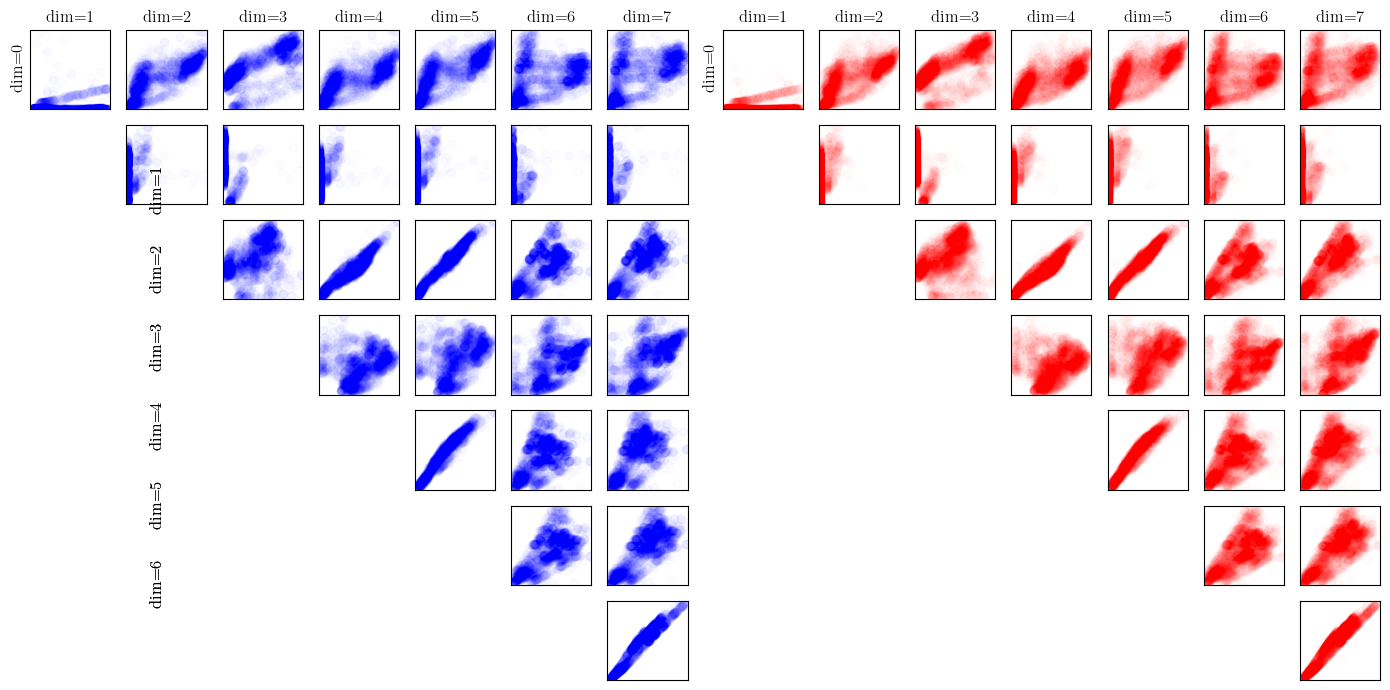

In [43]:
N = 3000

dataset = UCI_GAS('../data/')

idx = np.random.choice(len(dataset), size=N, replace=False)

data = dataset[idx]
dims = dataset.dim

min_vals = data.min(axis=0)
# min_vals = min_vals - np.absolute(min_vals)*0.2
max_vals = data.max(axis=0)
# max_vals = max_vals + np.absolute(max_vals)*0.2
limits = list(zip(min_vals, max_vals))

alpha=0.01

fig = plt.figure(figsize=(14,7))

gs0 = gridspec.GridSpec(1, 2, figure=fig)

# True

gs1 = gridspec.GridSpecFromSubplotSpec(ncols=dims-1, nrows=dims-1, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(ncols=dims-1, nrows=dims-1, subplot_spec=gs0[1])

artists1 = plot_pairwise_marginal_scatters(fig, gs1, dims, data, limits=limits, alpha=alpha)

# VAE

ds = 'uci_gas'
model = 'vae_no_kl_sched'
checkpoint = 'epoch=118-step=198135'
version = '1626685'
vae_path = (f'../logs/{ds}/imputation/{model}/seed_m20220118_d20220118/lightning_logs/'
            f'version_{version}/checkpoints/{checkpoint}.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

vae_samples = vae.sample(N).numpy()
    
artists = plot_pairwise_marginal_scatters(fig, gs2, dims, vae_samples, limits=limits, alpha=alpha, color='r')

gs0.tight_layout(fig)

### Power

/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'generator_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_network'])`.
  rank_zero_warn(
/home/vaidas/miniconda3/envs/irwg/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'var_latent_network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['var_latent_network'])`.
  rank_zero_warn(
/tmp/ipykernel_3156987/455126457.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs0.tight_layout(fig)


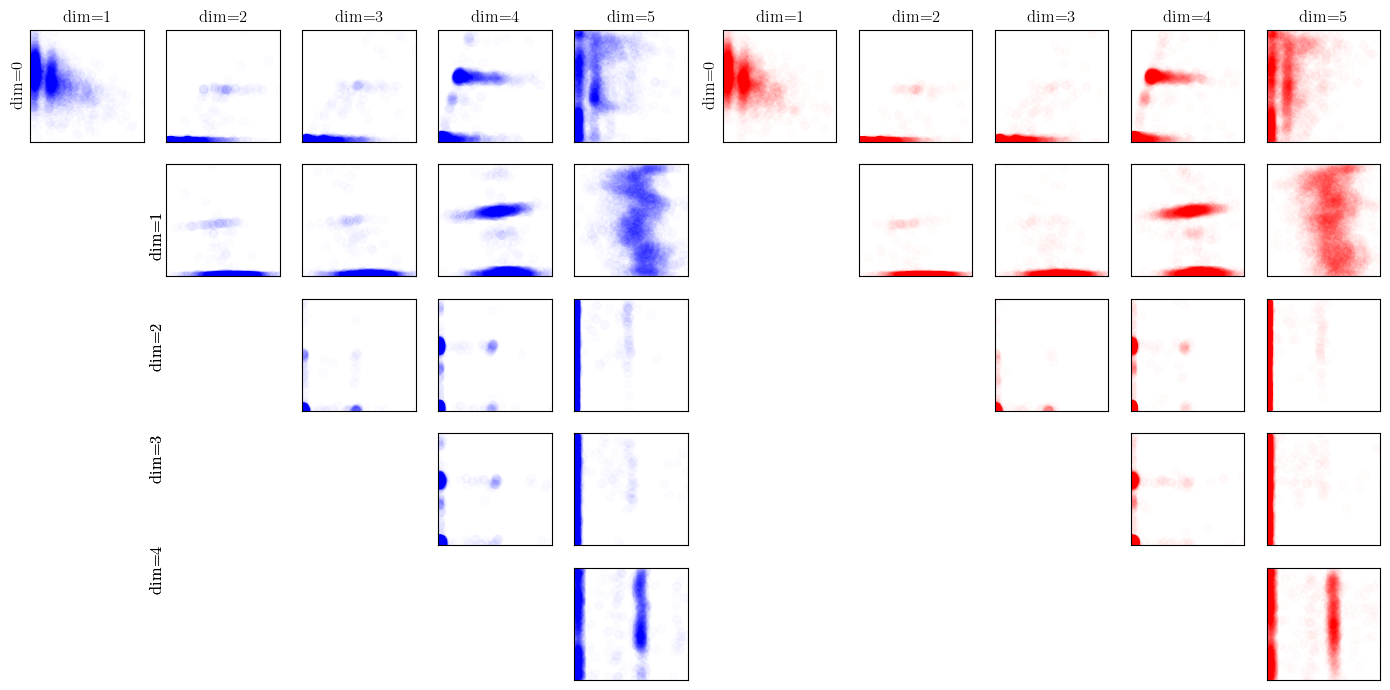

In [122]:
N = 3000

dataset = UCI_POWER('../data/')

idx = np.random.choice(len(dataset), size=N, replace=False)

data = dataset[idx]
dims = dataset.dim

min_vals = data.min(axis=0)
# min_vals = min_vals - np.absolute(min_vals)*0.2
max_vals = data.max(axis=0)
# max_vals = max_vals + np.absolute(max_vals)*0.2
limits = list(zip(min_vals, max_vals))

alpha=0.01

fig = plt.figure(figsize=(14,7))

gs0 = gridspec.GridSpec(1, 2, figure=fig)

# True

gs1 = gridspec.GridSpecFromSubplotSpec(ncols=dims-1, nrows=dims-1, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(ncols=dims-1, nrows=dims-1, subplot_spec=gs0[1])

artists1 = plot_pairwise_marginal_scatters(fig, gs1, dims, data, limits=limits, alpha=alpha)

# VAE

ds = 'uci_power'
model = 'vae_wtrainnoise_no_kl_sched'
checkpoint = 'epoch=60-step=197823'
version = '1627117'
vae_path = (f'../logs/{ds}/imputation/{model}/seed_m20220118_d20220118/lightning_logs/'
            f'version_{version}/checkpoints/{checkpoint}.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

vae_samples = vae.sample(N).numpy()
    
artists = plot_pairwise_marginal_scatters(fig, gs2, dims, vae_samples, limits=limits, alpha=alpha, color='r')

gs0.tight_layout(fig)

### Hepmass

/tmp/ipykernel_3156987/1333722742.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs0.tight_layout(fig)


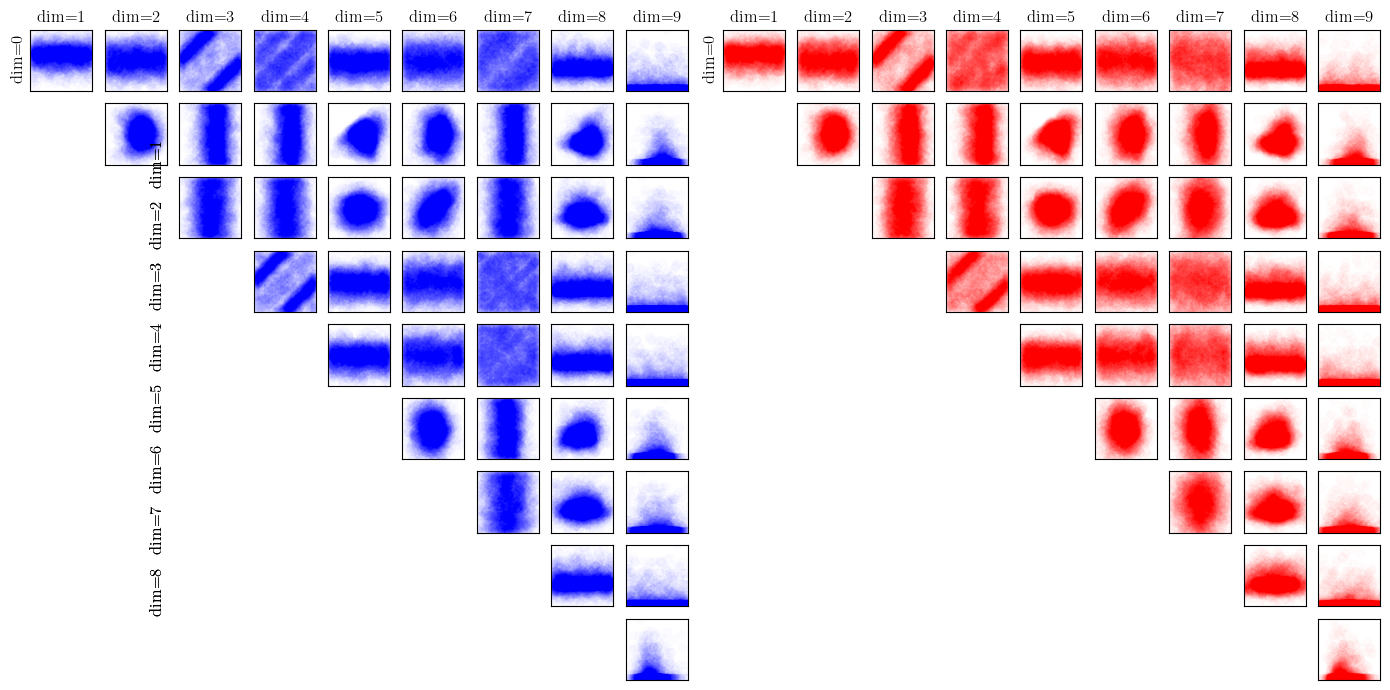

In [56]:
N = 3000
max_dims = 10

dataset = UCI_HEPMASS('../data/')
dims = dataset.dim

idx = np.random.choice(len(dataset), size=N, replace=False)
data = dataset[idx]

which_dims = np.random.choice(dims, size=max_dims, replace=False)
which_dims = sorted(which_dims)
data = data[:, which_dims]

min_vals = data.min(axis=0)
# min_vals = min_vals - np.absolute(min_vals)*0.2
max_vals = data.max(axis=0)
# max_vals = max_vals + np.absolute(max_vals)*0.2
limits = list(zip(min_vals, max_vals))

alpha=0.01

fig = plt.figure(figsize=(14,7))

gs0 = gridspec.GridSpec(1, 2, figure=fig)

# True

gs1 = gridspec.GridSpecFromSubplotSpec(ncols=max_dims-1, nrows=max_dims-1, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(ncols=max_dims-1, nrows=max_dims-1, subplot_spec=gs0[1])

artists1 = plot_pairwise_marginal_scatters(fig, gs1, max_dims, data, limits=limits, alpha=alpha)

# VAE

ds = 'uci_hepmass'
model = 'vae_no_kl_sched'
checkpoint = 'epoch=216-step=133672'
version = '1626686'
vae_path = (f'../logs/{ds}/imputation/{model}/seed_m20220118_d20220118/lightning_logs/'
            f'version_{version}/checkpoints/{checkpoint}.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

vae_samples = vae.sample(N).numpy()
vae_samples = vae_samples[:, which_dims]
    
artists = plot_pairwise_marginal_scatters(fig, gs2, max_dims, vae_samples, limits=limits, alpha=alpha, color='r')

gs0.tight_layout(fig)

### Miniboone

/tmp/ipykernel_3156987/2132564451.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs0.tight_layout(fig)


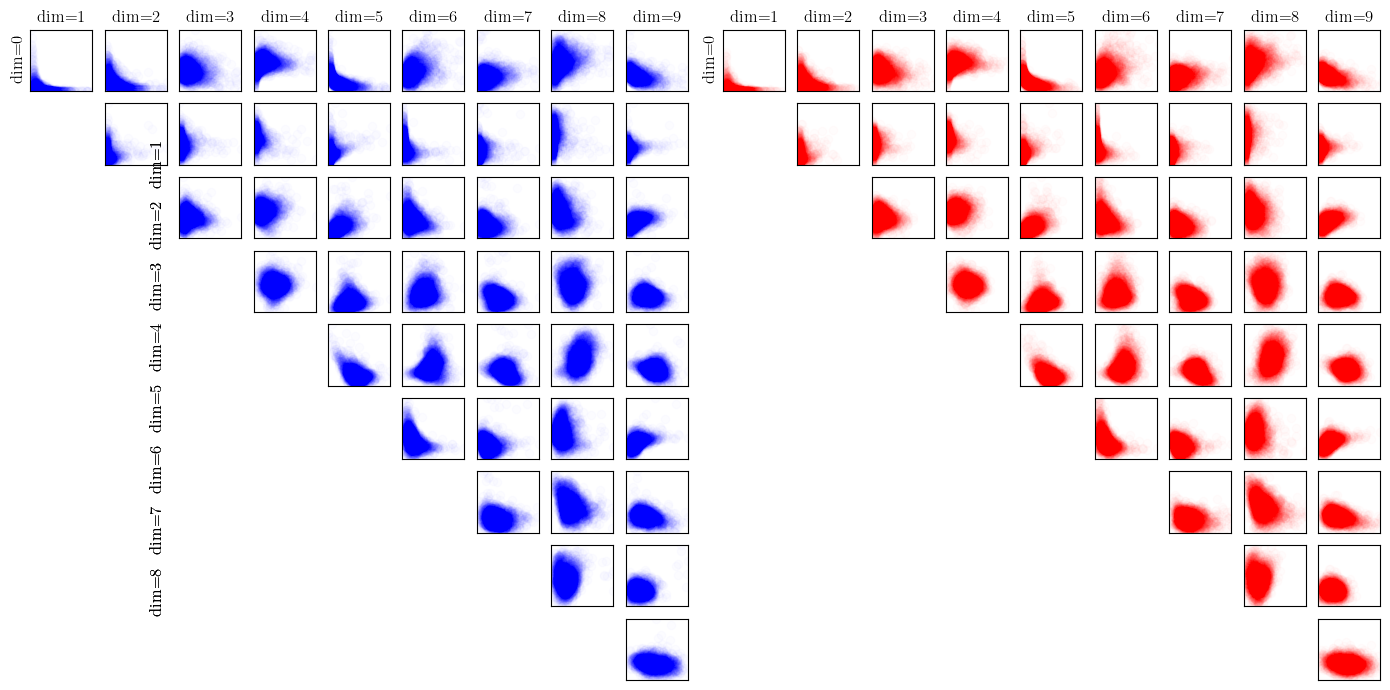

In [57]:
N = 3000
max_dims = 10

dataset = UCI_MINIBOONE('../data/')
dims = dataset.dim

idx = np.random.choice(len(dataset), size=N, replace=False)
data = dataset[idx]

which_dims = np.random.choice(dims, size=max_dims, replace=False)
which_dims = sorted(which_dims)
data = data[:, which_dims]

min_vals = data.min(axis=0)
# min_vals = min_vals - np.absolute(min_vals)*0.2
max_vals = data.max(axis=0)
# max_vals = max_vals + np.absolute(max_vals)*0.2
limits = list(zip(min_vals, max_vals))

alpha=0.01

fig = plt.figure(figsize=(14,7))

gs0 = gridspec.GridSpec(1, 2, figure=fig)

# True

gs1 = gridspec.GridSpecFromSubplotSpec(ncols=max_dims-1, nrows=max_dims-1, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(ncols=max_dims-1, nrows=max_dims-1, subplot_spec=gs0[1])

artists1 = plot_pairwise_marginal_scatters(fig, gs1, max_dims, data, limits=limits, alpha=alpha)

# VAE

ds = 'uci_miniboone'
model = 'vae2_no_kl_sched_drop05'
checkpoint = 'epoch=734-step=21315'
version = '1626898'
vae_path = (f'../logs/{ds}/imputation/{model}/seed_m20220118_d20220118/lightning_logs/'
            f'version_{version}/checkpoints/{checkpoint}.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

vae_samples = vae.sample(N).numpy()
vae_samples = vae_samples[:, which_dims]
    
artists = plot_pairwise_marginal_scatters(fig, gs2, max_dims, vae_samples, limits=limits, alpha=alpha, color='r')

gs0.tight_layout(fig)

### BSDS300

/tmp/ipykernel_3156987/1192488116.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs0.tight_layout(fig)


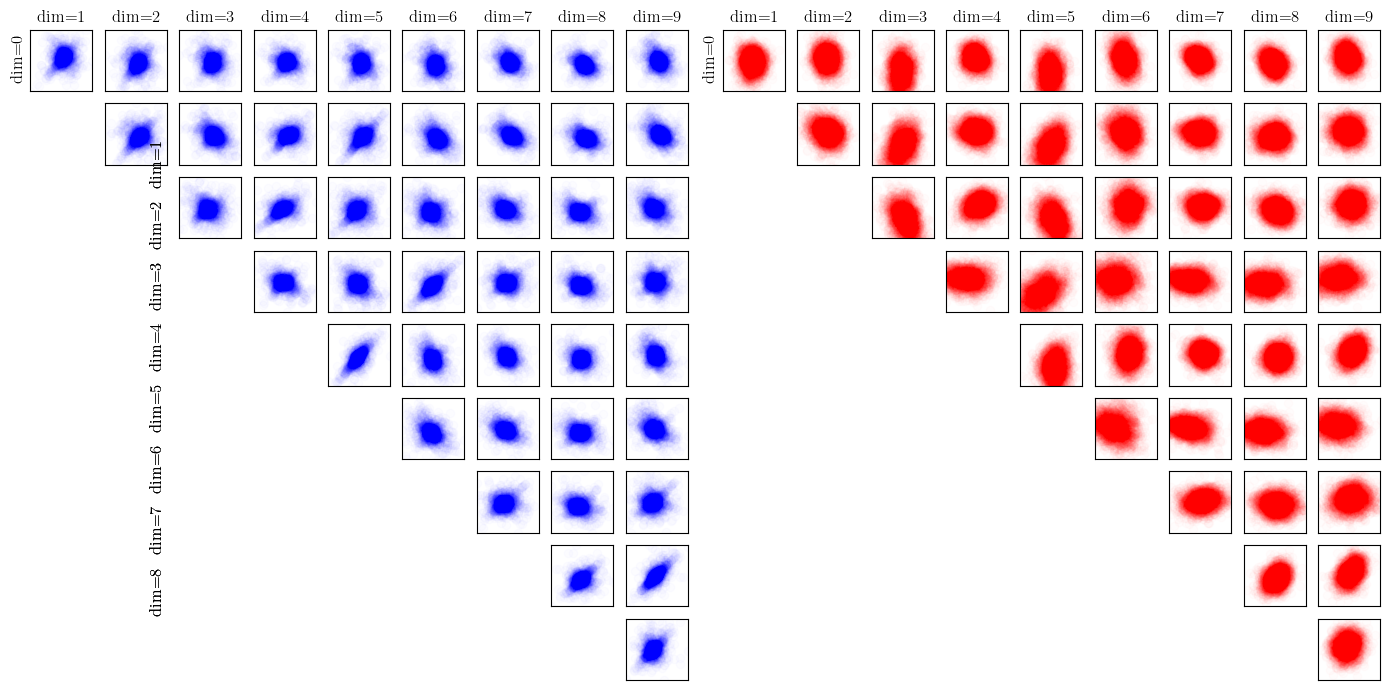

In [59]:
N = 3000
max_dims = 10

dataset = BSDS300('../data/')
dims = dataset.dim

idx = np.random.choice(len(dataset), size=N, replace=False)
data = dataset[idx]

which_dims = np.random.choice(dims, size=max_dims, replace=False)
which_dims = sorted(which_dims)
data = data[:, which_dims]

min_vals = data.min(axis=0)
# min_vals = min_vals - np.absolute(min_vals)*0.2
max_vals = data.max(axis=0)
# max_vals = max_vals + np.absolute(max_vals)*0.2
limits = list(zip(min_vals, max_vals))

alpha=0.01

fig = plt.figure(figsize=(14,7))

gs0 = gridspec.GridSpec(1, 2, figure=fig)

# True

gs1 = gridspec.GridSpecFromSubplotSpec(ncols=max_dims-1, nrows=max_dims-1, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(ncols=max_dims-1, nrows=max_dims-1, subplot_spec=gs0[1])

artists1 = plot_pairwise_marginal_scatters(fig, gs1, max_dims, data, limits=limits, alpha=alpha)

# VAE

ds = 'bsds300'
model = 'vae'
checkpoint = 'epoch=28-step=28333'
version = '1624781'
vae_path = (f'../logs/{ds}/imputation/{model}/seed_m20220118_d20220118/lightning_logs/'
            f'version_{version}/checkpoints/{checkpoint}.ckpt')
vae = VAE.load_from_checkpoint(vae_path)
vae = vae.eval()

vae_samples = vae.sample(N).numpy()
vae_samples = vae_samples[:, which_dims]
    
artists = plot_pairwise_marginal_scatters(fig, gs2, max_dims, vae_samples, limits=limits, alpha=alpha, color='r')

gs0.tight_layout(fig)

## Pointwise metrics vs iteration (computed during sampling)

### Gas

In [12]:
ds = 'uci_gas'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
#     'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

metrics = ['rmse', 'mae', 'latent_wass']
# metric_keys = [
#     f'{m}/q{q}/test'
#     for m in metrics for q in (0.1, 0.25, 0.5, 0.75, 0.9)
# ]
metric_keys = [f'{m}/mean/test' for m in metrics]


pointwise_stats_per_iter = {}

for model, dir_name in models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)
    
for model, dir_name in irwg_resampled_models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)

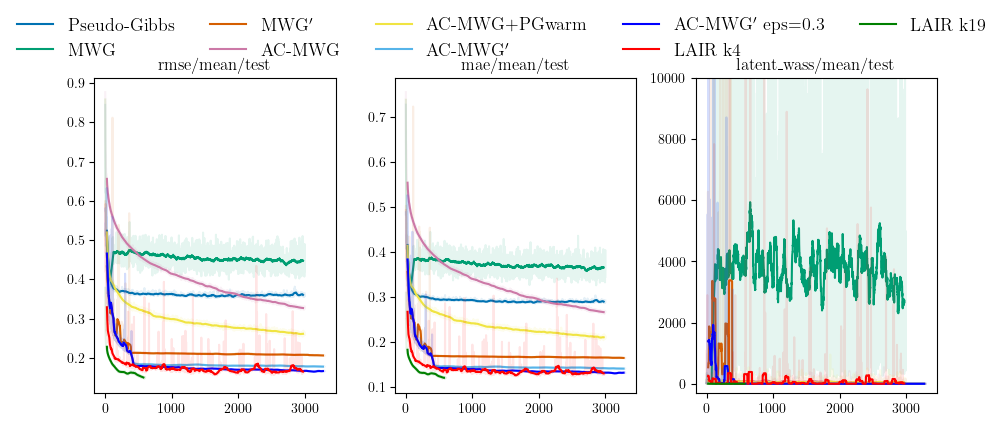

In [13]:
fig, axes = plt.subplots(1, len(metric_keys), figsize=(9, 4))

mv_window=50
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for i, (model, stats) in enumerate(pointwise_stats_per_iter.items()):
    for j, metric_key in enumerate(metric_keys):
        stat = stats[metric_key]
        ma_stat = moving_average(stat, window_size=mv_window)
        axes[j].plot(np.arange(len(stat)), stat, color=colors[i], alpha=0.1)
        axes[j].plot(np.arange(len(stat)-mv_window)+mv_window/2, ma_stat, color=colors[i], label=model)
        
        axes[j].set_title(metric_key)
        
        
axes[2].set_ylim(-300, 10000)
        
fig.tight_layout(rect=(0, 0, 1, 0.97))
axes[0].legend(ncol=5, 
          bbox_to_anchor=(0.5, 0.98), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=13,
          frameon=False)

### Power

In [15]:
ds = 'uci_power'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
#     'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

metrics = ['rmse', 'mae', 'latent_wass']
# metric_keys = [
#     f'{m}/q{q}/test'
#     for m in metrics for q in (0.1, 0.25, 0.5, 0.75, 0.9)
# ]
metric_keys = [f'{m}/mean/test' for m in metrics]


pointwise_stats_per_iter = {}

for model, dir_name in models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)
    
for model, dir_name in irwg_resampled_models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)

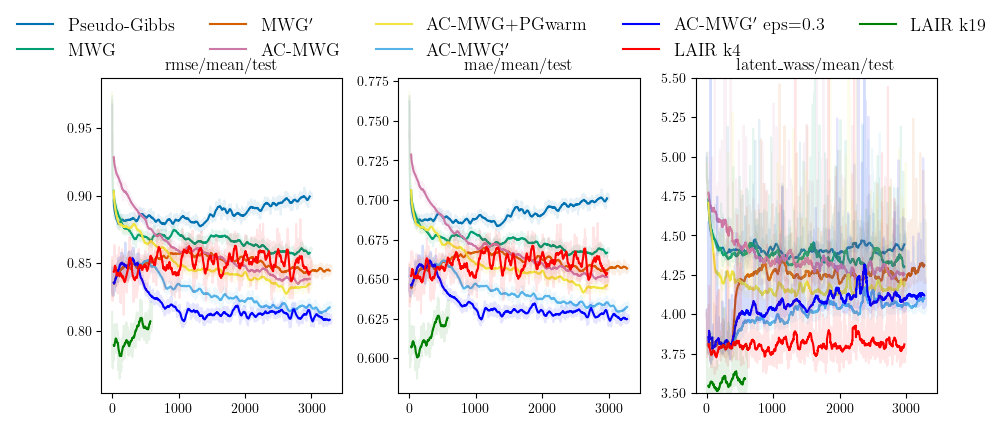

In [16]:
fig, axes = plt.subplots(1, len(metric_keys), figsize=(9, 4))

mv_window=50
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for i, (model, stats) in enumerate(pointwise_stats_per_iter.items()):
    for j, metric_key in enumerate(metric_keys):
        stat = stats[metric_key]
        ma_stat = moving_average(stat, window_size=mv_window)
        axes[j].plot(np.arange(len(stat)), stat, color=colors[i], alpha=0.1)
        axes[j].plot(np.arange(len(stat)-mv_window)+mv_window/2, ma_stat, color=colors[i], label=model)
        
        axes[j].set_title(metric_key)
        
        
axes[2].set_ylim(3.5, 5.5)
        
fig.tight_layout(rect=(0, 0, 1, 0.97))
axes[0].legend(ncol=5, 
          bbox_to_anchor=(0.5, 0.98), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=13,
          frameon=False)

### Hepmass

In [17]:
ds = 'uci_hepmass'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
#     'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

metrics = ['rmse', 'mae', 'latent_wass']
# metric_keys = [
#     f'{m}/q{q}/test'
#     for m in metrics for q in (0.1, 0.25, 0.5, 0.75, 0.9)
# ]
metric_keys = [f'{m}/mean/test' for m in metrics]


pointwise_stats_per_iter = {}

for model, dir_name in models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)
    
for model, dir_name in irwg_resampled_models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)

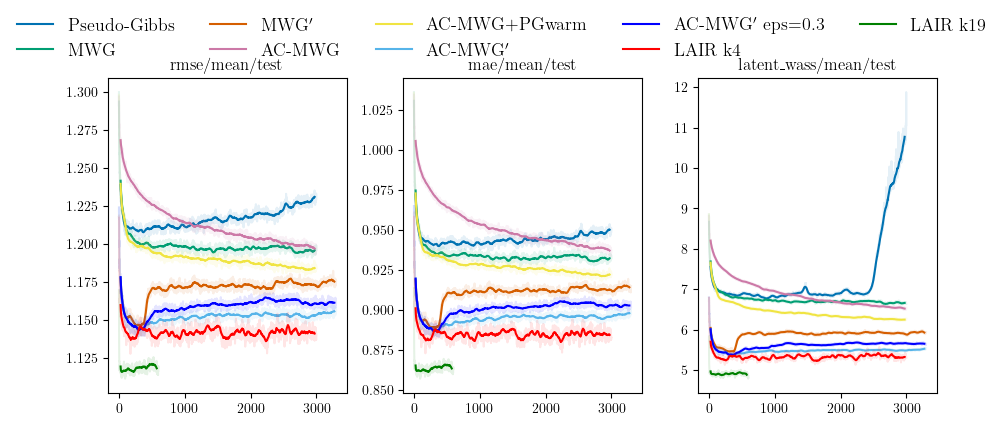

In [18]:
fig, axes = plt.subplots(1, len(metric_keys), figsize=(9, 4))

mv_window=50
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for i, (model, stats) in enumerate(pointwise_stats_per_iter.items()):
    for j, metric_key in enumerate(metric_keys):
        stat = stats[metric_key]
        ma_stat = moving_average(stat, window_size=mv_window)
        axes[j].plot(np.arange(len(stat)), stat, color=colors[i], alpha=0.1)
        axes[j].plot(np.arange(len(stat)-mv_window)+mv_window/2, ma_stat, color=colors[i], label=model)
        
        axes[j].set_title(metric_key)
        
        
# axes[2].set_ylim(3.5, 5.5)
        
fig.tight_layout(rect=(0, 0, 1, 0.97))
axes[0].legend(ncol=5, 
          bbox_to_anchor=(0.5, 0.98), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=13,
          frameon=False)

### Miniboone

In [19]:
ds = 'uci_miniboone'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
#     'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k5': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

metrics = ['rmse', 'mae', 'latent_wass']
# metric_keys = [
#     f'{m}/q{q}/test'
#     for m in metrics for q in (0.1, 0.25, 0.5, 0.75, 0.9)
# ]
metric_keys = [f'{m}/mean/test' for m in metrics]


pointwise_stats_per_iter = {}

for model, dir_name in models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)
    
for model, dir_name in irwg_resampled_models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)

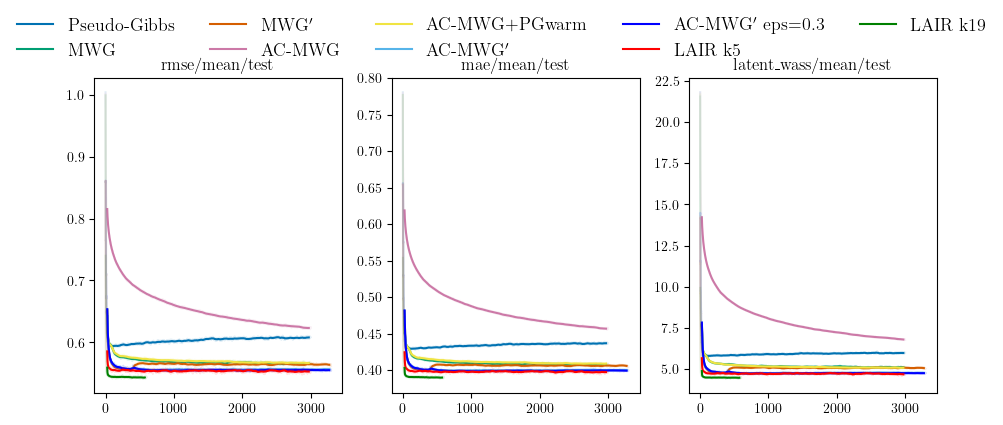

In [20]:
fig, axes = plt.subplots(1, len(metric_keys), figsize=(9, 4))

mv_window=50
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for i, (model, stats) in enumerate(pointwise_stats_per_iter.items()):
    for j, metric_key in enumerate(metric_keys):
        stat = stats[metric_key]
        ma_stat = moving_average(stat, window_size=mv_window)
        axes[j].plot(np.arange(len(stat)), stat, color=colors[i], alpha=0.1)
        axes[j].plot(np.arange(len(stat)-mv_window)+mv_window/2, ma_stat, color=colors[i], label=model)
        
        axes[j].set_title(metric_key)
        
        
# axes[2].set_ylim(3.5, 5.5)
        
fig.tight_layout(rect=(0, 0, 1, 0.97))
axes[0].legend(ncol=5, 
          bbox_to_anchor=(0.5, 0.98), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=13,
          frameon=False)

### BSDS300

In [213]:
ds = 'bsds300'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
#     'Marginal': 'vae_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_k5_pseudo_gibbs',
    'MWG': 'vae_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_k5_mwgm_usehistrestricted_005prior_nowarm',
#     'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k5': 'vae_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
#     'LAIR k19': 'vae_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

metrics = ['rmse', 'mae', 'latent_wass']
# metric_keys = [
#     f'{m}/q{q}/test'
#     for m in metrics for q in (0.1, 0.25, 0.5, 0.75, 0.9)
# ]
metric_keys = [f'{m}/mean/test' for m in metrics]


pointwise_stats_per_iter = {}

for model, dir_name in models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)
    
for model, dir_name in irwg_resampled_models.items():
    path = path_template.format(dir_name)
    pointwise_stats_per_iter[model] = load_stats(path, stat_keys=metric_keys)

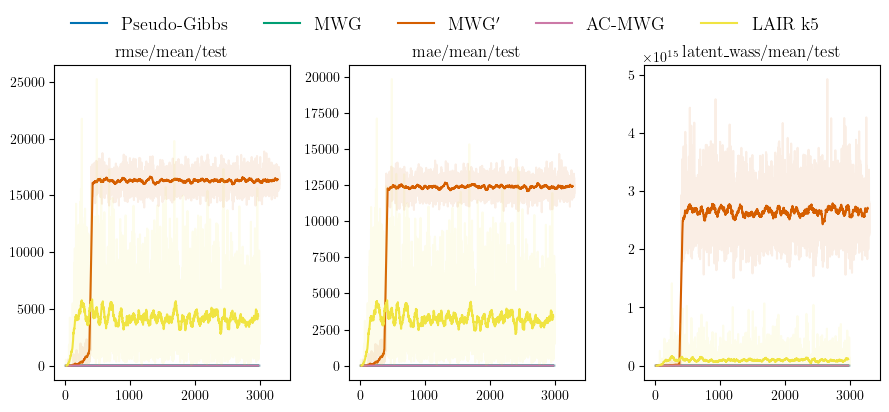

In [214]:
fig, axes = plt.subplots(1, len(metric_keys), figsize=(9, 4))

mv_window=50
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for i, (model, stats) in enumerate(pointwise_stats_per_iter.items()):
    for j, metric_key in enumerate(metric_keys):
        stat = stats[metric_key]
        ma_stat = moving_average(stat, window_size=mv_window)
        axes[j].plot(np.arange(len(stat)), stat, color=colors[i], alpha=0.1)
        axes[j].plot(np.arange(len(stat)-mv_window)+mv_window/2, ma_stat, color=colors[i], label=model)
        
        axes[j].set_title(metric_key)
        
        
# axes[2].set_ylim(3.5, 5.5)
        
fig.tight_layout(rect=(0, 0, 1, 0.97))
axes[0].legend(ncol=5, 
          bbox_to_anchor=(0.5, 0.98), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=13,
          frameon=False)

## Pointwise metrics 

### Gas

In [21]:
ds = 'uci_gas'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

load_last_n_iterations=2500

rmse = {}
mae = {}

out = compute_pointwise_metrics(path_template, models,  
                              load_last_n_iterations=load_last_n_iterations,
                              data_idx_true_dataset=data_idx_true_dataset, 
                              masks_true_dataset=masks_true_dataset, 
                              X_test_true_dataset=X_test_true_dataset, 
                              use_irwg_resampled=False)
rmse = {**rmse, **out['rmse']}
mae = {**mae, **out['mae']}

out = compute_pointwise_metrics(path_template, irwg_resampled_models,  
                              load_last_n_iterations=load_last_n_iterations,
                              data_idx_true_dataset=data_idx_true_dataset, 
                              masks_true_dataset=masks_true_dataset, 
                              X_test_true_dataset=X_test_true_dataset, 
                              use_irwg_resampled=True)
rmse = {**rmse, **out['rmse']}
mae = {**mae, **out['mae']}

Train data size: 852174
Validation data size: 94685
Test data size: 3000


/tmp/ipykernel_30454/2983898362.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_true_dataset = torch.tensor(X_test_true_dataset)


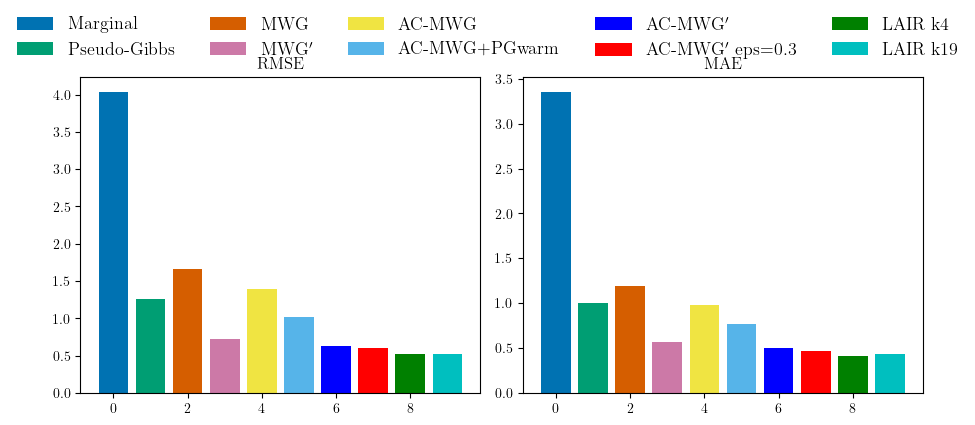

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for i, (model, err) in enumerate(rmse.items()):
    axes[0].bar(x=i, height=err, label=model, color=colors[i])
axes[0].set_title('RMSE')

for i, (model, err) in enumerate(mae.items()):
    axes[1].bar(x=i, height=err, label=model, color=colors[i])
axes[1].set_title('MAE')
        
fig.tight_layout(rect=(0, 0, 1, 0.97))
axes[0].legend(ncol=5, 
          bbox_to_anchor=(0.5, 0.98), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=13,
          frameon=False)

### Power

In [23]:
ds = 'uci_power'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

load_last_n_iterations=2500

rmse = {}
mae = {}

out = compute_pointwise_metrics(path_template, models,  
                              load_last_n_iterations=load_last_n_iterations,
                              data_idx_true_dataset=data_idx_true_dataset, 
                              masks_true_dataset=masks_true_dataset, 
                              X_test_true_dataset=X_test_true_dataset, 
                              use_irwg_resampled=False)
rmse = {**rmse, **out['rmse']}
mae = {**mae, **out['mae']}

out = compute_pointwise_metrics(path_template, irwg_resampled_models,  
                              load_last_n_iterations=load_last_n_iterations,
                              data_idx_true_dataset=data_idx_true_dataset, 
                              masks_true_dataset=masks_true_dataset, 
                              X_test_true_dataset=X_test_true_dataset, 
                              use_irwg_resampled=True)
rmse = {**rmse, **out['rmse']}
mae = {**mae, **out['mae']}

Train data size: 1659917
Validation data size: 184435
Test data size: 3000


/tmp/ipykernel_30454/2983898362.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_true_dataset = torch.tensor(X_test_true_dataset)


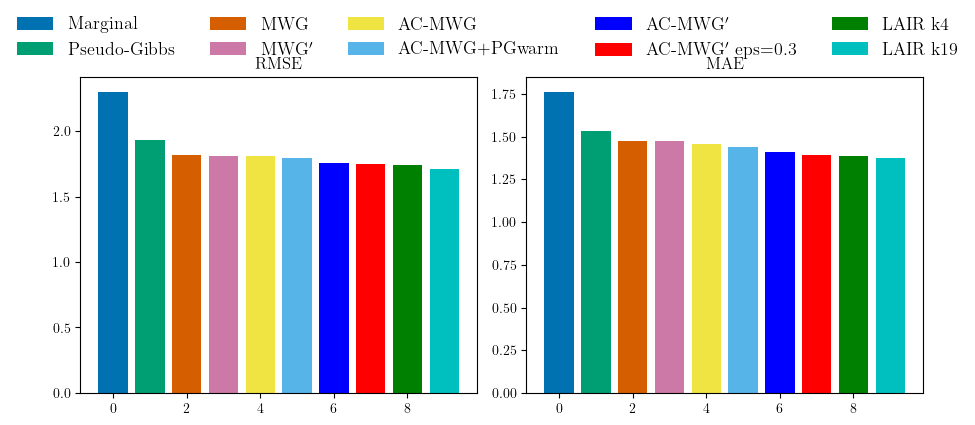

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for i, (model, err) in enumerate(rmse.items()):
    axes[0].bar(x=i, height=err, label=model, color=colors[i])
axes[0].set_title('RMSE')

for i, (model, err) in enumerate(mae.items()):
    axes[1].bar(x=i, height=err, label=model, color=colors[i])
axes[1].set_title('MAE')
        
fig.tight_layout(rect=(0, 0, 1, 0.97))
axes[0].legend(ncol=5, 
          bbox_to_anchor=(0.5, 0.98), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=13,
          frameon=False)

### Hepmass

In [25]:
ds = 'uci_hepmass'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

load_last_n_iterations=2500

rmse = {}
mae = {}

out = compute_pointwise_metrics(path_template, models,  
                              load_last_n_iterations=load_last_n_iterations,
                              data_idx_true_dataset=data_idx_true_dataset, 
                              masks_true_dataset=masks_true_dataset, 
                              X_test_true_dataset=X_test_true_dataset, 
                              use_irwg_resampled=False)
rmse = {**rmse, **out['rmse']}
mae = {**mae, **out['mae']}

out = compute_pointwise_metrics(path_template, irwg_resampled_models,  
                              load_last_n_iterations=load_last_n_iterations,
                              data_idx_true_dataset=data_idx_true_dataset, 
                              masks_true_dataset=masks_true_dataset, 
                              X_test_true_dataset=X_test_true_dataset, 
                              use_irwg_resampled=True)
rmse = {**rmse, **out['rmse']}
mae = {**mae, **out['mae']}

Train data size: 315123
Validation data size: 35013
Test data size: 3000


/tmp/ipykernel_30454/2983898362.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_true_dataset = torch.tensor(X_test_true_dataset)


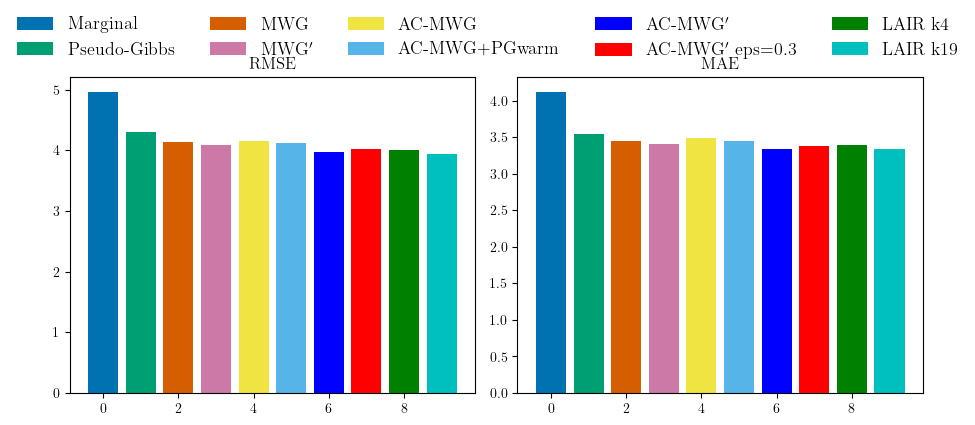

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for i, (model, err) in enumerate(rmse.items()):
    axes[0].bar(x=i, height=err, label=model, color=colors[i])
axes[0].set_title('RMSE')

for i, (model, err) in enumerate(mae.items()):
    axes[1].bar(x=i, height=err, label=model, color=colors[i])
axes[1].set_title('MAE')
        
fig.tight_layout(rect=(0, 0, 1, 0.97))
axes[0].legend(ncol=5, 
          bbox_to_anchor=(0.5, 0.98), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=13,
          frameon=False)

### Miniboone

In [27]:
ds = 'uci_miniboone'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k5': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

load_last_n_iterations=2500

rmse = {}
mae = {}

out = compute_pointwise_metrics(path_template, models,  
                              load_last_n_iterations=load_last_n_iterations,
                              data_idx_true_dataset=data_idx_true_dataset, 
                              masks_true_dataset=masks_true_dataset, 
                              X_test_true_dataset=X_test_true_dataset, 
                              use_irwg_resampled=False)
rmse = {**rmse, **out['rmse']}
mae = {**mae, **out['mae']}

out = compute_pointwise_metrics(path_template, irwg_resampled_models,  
                              load_last_n_iterations=load_last_n_iterations,
                              data_idx_true_dataset=data_idx_true_dataset, 
                              masks_true_dataset=masks_true_dataset, 
                              X_test_true_dataset=X_test_true_dataset, 
                              use_irwg_resampled=True)
rmse = {**rmse, **out['rmse']}
mae = {**mae, **out['mae']}

Train data size: 29556
Validation data size: 3284
Test data size: 3000


/tmp/ipykernel_30454/2983898362.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_true_dataset = torch.tensor(X_test_true_dataset)


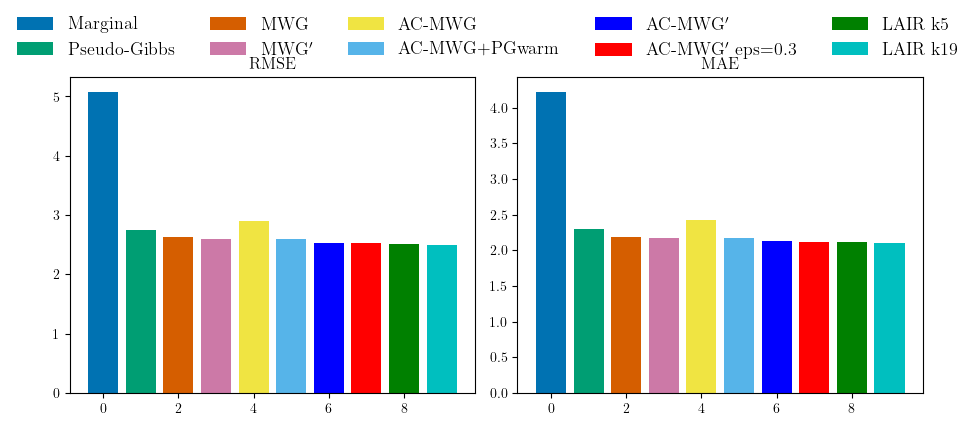

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for i, (model, err) in enumerate(rmse.items()):
    axes[0].bar(x=i, height=err, label=model, color=colors[i])
axes[0].set_title('RMSE')

for i, (model, err) in enumerate(mae.items()):
    axes[1].bar(x=i, height=err, label=model, color=colors[i])
axes[1].set_title('MAE')
        
fig.tight_layout(rect=(0, 0, 1, 0.97))
axes[0].legend(ncol=5, 
          bbox_to_anchor=(0.5, 0.98), 
          bbox_transform=fig.transFigure, 
          loc='center',
          fontsize=13,
          frameon=False)

## Pointwise metrics  w/ Bootstrap

### Gas

In [29]:
ds = 'uci_gas'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

recompute = True
if recompute:
    
    load_last_n_iterations = 2500
    num_bootstrap = 50

    rmse = {}
    mae = {}

    out = compute_pointwise_metrics_bootstrap(path_template, models,  
                                              num_bootstrap=num_bootstrap,
                                  load_last_n_iterations=load_last_n_iterations,
                                  data_idx_true_dataset=data_idx_true_dataset, 
                                  masks_true_dataset=masks_true_dataset, 
                                  X_test_true_dataset=X_test_true_dataset, 
                                  use_irwg_resampled=False)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    out = compute_pointwise_metrics_bootstrap(path_template, irwg_resampled_models,  
                                              num_bootstrap=num_bootstrap,
                                  load_last_n_iterations=load_last_n_iterations,
                                  data_idx_true_dataset=data_idx_true_dataset, 
                                  masks_true_dataset=masks_true_dataset, 
                                  X_test_true_dataset=X_test_true_dataset, 
                                  use_irwg_resampled=True)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    np.savez(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', rmse=rmse, mae=mae)
else:
    errs = np.load(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', allow_pickle=True)
    rmse = errs['rmse'].item()
    mae = errs['mae'].item()

Train data size: 852174
Validation data size: 94685
Test data size: 3000


/tmp/ipykernel_30454/2983898362.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_true_dataset = torch.tensor(X_test_true_dataset)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

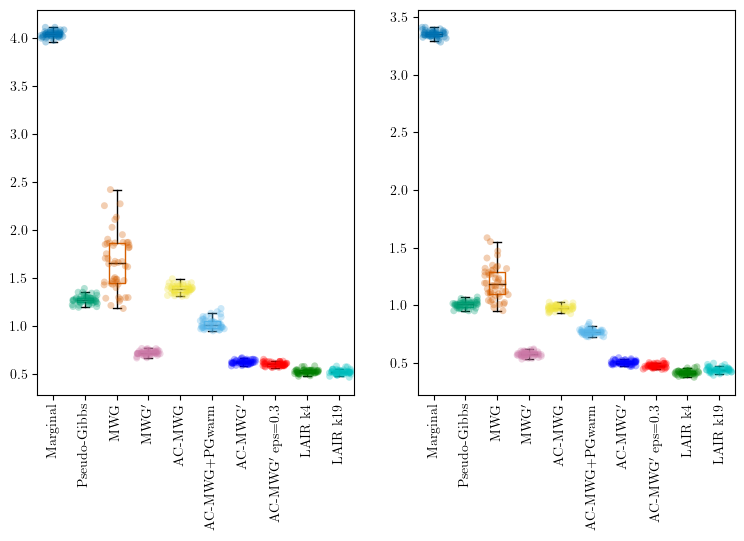

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_rmse = []
all_mae = []
model_labels = []
for j, model in enumerate(rmse.keys()):
    err = rmse[model]
    all_rmse.append(err)
    err = mae[model]
    all_mae.append(err)
    
    model_labels.append(model)

# RMSE
    
bplot = axes[0].boxplot(all_rmse, 
                     positions=np.arange(len(all_rmse)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[0], all_rmse, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})

# MAE

bplot = axes[1].boxplot(all_mae, 
                     positions=np.arange(len(all_mae)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[1], all_mae, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})


axes[0].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
axes[1].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')

### Power

In [31]:
ds = 'uci_power'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

recompute = True
if recompute:
    
    load_last_n_iterations = 2500
    num_bootstrap = 50

    rmse = {}
    mae = {}

    out = compute_pointwise_metrics_bootstrap(path_template, models,  
                                              num_bootstrap=num_bootstrap,
                                  load_last_n_iterations=load_last_n_iterations,
                                  data_idx_true_dataset=data_idx_true_dataset, 
                                  masks_true_dataset=masks_true_dataset, 
                                  X_test_true_dataset=X_test_true_dataset, 
                                  use_irwg_resampled=False)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    out = compute_pointwise_metrics_bootstrap(path_template, irwg_resampled_models,  
                                              num_bootstrap=num_bootstrap,
                                  load_last_n_iterations=load_last_n_iterations,
                                  data_idx_true_dataset=data_idx_true_dataset, 
                                  masks_true_dataset=masks_true_dataset, 
                                  X_test_true_dataset=X_test_true_dataset, 
                                  use_irwg_resampled=True)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    np.savez(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', rmse=rmse, mae=mae)
else:
    errs = np.load(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', allow_pickle=True)
    rmse = errs['rmse'].item()
    mae = errs['mae'].item()

Train data size: 1659917
Validation data size: 184435
Test data size: 3000


/tmp/ipykernel_30454/2983898362.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_true_dataset = torch.tensor(X_test_true_dataset)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

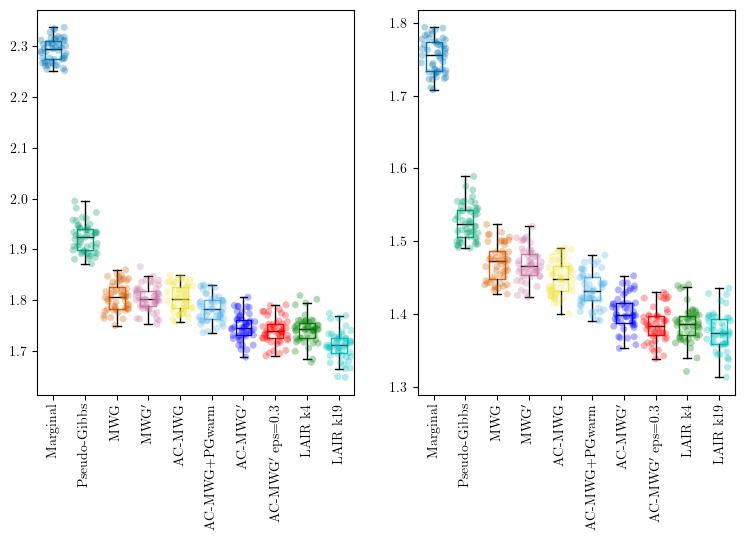

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_rmse = []
all_mae = []
model_labels = []
for j, model in enumerate(rmse.keys()):
    err = rmse[model]
    all_rmse.append(err)
    err = mae[model]
    all_mae.append(err)
    
    model_labels.append(model)

# RMSE
    
bplot = axes[0].boxplot(all_rmse, 
                     positions=np.arange(len(all_rmse)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[0], all_rmse, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})

# MAE

bplot = axes[1].boxplot(all_mae, 
                     positions=np.arange(len(all_mae)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[1], all_mae, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})


axes[0].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
axes[1].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')

### Hepmass

In [33]:
ds = 'uci_hepmass'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

recompute = True
if recompute:
    
    load_last_n_iterations = 2500
    num_bootstrap = 50

    rmse = {}
    mae = {}

    out = compute_pointwise_metrics_bootstrap(path_template, models,  
                                              num_bootstrap=num_bootstrap,
                                  load_last_n_iterations=load_last_n_iterations,
                                  data_idx_true_dataset=data_idx_true_dataset, 
                                  masks_true_dataset=masks_true_dataset, 
                                  X_test_true_dataset=X_test_true_dataset, 
                                  use_irwg_resampled=False)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    out = compute_pointwise_metrics_bootstrap(path_template, irwg_resampled_models,  
                                              num_bootstrap=num_bootstrap,
                                  load_last_n_iterations=load_last_n_iterations,
                                  data_idx_true_dataset=data_idx_true_dataset, 
                                  masks_true_dataset=masks_true_dataset, 
                                  X_test_true_dataset=X_test_true_dataset, 
                                  use_irwg_resampled=True)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    np.savez(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', rmse=rmse, mae=mae)
else:
    errs = np.load(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', allow_pickle=True)
    rmse = errs['rmse'].item()
    mae = errs['mae'].item()

Train data size: 315123
Validation data size: 35013
Test data size: 3000


/tmp/ipykernel_30454/2983898362.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_true_dataset = torch.tensor(X_test_true_dataset)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

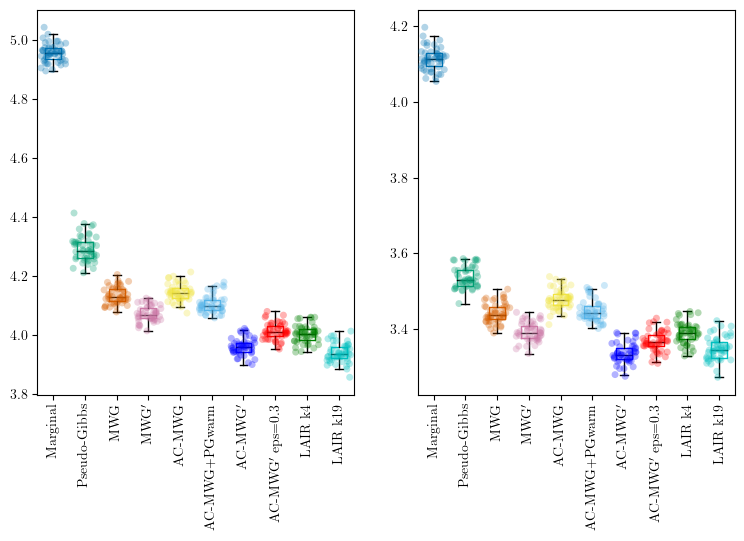

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_rmse = []
all_mae = []
model_labels = []
for j, model in enumerate(rmse.keys()):
    err = rmse[model]
    all_rmse.append(err)
    err = mae[model]
    all_mae.append(err)
    
    model_labels.append(model)

# RMSE
    
bplot = axes[0].boxplot(all_rmse, 
                     positions=np.arange(len(all_rmse)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[0], all_rmse, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})

# MAE

bplot = axes[1].boxplot(all_mae, 
                     positions=np.arange(len(all_mae)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[1], all_mae, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})


axes[0].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
axes[1].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')

### Miniboone

In [151]:
ds = 'uci_miniboone'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

recompute = True
if recompute:
    
    load_last_n_iterations = 2500
    num_bootstrap = 50

    rmse = {}
    mae = {}

    out = compute_pointwise_metrics_bootstrap(path_template, models,  
                                              num_bootstrap=num_bootstrap,
                                  load_last_n_iterations=load_last_n_iterations,
                                  data_idx_true_dataset=data_idx_true_dataset, 
                                  masks_true_dataset=masks_true_dataset, 
                                  X_test_true_dataset=X_test_true_dataset, 
                                  use_irwg_resampled=False)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    out = compute_pointwise_metrics_bootstrap(path_template, irwg_resampled_models,  
                                              num_bootstrap=num_bootstrap,
                                  load_last_n_iterations=load_last_n_iterations,
                                  data_idx_true_dataset=data_idx_true_dataset, 
                                  masks_true_dataset=masks_true_dataset, 
                                  X_test_true_dataset=X_test_true_dataset, 
                                  use_irwg_resampled=True)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    np.savez(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', rmse=rmse, mae=mae)
else:
    errs = np.load(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', allow_pickle=True)
    rmse = errs['rmse'].item()
    mae = errs['mae'].item()

Train data size: 29556
Validation data size: 3284
Test data size: 3000


/tmp/ipykernel_30454/2983898362.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_true_dataset = torch.tensor(X_test_true_dataset)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

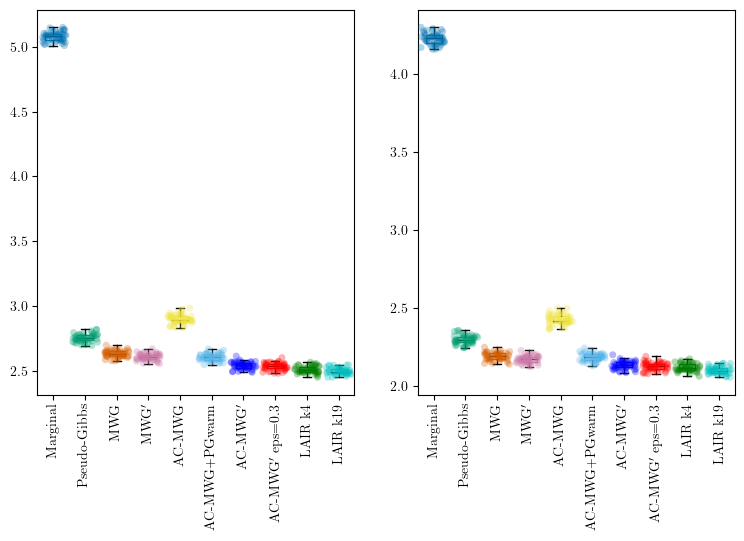

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_rmse = []
all_mae = []
model_labels = []
for j, model in enumerate(rmse.keys()):
    err = rmse[model]
    all_rmse.append(err)
    err = mae[model]
    all_mae.append(err)
    
    model_labels.append(model)

# RMSE
    
bplot = axes[0].boxplot(all_rmse, 
                     positions=np.arange(len(all_rmse)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[0], all_rmse, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})

# MAE

bplot = axes[1].boxplot(all_mae, 
                     positions=np.arange(len(all_mae)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[1], all_mae, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})


axes[0].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
axes[1].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')

## Sinkhorn divergence (per-imputation)

### Gas

In [37]:
ds = 'uci_gas'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']


Train data size: 852174
Validation data size: 94685
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

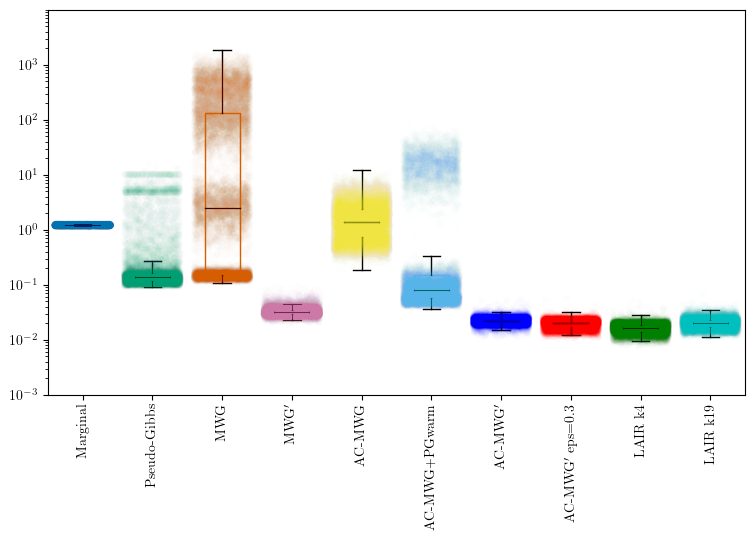

In [38]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Power

In [40]:
ds = 'uci_power'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']


Train data size: 1659917
Validation data size: 184435
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

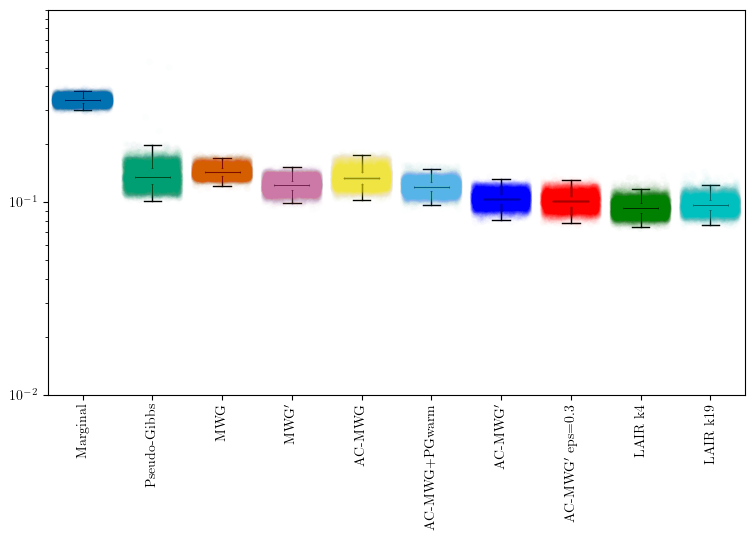

In [41]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Hepmass

In [76]:
ds = 'uci_hepmass'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']


Train data size: 315123
Validation data size: 35013
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

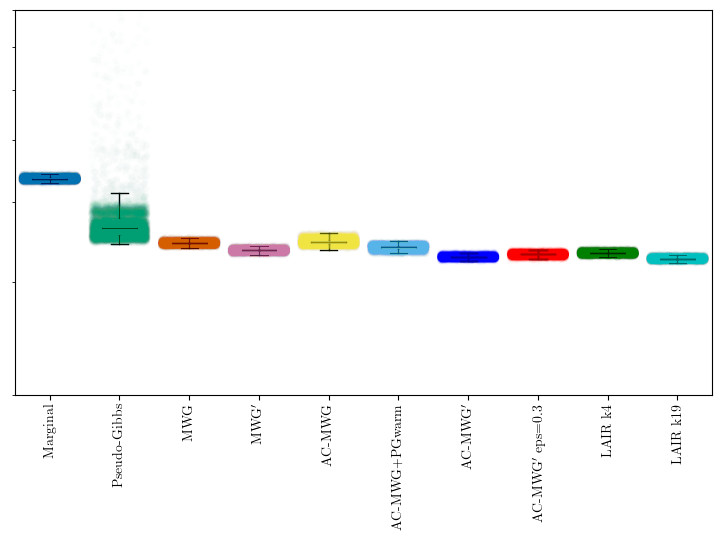

In [77]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

axes.set_ylim(np.log10(1e1*0.2), np.log10(1e1*0.8))

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Miniboone

In [84]:
ds = 'uci_miniboone'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']


Train data size: 29556
Validation data size: 3284
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

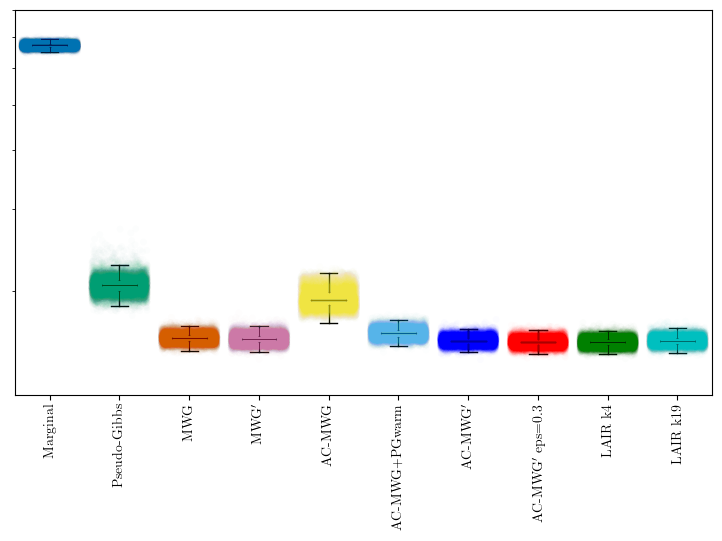

In [85]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

axes.set_ylim(np.log10(1e1*0.12), np.log10(1e1*0.8))

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

## EnergyMMD divergence (per-imputation)

### Gas

In [60]:
ds = 'uci_gas'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

energymmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')
    
    scores = np.load(path)
    energymmd_per_imputation[model] = scores['energymmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    energymmd_per_imputation[model] = scores['energymmd_per_imputation']


Train data size: 852174
Validation data size: 94685
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

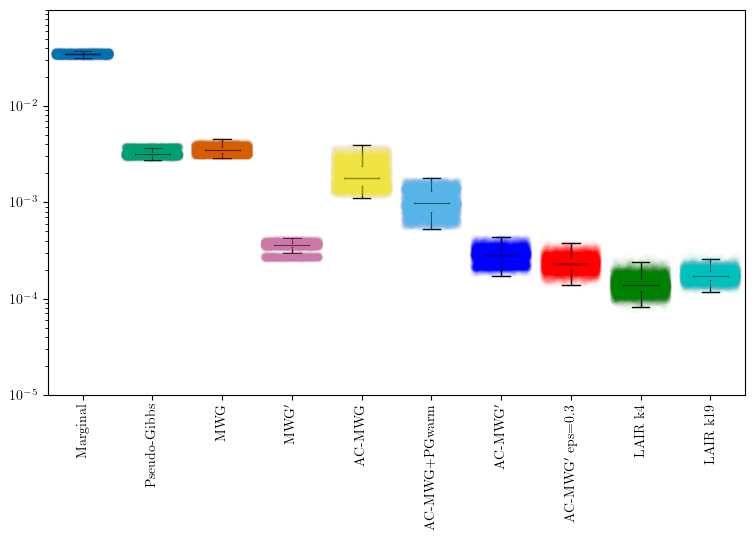

In [61]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Power

In [62]:
ds = 'uci_power'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

energymmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')
    
    scores = np.load(path)
    energymmd_per_imputation[model] = scores['energymmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    energymmd_per_imputation[model] = scores['energymmd_per_imputation']


Train data size: 1659917
Validation data size: 184435
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

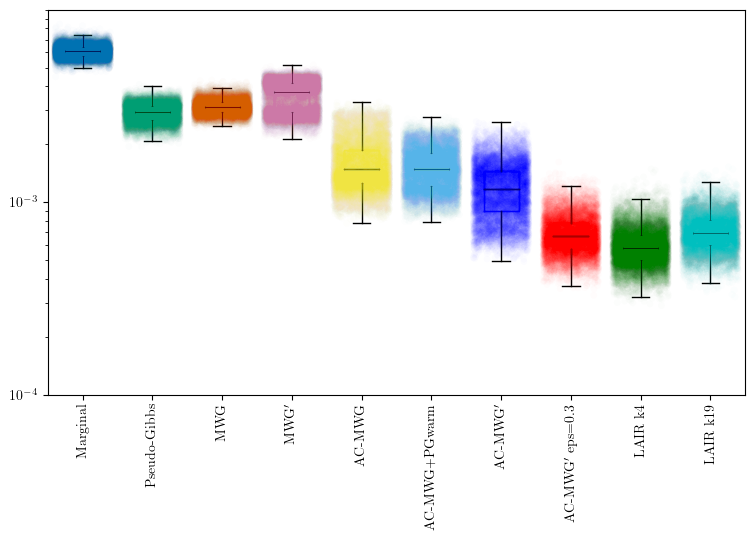

In [63]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Hepmass

In [82]:
ds = 'uci_hepmass'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

energymmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')
    
    scores = np.load(path)
    energymmd_per_imputation[model] = scores['energymmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    energymmd_per_imputation[model] = scores['energymmd_per_imputation']


Train data size: 315123
Validation data size: 35013
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

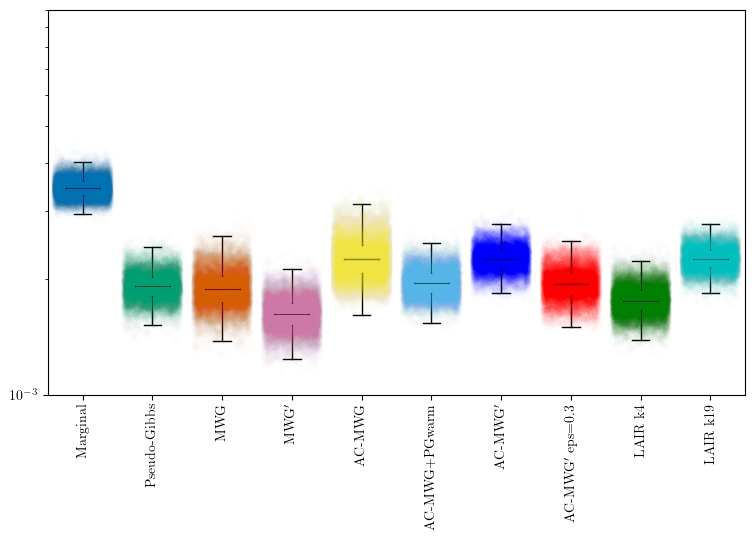

In [83]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Miniboone

In [86]:
ds = 'uci_miniboone'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

energymmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')
    
    scores = np.load(path)
    energymmd_per_imputation[model] = scores['energymmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    energymmd_per_imputation[model] = scores['energymmd_per_imputation']


Train data size: 29556
Validation data size: 3284
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

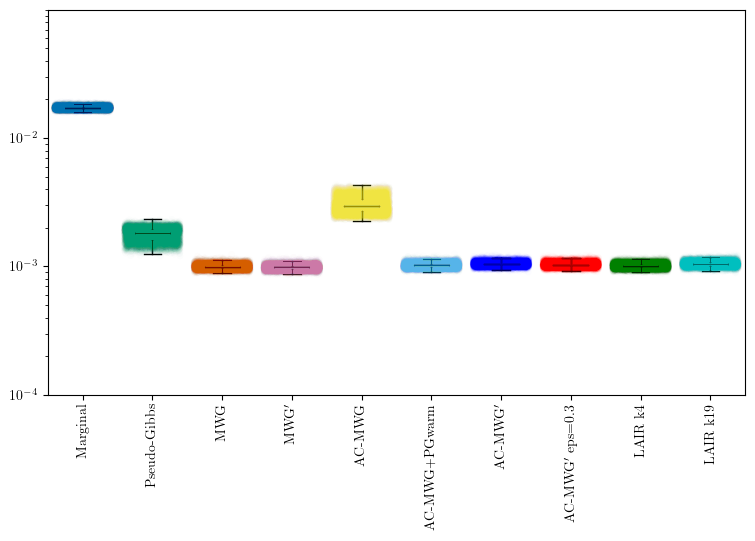

In [87]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

## GaussianMMD divergence (per-imputation)

### Gas

In [65]:
ds = 'uci_gas'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')
    
    scores = np.load(path)
    gaussianmmd_per_imputation[model] = scores['gaussianmmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    gaussianmmd_per_imputation[model] = scores['gaussianmmd_per_imputation']


Train data size: 852174
Validation data size: 94685
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

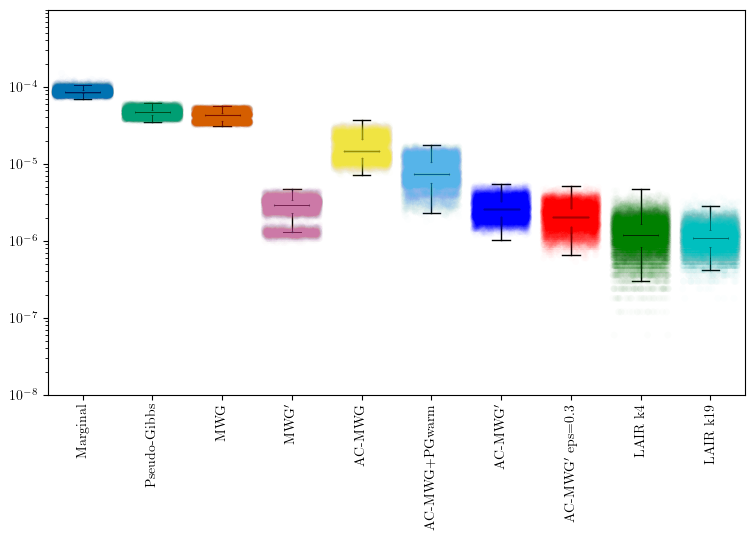

In [66]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Power

In [67]:
ds = 'uci_power'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')
    
    scores = np.load(path)
    gaussianmmd_per_imputation[model] = scores['gaussianmmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    gaussianmmd_per_imputation[model] = scores['gaussianmmd_per_imputation']


Train data size: 1659917
Validation data size: 184435
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

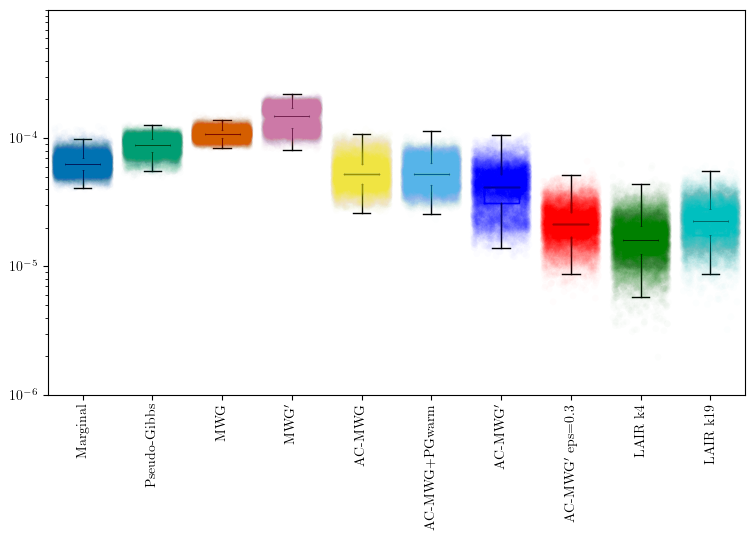

In [68]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Hepmass

In [78]:
ds = 'uci_hepmass'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')
    
    scores = np.load(path)
    gaussianmmd_per_imputation[model] = scores['gaussianmmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    gaussianmmd_per_imputation[model] = scores['gaussianmmd_per_imputation']


Train data size: 315123
Validation data size: 35013
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

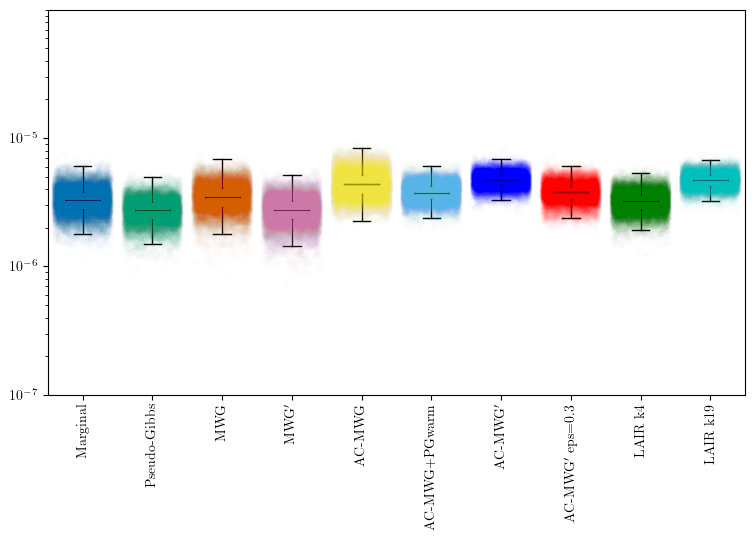

In [79]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Miniboone

In [88]:
ds = 'uci_miniboone'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')
    
    scores = np.load(path)
    gaussianmmd_per_imputation[model] = scores['gaussianmmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    gaussianmmd_per_imputation[model] = scores['gaussianmmd_per_imputation']


Train data size: 29556
Validation data size: 3284
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

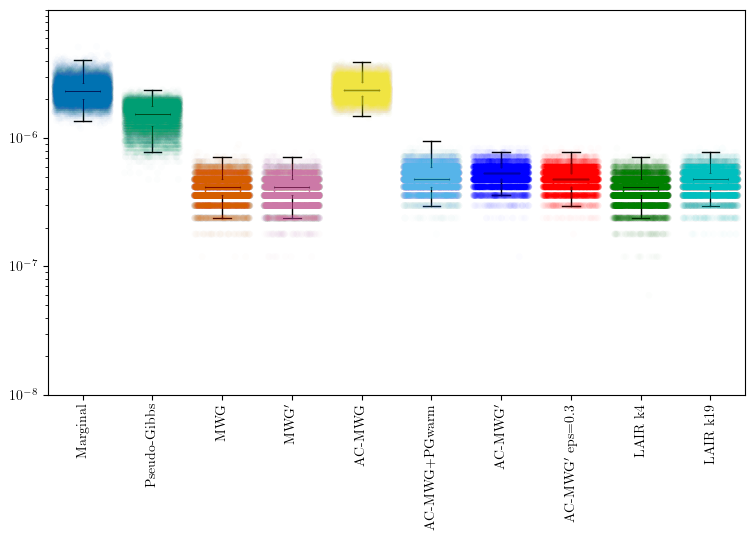

In [89]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

## LaplacianMMD divergence (per-imputation)

### Gas

In [71]:
ds = 'uci_gas'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')
    
    scores = np.load(path)
    laplacianmmd_per_imputation[model] = scores['laplacianmmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    laplacianmmd_per_imputation[model] = scores['laplacianmmd_per_imputation']


Train data size: 852174
Validation data size: 94685
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

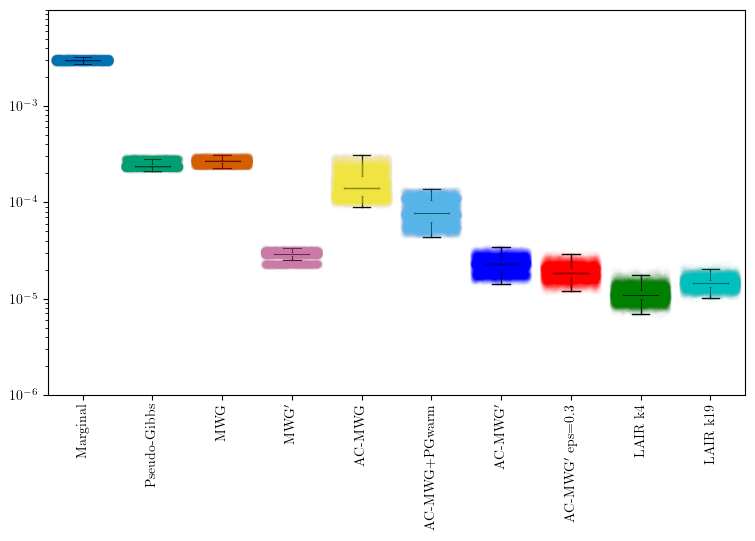

In [72]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Power

In [73]:
ds = 'uci_power'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')
    
    scores = np.load(path)
    laplacianmmd_per_imputation[model] = scores['laplacianmmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    laplacianmmd_per_imputation[model] = scores['laplacianmmd_per_imputation']


Train data size: 1659917
Validation data size: 184435
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

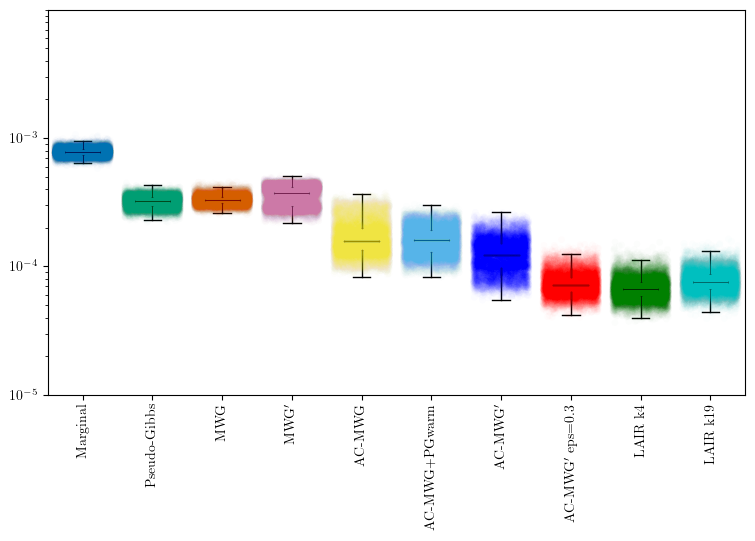

In [74]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Hepmass

In [80]:
ds = 'uci_hepmass'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')
    
    scores = np.load(path)
    laplacianmmd_per_imputation[model] = scores['laplacianmmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    laplacianmmd_per_imputation[model] = scores['laplacianmmd_per_imputation']


Train data size: 315123
Validation data size: 35013
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

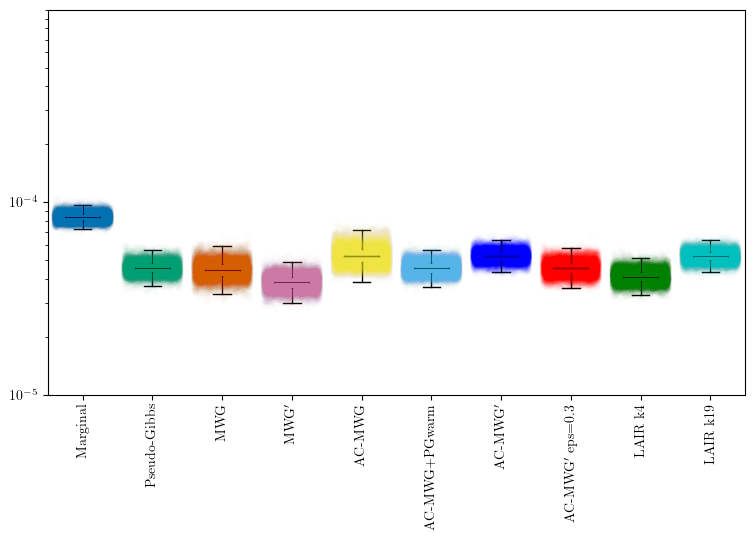

In [81]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Miniboone

In [90]:
ds = 'uci_miniboone'
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
                              num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')
    
    scores = np.load(path)
    laplacianmmd_per_imputation[model] = scores['laplacianmmd_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    laplacianmmd_per_imputation[model] = scores['laplacianmmd_per_imputation']


Train data size: 29556
Validation data size: 3284
Test data size: 3000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

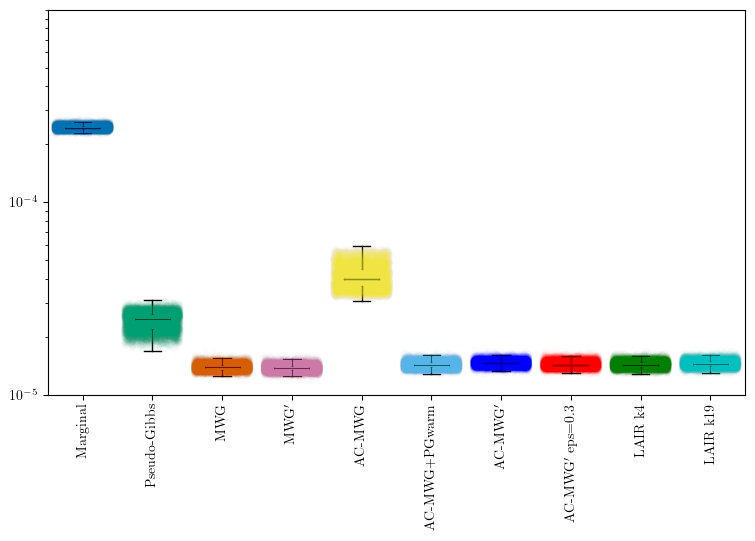

In [91]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.01})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

## *NOT* Paper figure Pointwise RMSE and Sinkhorn

In [179]:
all_ds_rmse = {}
all_ds_mae = {}
all_ds_sinkhorn = {}

In [180]:
## GAS

ds = 'uci_gas'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
all_ds_sinkhorn[ds] = sinkhorn_per_imputation

In [181]:
## Power

ds = 'uci_power'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
all_ds_sinkhorn[ds] = sinkhorn_per_imputation

In [182]:
## Hepmass

ds = 'uci_hepmass'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
all_ds_sinkhorn[ds] = sinkhorn_per_imputation

In [183]:
## Miniboone

ds = 'uci_miniboone'
path_template = f'../logs/{ds}/imputation/sampling_u50/{{}}/seed_m20220118_d20220118/lightning_logs'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-bootstrap/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences/{{}}/seed_m20220118_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
for model, model_path in irwg_resampled_models.items():
    path = path_template.format(model_path)
    path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')
    
    scores = np.load(path)
    sinkhorn_per_imputation[model] = scores['sinkhorn_per_imputation']
    
all_ds_sinkhorn[ds] = sinkhorn_per_imputation

### Filter and map

In [184]:
filter_and_map = {
    'Marginal': 'Marginal',
    'Pseudo-Gibbs': 'Pseudo-Gibbs',
    'MWG$\'$': 'MWG$\'$',
    'AC-MWG$\'$': 'AC-MWG$\'$',
    'LAIR k4': 'LAIR'
}

for ds in all_ds_sinkhorn.keys():
    all_ds_sinkhorn[ds] = {filter_and_map[m]: s for m, s in all_ds_sinkhorn[ds].items() if m in filter_and_map}
    all_ds_rmse[ds] = {filter_and_map[m]: s for m, s in all_ds_rmse[ds].items() if m in filter_and_map}
    all_ds_mae[ds] = {filter_and_map[m]: s for m, s in all_ds_mae[ds].items() if m in filter_and_map}

### Scatter + box plot

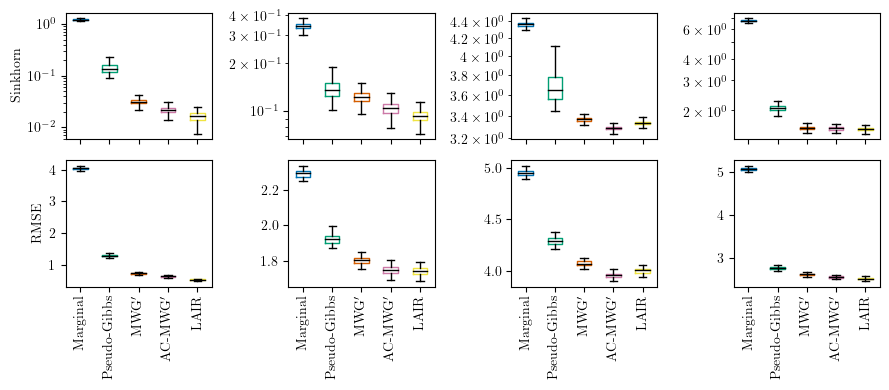

In [210]:
plot_log=False

fig, axes = plt.subplots(2, 4, figsize=(9, 4), sharex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

## Sinkhorn

for d, ds in enumerate(all_ds_sinkhorn.keys()):
    all_sinkhorn_per_imputation = []
    model_labels = []
    for j, model in enumerate(all_ds_sinkhorn[ds].keys()):
        score = all_ds_sinkhorn[ds][model]
        all_sinkhorn_per_imputation.append(score)

        model_labels.append(model)

    bplot_data = all_sinkhorn_per_imputation
    if plot_log:
        bplot_data = [np.log10(x) for x in bplot_data]

    bplot = axes[0, d].boxplot(bplot_data, 
                         positions=np.arange(len(all_sinkhorn_per_imputation)),
                         labels=model_labels, showfliers=False,
                         notch=False)


    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

#     plot_custom_stripplot(axes[0, d], all_sinkhorn_per_imputation, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=plot_log,
#                           stripplot_kw={'alpha': 0.01})
    
    if plot_log:
        axes[0, d].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = axes[0, d].get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        axes[0, d].yaxis.set_ticks(tick_range)
        axes[0, d].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    

    axes[0, d].set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
    plt.setp(axes[0, d].get_xticklabels(), rotation=90, ha='center')
    
## RMSE    
for d, ds in enumerate(all_ds_rmse.keys()):

    all_rmse = []
    model_labels = []
    for j, model in enumerate(all_ds_rmse[ds].keys()):
        err = all_ds_rmse[ds][model]
        all_rmse.append(err)

        model_labels.append(model)

    # RMSE

    bplot = axes[1, d].boxplot(all_rmse, 
                         positions=np.arange(len(all_rmse)),
                         labels=model_labels, showfliers=False,
                         notch=False)

    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

#     plot_custom_stripplot(axes[1, d], all_rmse, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=False,
#                           stripplot_kw={'alpha': 0.3})


    axes[1, d].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
    plt.setp(axes[1, d].get_xticklabels(), rotation=90, ha='center')

axes[0, 0].set_ylabel('Sinkhorn')
axes[1, 0].set_ylabel('RMSE')

axes[0,0].set_yscale('log', base=10)
axes[0,1].set_yscale('log', base=10)
axes[0,2].set_yscale('log', base=10)
axes[0,3].set_yscale('log', base=10)

fig.tight_layout()

### Mean + error bars

Text(0.5, 1.0, 'RMSE')

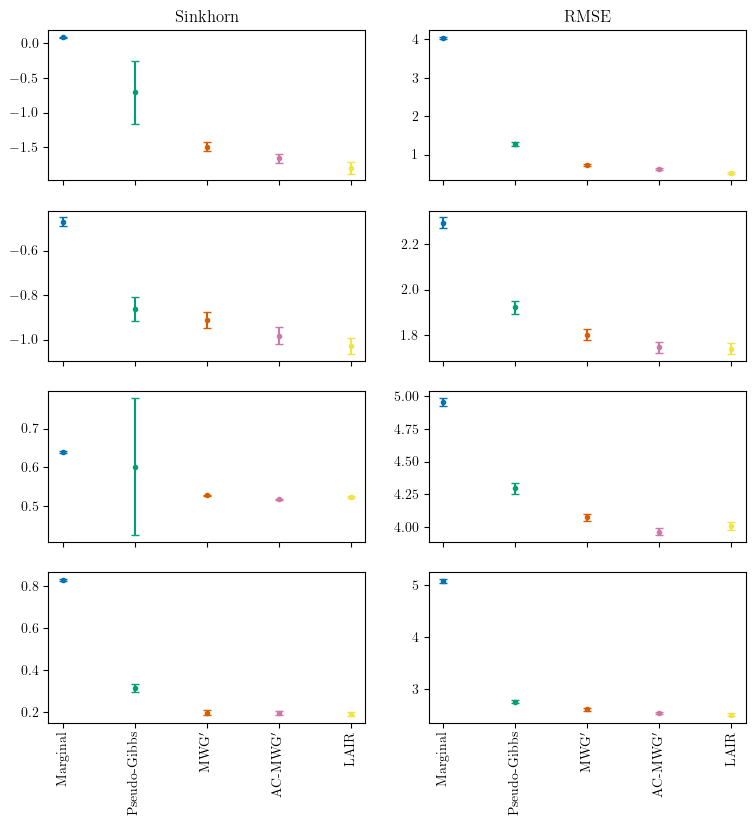

In [224]:
plot_log=True

fig, axes = plt.subplots(4, 2, figsize=(9, 9), sharex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

## Sinkhorn

for d, ds in enumerate(all_ds_sinkhorn.keys()):
    all_sinkhorn_per_imputation = []
    model_labels = []
    for j, model in enumerate(all_ds_sinkhorn[ds].keys()):
        score = all_ds_sinkhorn[ds][model]
        all_sinkhorn_per_imputation.append(score)

        model_labels.append(model)

    bplot_data = all_sinkhorn_per_imputation
    if plot_log:
        bplot_data = [np.log10(x) for x in bplot_data]
    bplot_data_mean = [x.mean() for x in bplot_data]
#     bplot_data_stderr = [x.std(ddof=1)/(len(x)**0.5) for x in bplot_data]
    bplot_data_std = [x.std(ddof=1) for x in bplot_data]
    
    for i in range(len(model_labels)):
#         axes[d,0].errorbar([i], [bplot_data_mean[i]], yerr=[bplot_data_stderr[i]], color=colors[i],
#                           capsize=3, marker='.')
        axes[d,0].errorbar([i], [bplot_data_mean[i]], yerr=[bplot_data_std[i]], color=colors[i],
                          capsize=3, marker='.')
    

    axes[d, 0].set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
    plt.setp(axes[d, 0].get_xticklabels(), rotation=90, ha='center')
    
## RMSE    
for d, ds in enumerate(all_ds_rmse.keys()):

    all_rmse = []
    model_labels = []
    for j, model in enumerate(all_ds_rmse[ds].keys()):
        err = all_ds_rmse[ds][model]
        all_rmse.append(err)

        model_labels.append(model)

    # RMSE
    bplot_data_mean = [np.stack(x, axis=0).mean() for x in all_rmse]
    bplot_data_std = [np.stack(x, axis=0).std(ddof=1) for x in all_rmse]


    for i in range(len(model_labels)):
        axes[d,1].errorbar([i], [bplot_data_mean[i]], yerr=[bplot_data_std[i]], color=colors[i],
                          capsize=3, marker='.')



    axes[d, 1].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
    plt.setp(axes[d, 1].get_xticklabels(), rotation=90, ha='center')

axes[0, 0].set_title('Sinkhorn')
axes[0, 1].set_title('RMSE')

## (Multi-seed) Sinkhorn divergence (per-imputation)

### Gas 

In [113]:
ds = 'uci_gas'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

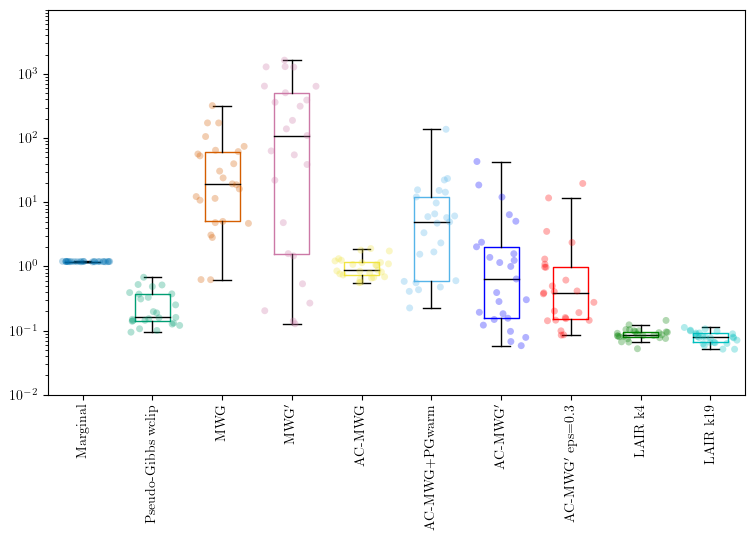

In [114]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

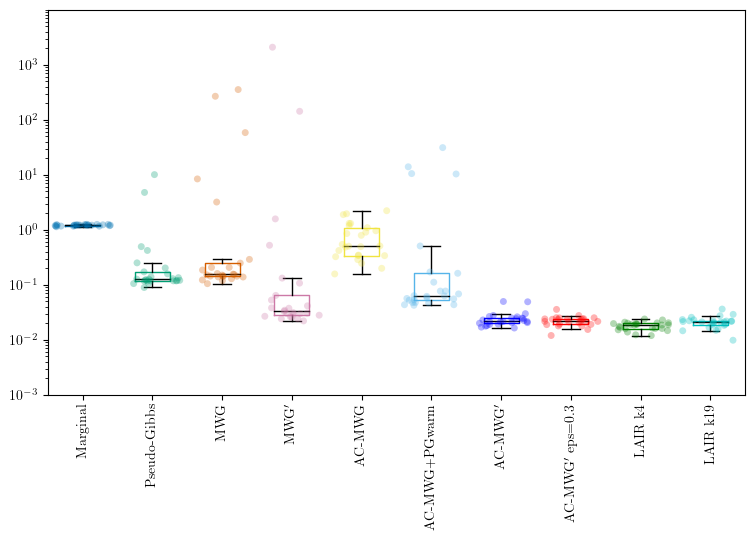

In [28]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Power 

In [115]:
ds = 'uci_power'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

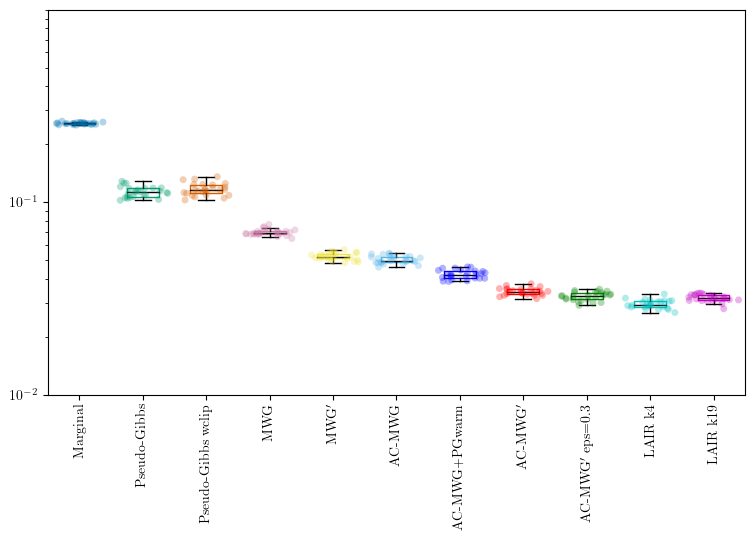

In [116]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

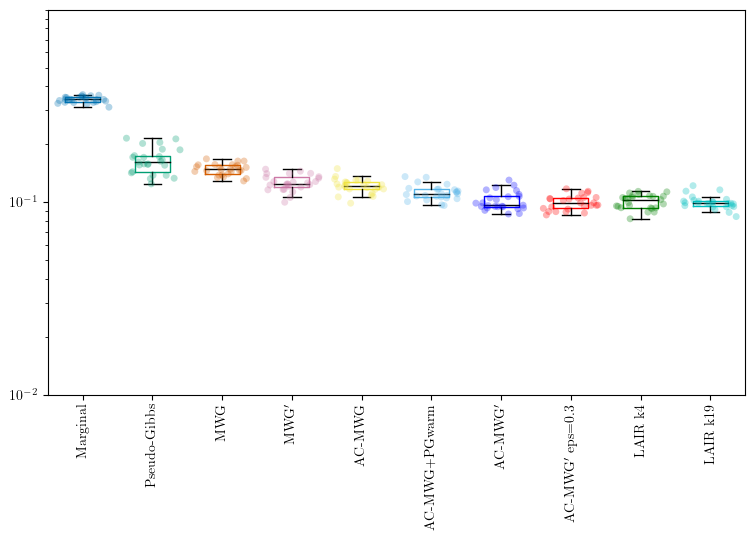

In [40]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Hepmass 

In [117]:
ds = 'uci_hepmass'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')

        try:
            scores = np.load(path)
            all_scores.append(scores['sinkhorn_per_imputation'])
        except:
            # Some Pseudo-Gibbs imps are really bad and sinkhorn computation fails, so ignore them
            continue
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

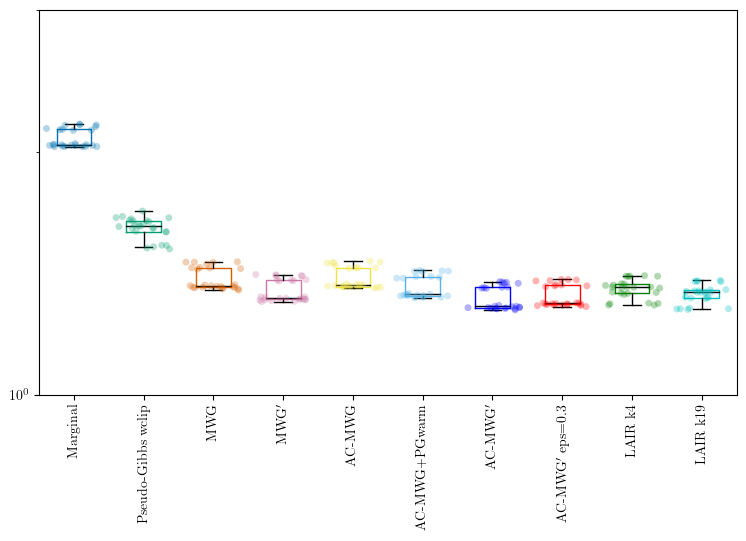

In [118]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(np.log10(1e1*0.3), np.log10(1e1*0.5))
axes.set_ylim(np.log10(1e0), np.log10(1e1*0.3))

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

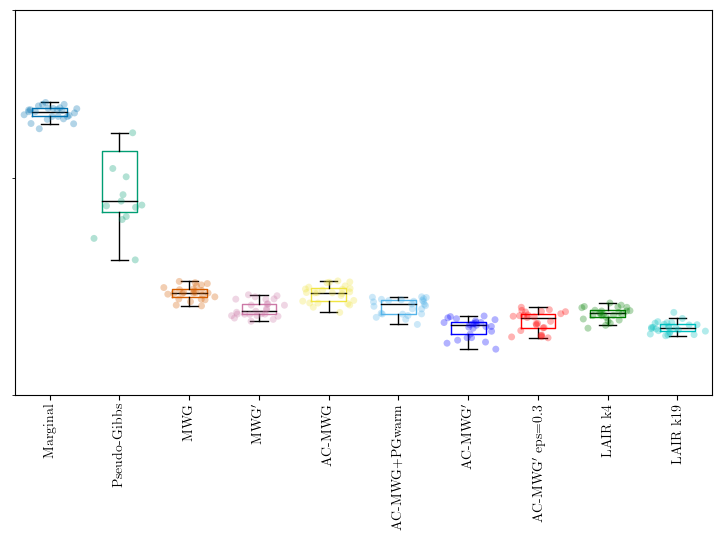

In [65]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

axes.set_ylim(np.log10(1e1*0.3), np.log10(1e1*0.5))

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Miniboone

In [119]:
ds = 'uci_miniboone'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs_wclip',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')

#         try:
        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
#         except:
#             # Some Pseudo-Gibbs imps are really bad and sinkhorn computation fails, so ignore them
#             continue
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

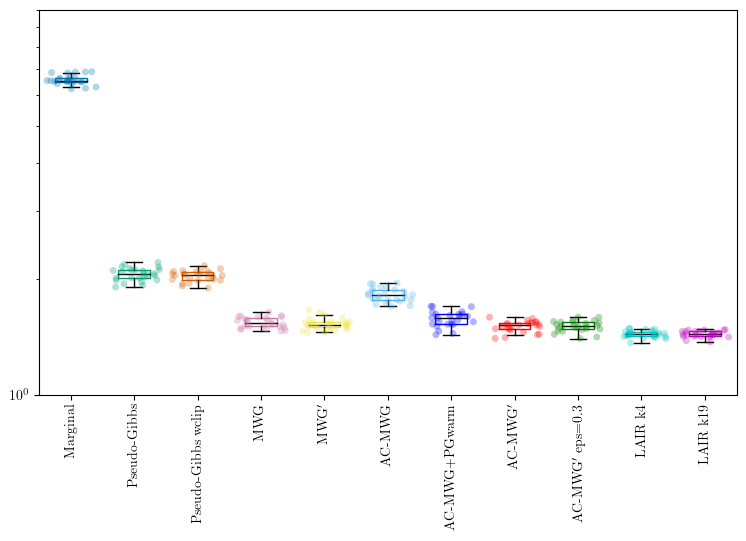

In [120]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})


axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

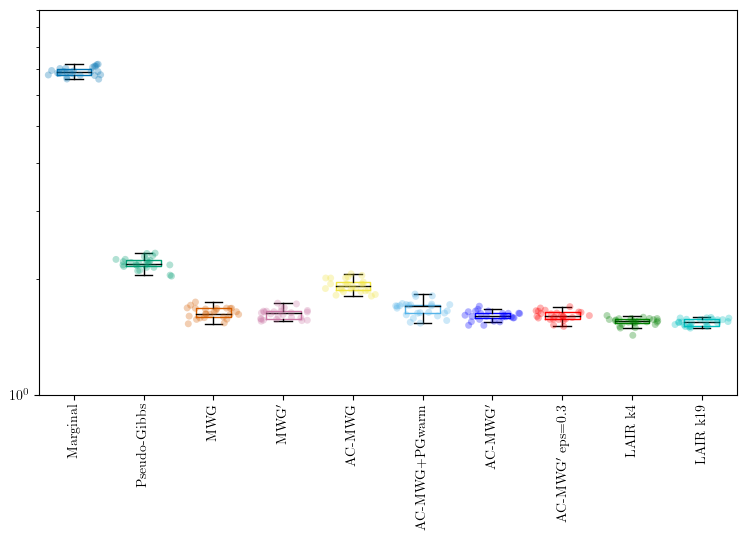

In [77]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})


axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### BSDS300

In [192]:
ds = 'bsds300'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')

#         try:
        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
#         except:
#             # Some Pseudo-Gibbs imps are really bad and sinkhorn computation fails, so ignore them
#             continue
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

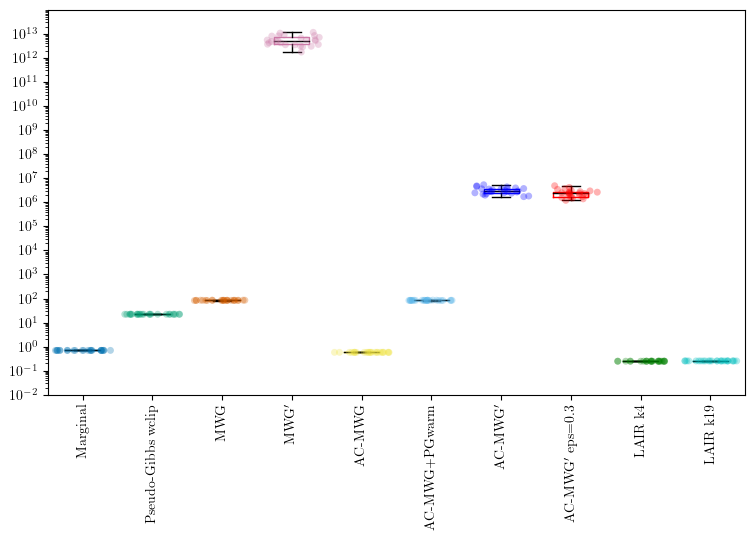

In [193]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})


axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

## (Multi-seed) Sinkhorn divergence p=1 (per-imputation)

### Gas 

In [121]:
ds = 'uci_gas'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

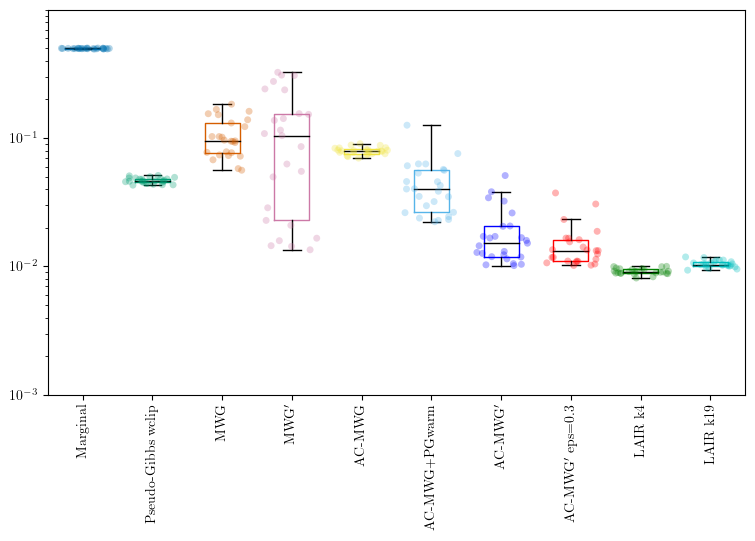

In [122]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Power 

In [123]:
ds = 'uci_power'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

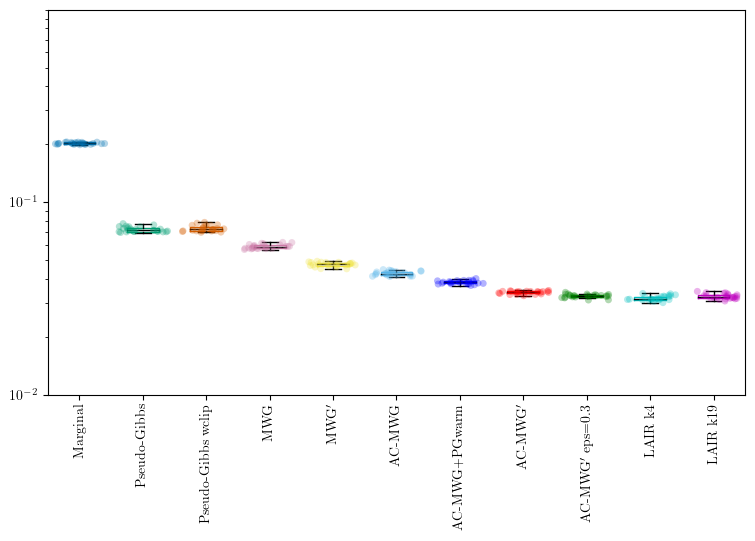

In [124]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Hepmass 

In [125]:
ds = 'uci_hepmass'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1.npz')

        try:
            scores = np.load(path)
            all_scores.append(scores['sinkhorn_per_imputation'])
        except:
            # Some Pseudo-Gibbs imps are really bad and sinkhorn computation fails, so ignore them
            continue
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

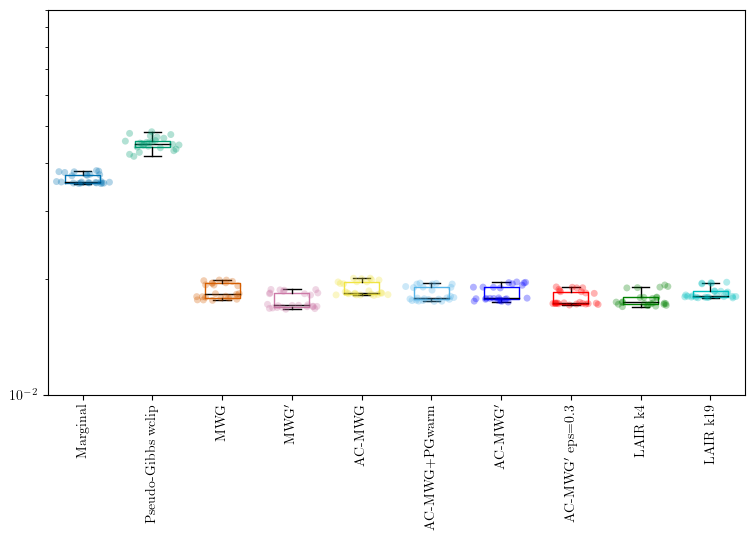

In [126]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(np.log10(1e1*0.3), np.log10(1e1*0.5))
# axes.set_ylim(np.log10(1e0), np.log10(1e1*0.3))

axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Miniboone

In [127]:
ds = 'uci_miniboone'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs_wclip',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1.npz')

#         try:
        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
#         except:
#             # Some Pseudo-Gibbs imps are really bad and sinkhorn computation fails, so ignore them
#             continue
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

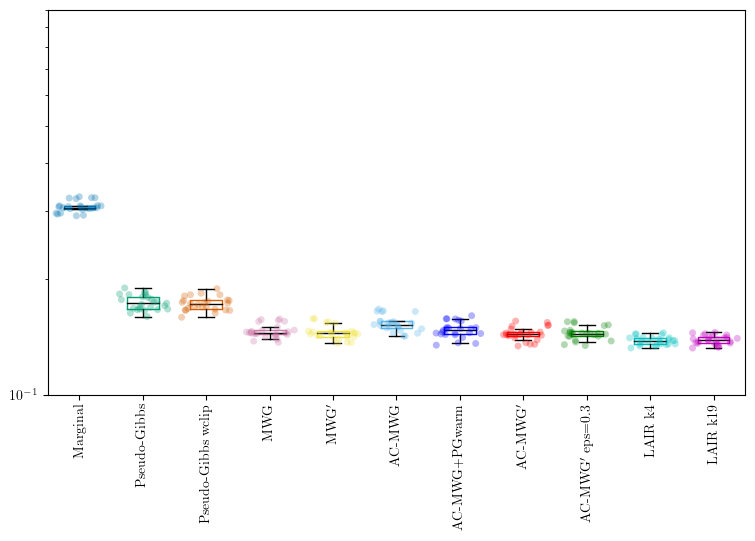

In [128]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})


axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### BSDS300

In [194]:
ds = 'bsds300'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1.npz')

#         try:
        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
#         except:
#             # Some Pseudo-Gibbs imps are really bad and sinkhorn computation fails, so ignore them
#             continue
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

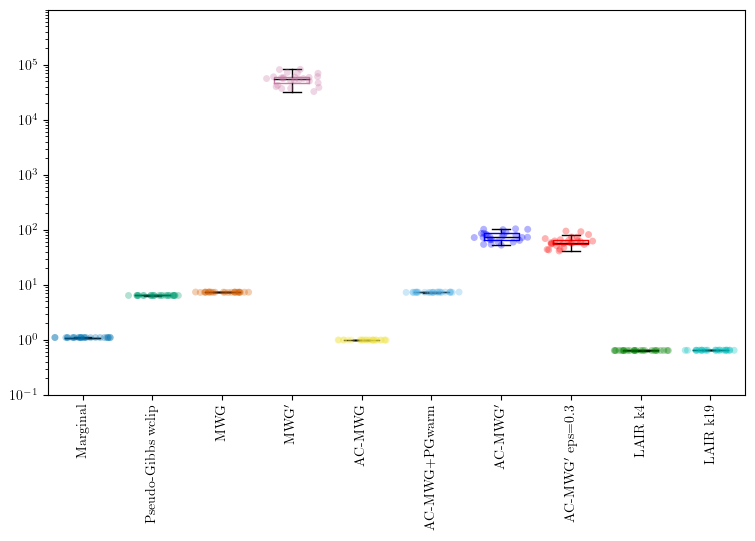

In [195]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_sinkhorn_per_imputation = []
model_labels = []
for j, model in enumerate(sinkhorn_per_imputation.keys()):
    score = sinkhorn_per_imputation[model]
    all_sinkhorn_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_sinkhorn_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_sinkhorn_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_sinkhorn_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})


axes.set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

## (Multi-seed) EnergyMMD divergence (per-imputation)

### Gas 

In [129]:
ds = 'uci_gas'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

energymmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

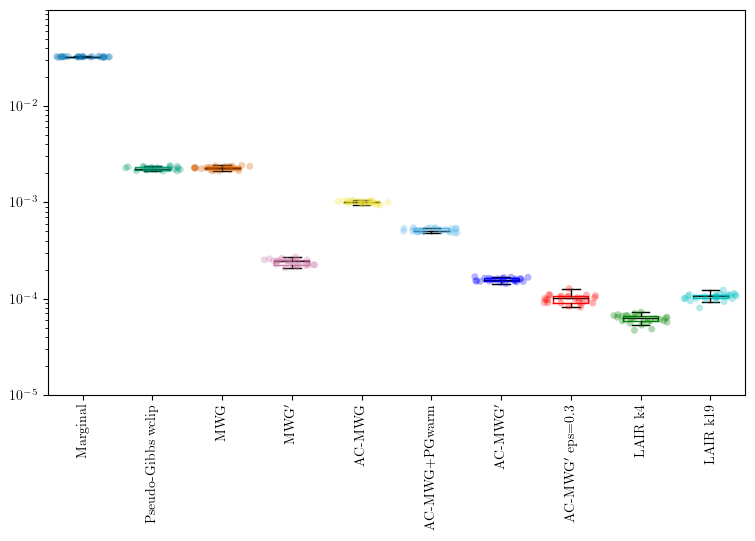

In [130]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

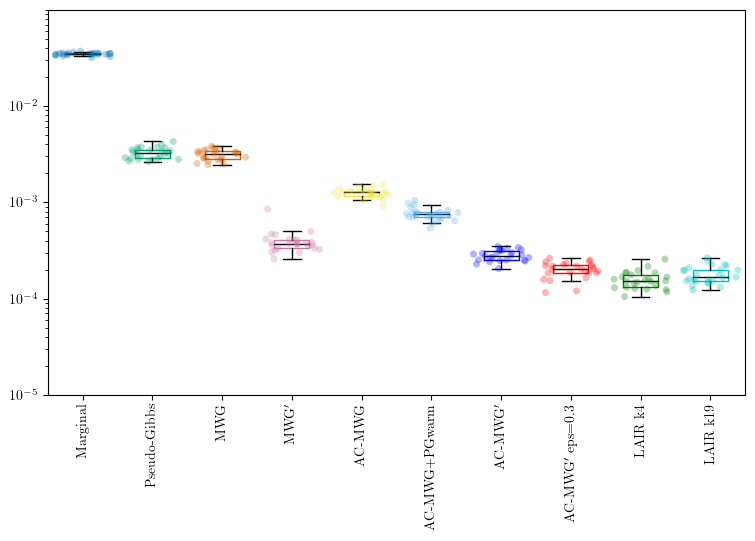

In [31]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Power 

In [131]:
ds = 'uci_power'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

energymmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

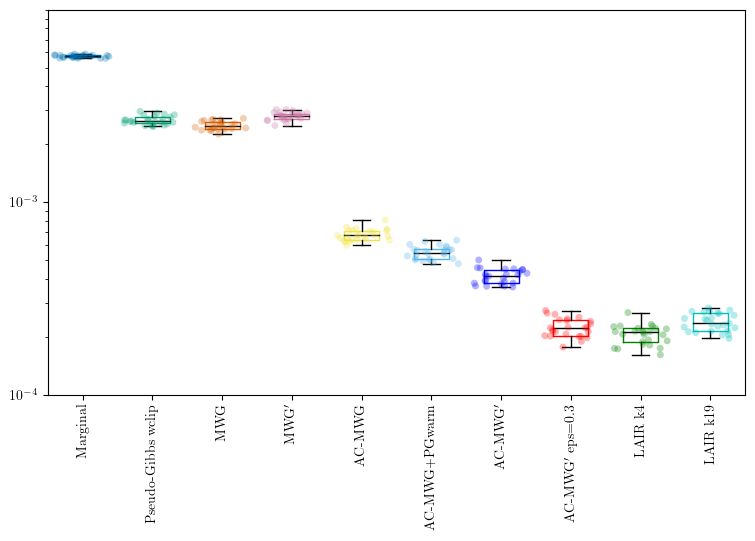

In [132]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

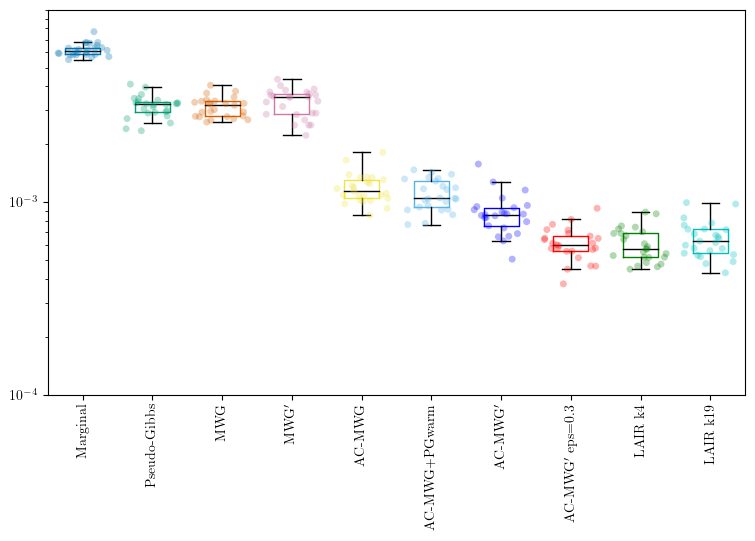

In [42]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Hepmass 

In [206]:
ds = 'uci_hepmass'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

energymmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

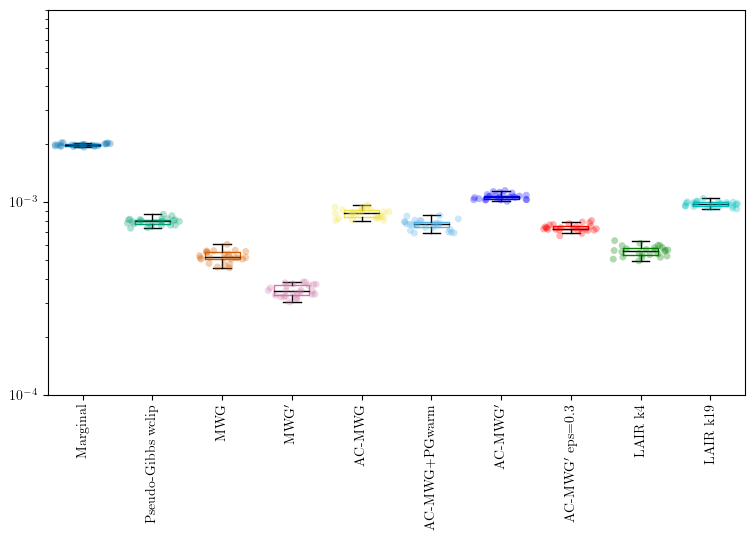

In [207]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    bplot_data = [x[np.isfinite(x)] for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

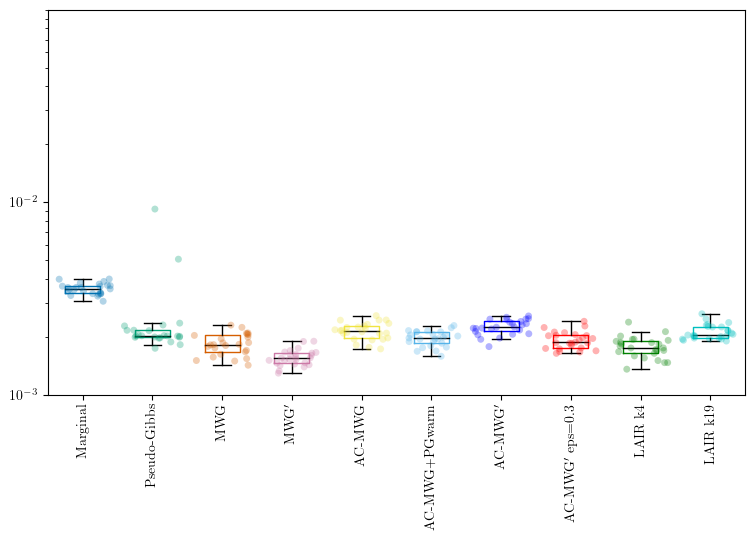

In [70]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    bplot_data = [x[np.isfinite(x)] for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Miniboone 

In [135]:
ds = 'uci_miniboone'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs_wclip',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

energymmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

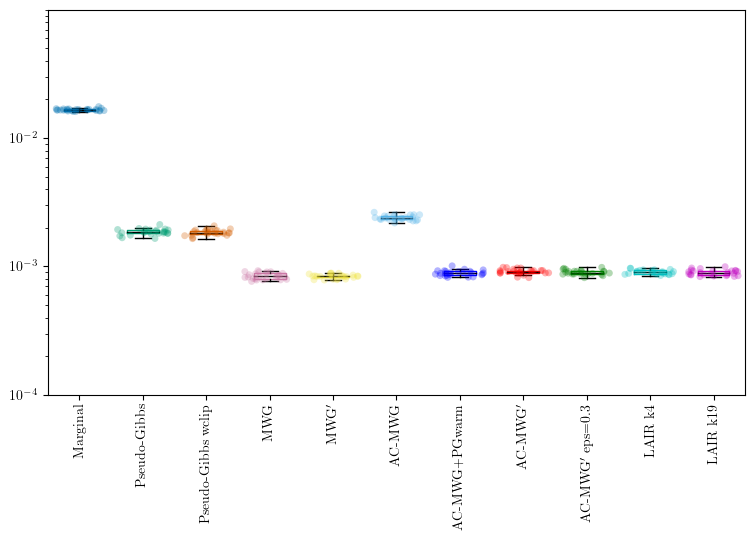

In [136]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    bplot_data = [x[np.isfinite(x)] for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

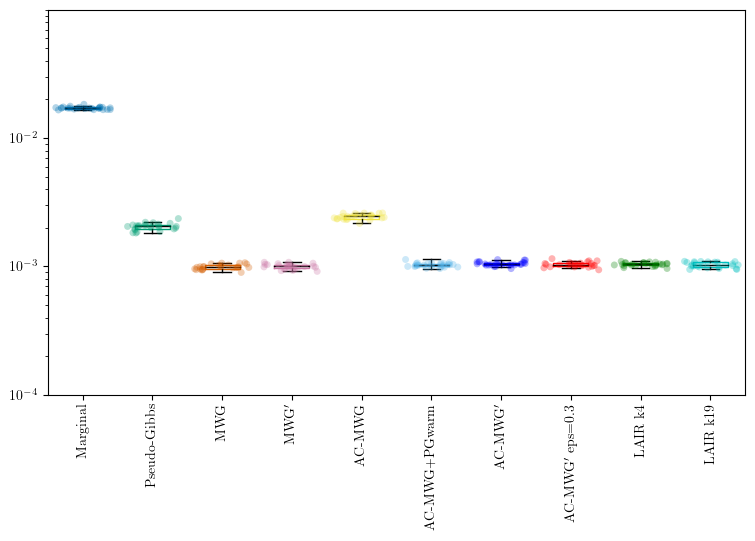

In [80]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    bplot_data = [x[np.isfinite(x)] for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### BSDS300 

In [196]:
ds = 'bsds300'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

energymmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

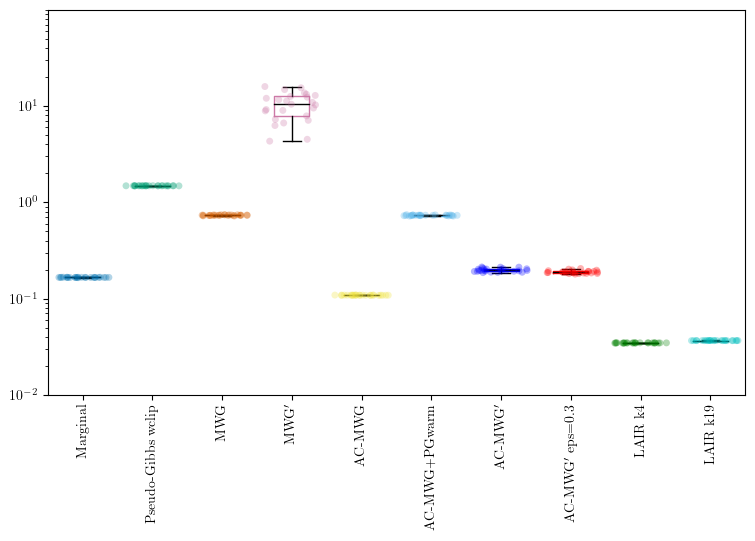

In [197]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_energymmd_per_imputation = []
model_labels = []
for j, model in enumerate(energymmd_per_imputation.keys()):
    score = energymmd_per_imputation[model]
    all_energymmd_per_imputation.append(score)
    
    model_labels.append(model)

bplot_data = all_energymmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    bplot_data = [x[np.isfinite(x)] for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_energymmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_energymmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

## (Multi-seed) GaussianMMD divergence (per-imputation)

### Gas 

In [137]:
ds = 'uci_gas'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

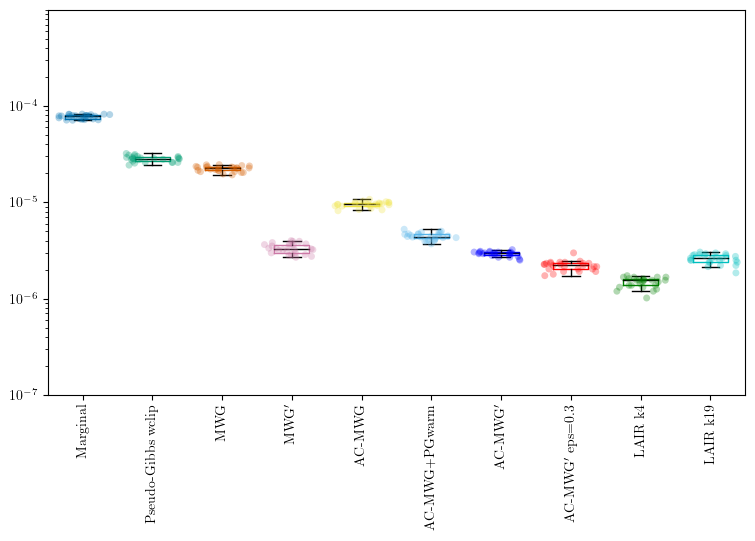

In [138]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

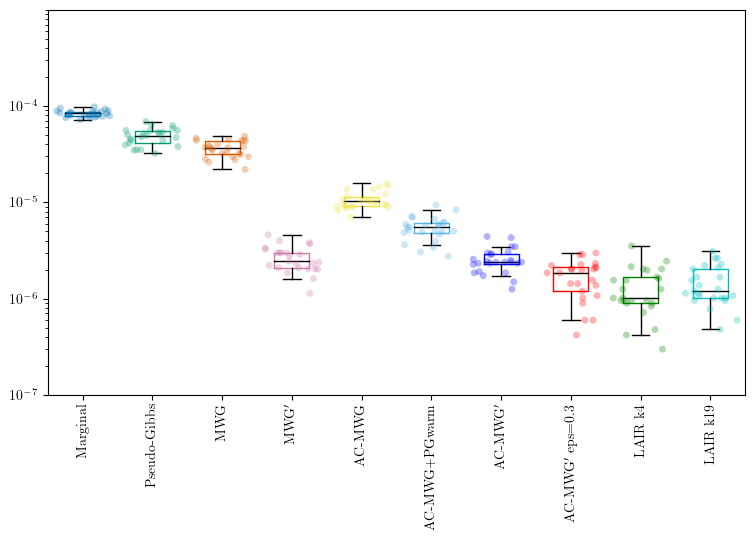

In [38]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Power 

In [139]:
ds = 'uci_power'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

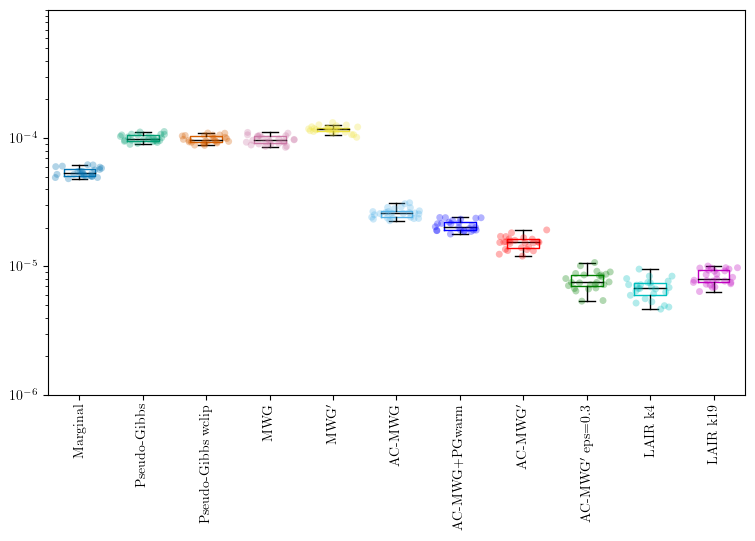

In [140]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

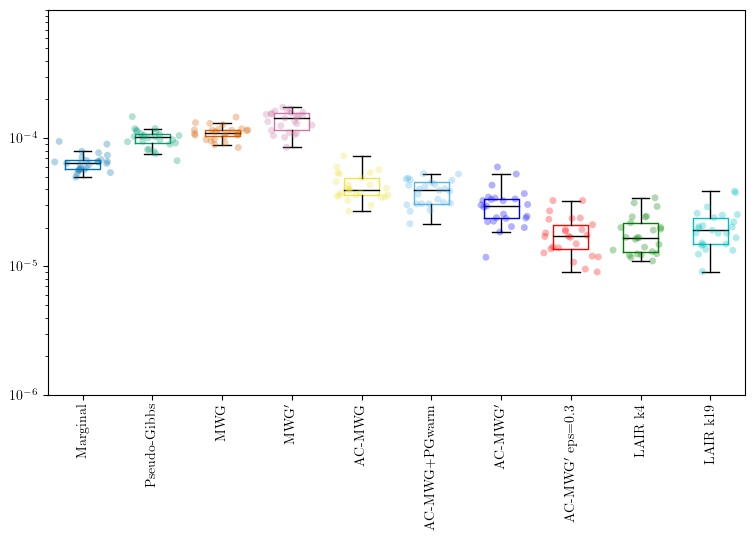

In [44]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Hepmass 

In [141]:
ds = 'uci_hepmass'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

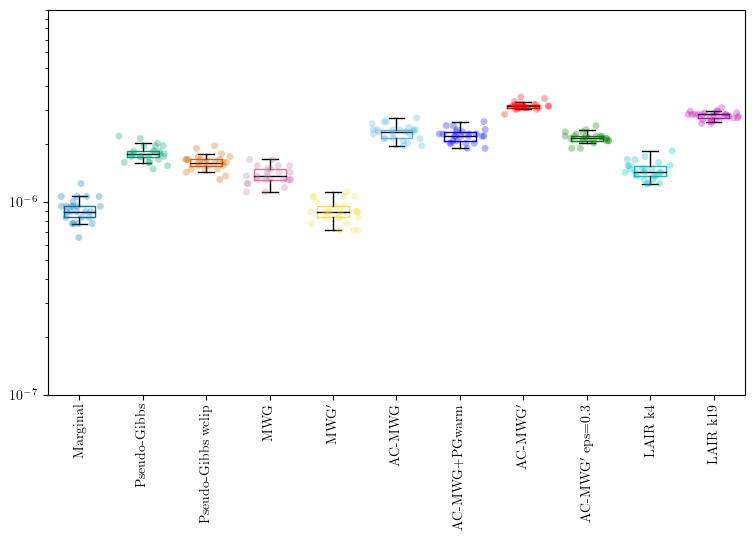

In [142]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

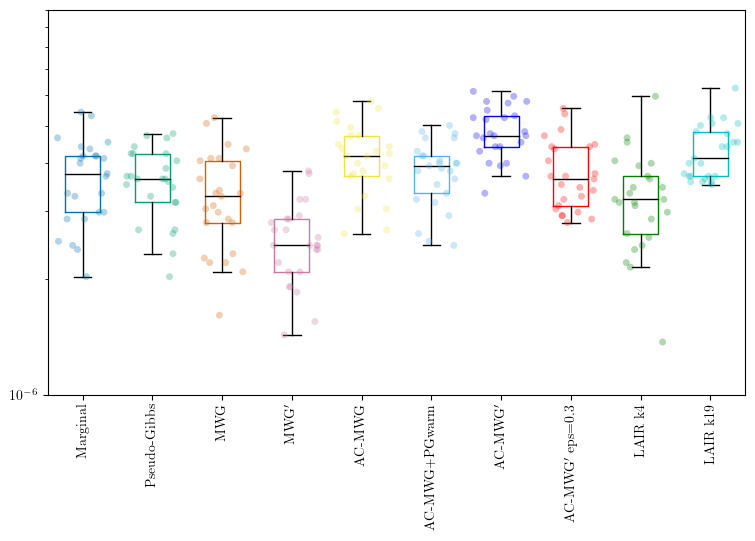

In [72]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Miniboone 

In [143]:
ds = 'uci_miniboone'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs_wclip',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

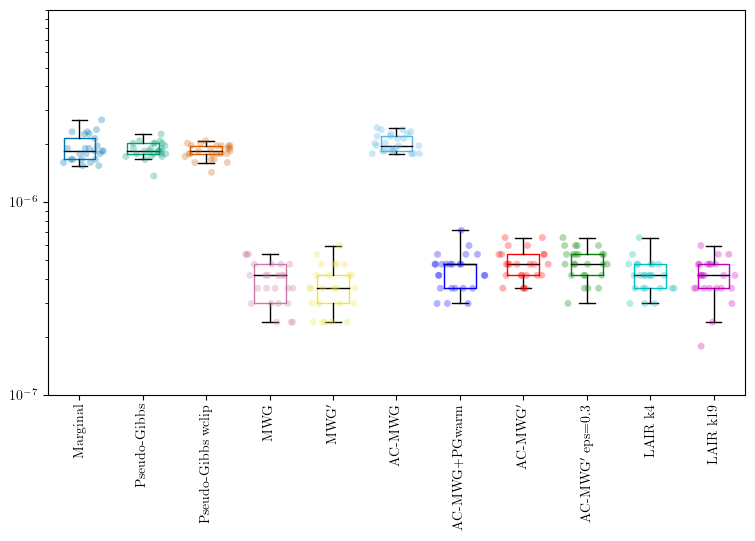

In [144]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

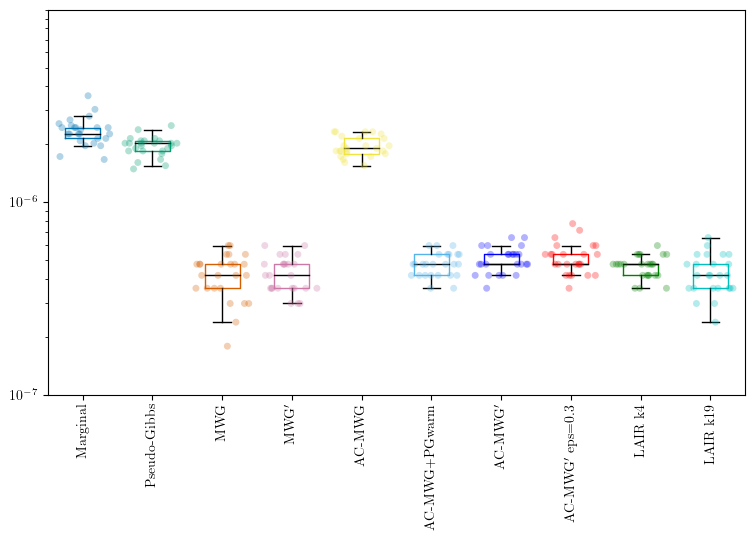

In [82]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### BSDS300 

In [198]:
ds = 'bsds300'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

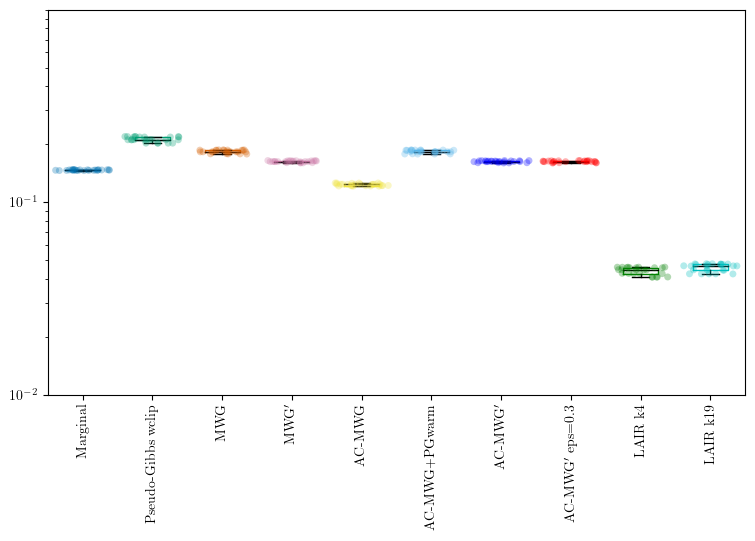

In [199]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_gaussianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(gaussianmmd_per_imputation.keys()):
    score = gaussianmmd_per_imputation[model]
    all_gaussianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_gaussianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_gaussianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_gaussianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

## (Multi-seed) LaplacianMMD divergence (per-imputation)

### Gas 

In [145]:
ds = 'uci_gas'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

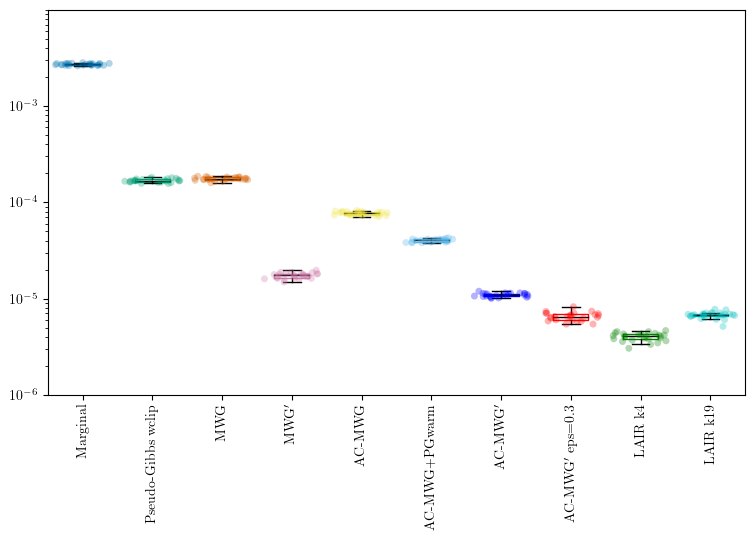

In [146]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

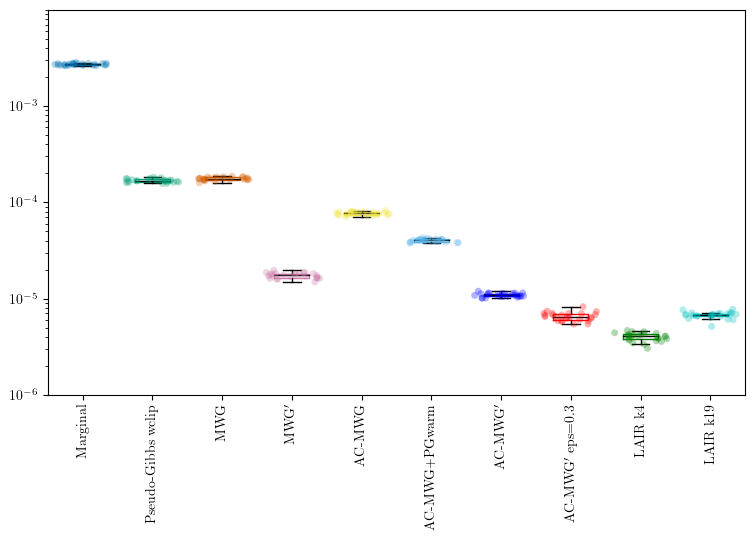

In [147]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Power 

In [148]:
ds = 'uci_power'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

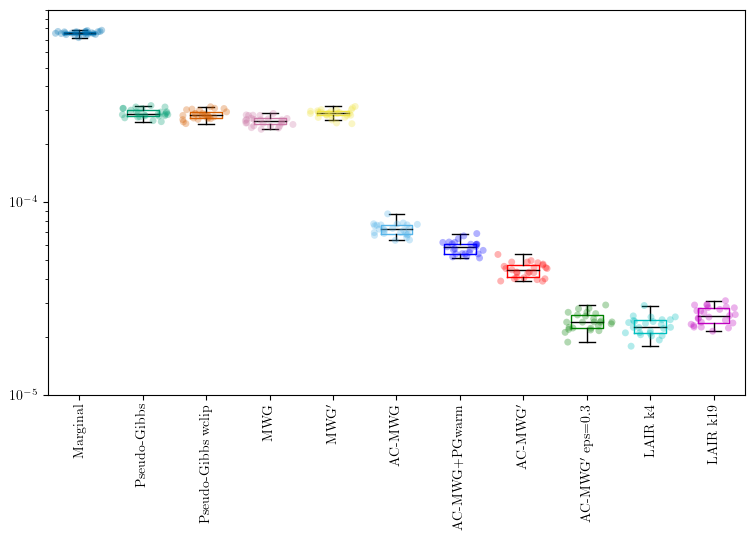

In [149]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

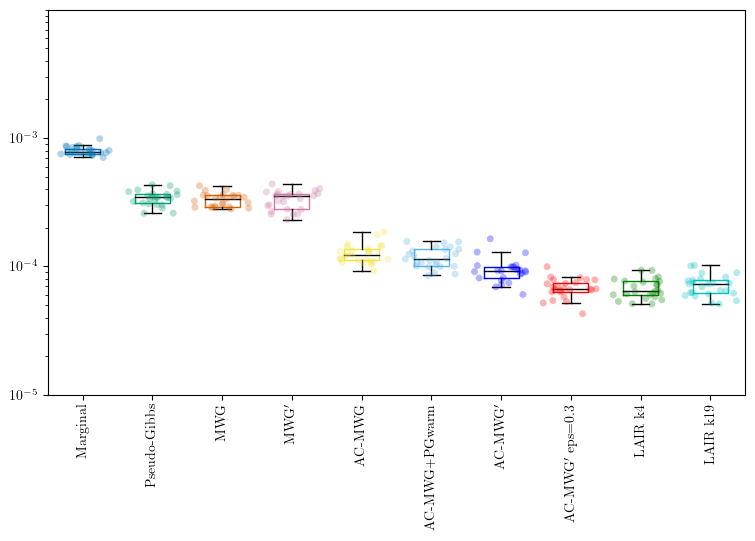

In [46]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Hepmass 

In [150]:
ds = 'uci_hepmass'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

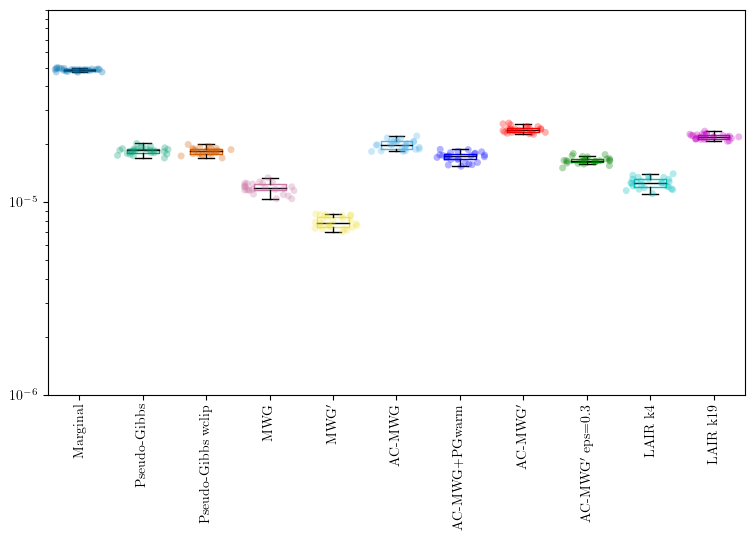

In [151]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

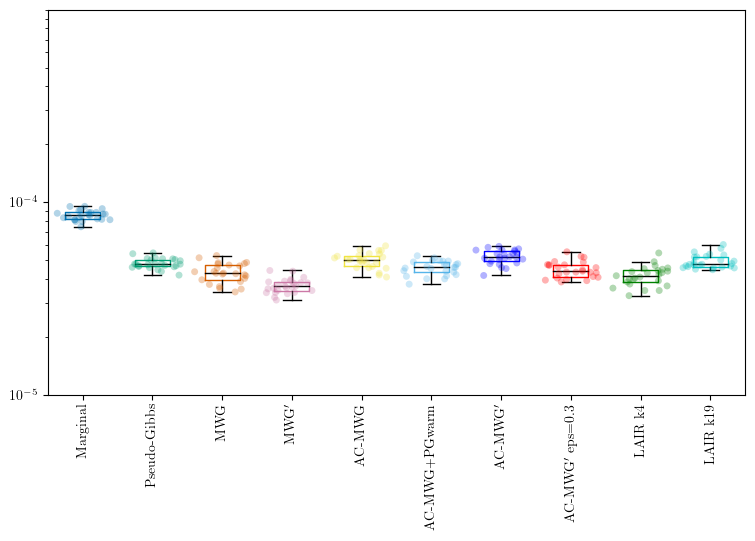

In [74]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### Miniboone 

In [152]:
ds = 'uci_miniboone'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs_wclip',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

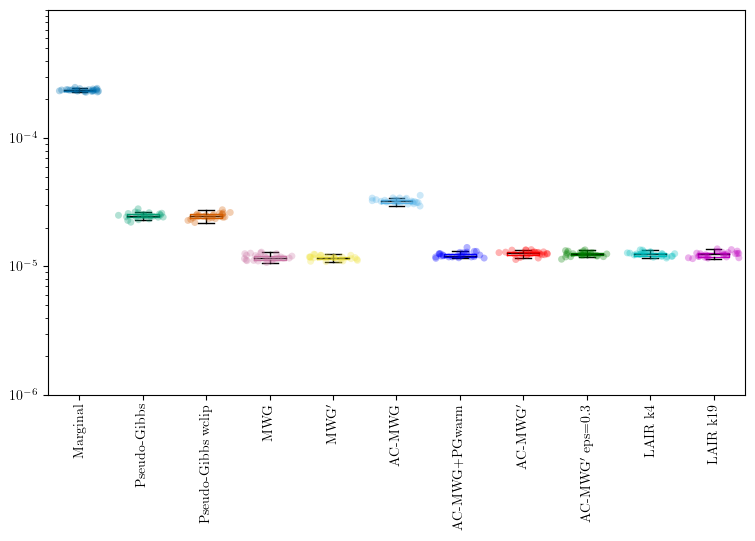

In [153]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

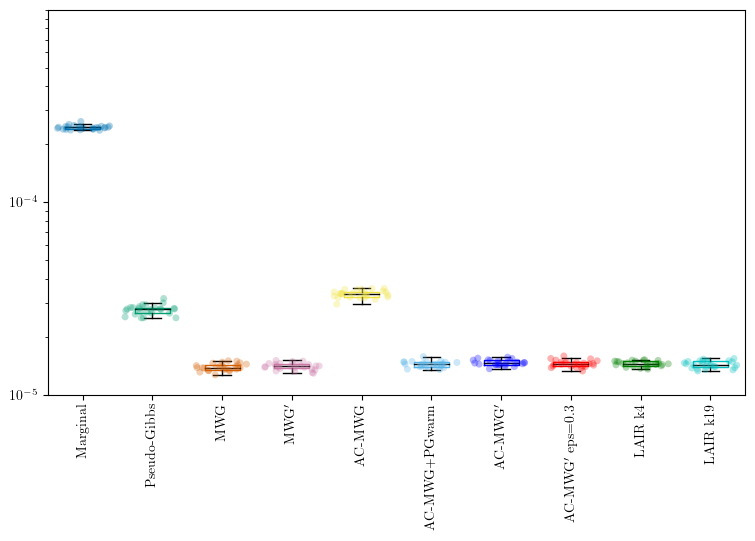

In [84]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

### BSDS300 

In [200]:
ds = 'bsds300'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

models = {
    'Marginal': 'vae_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

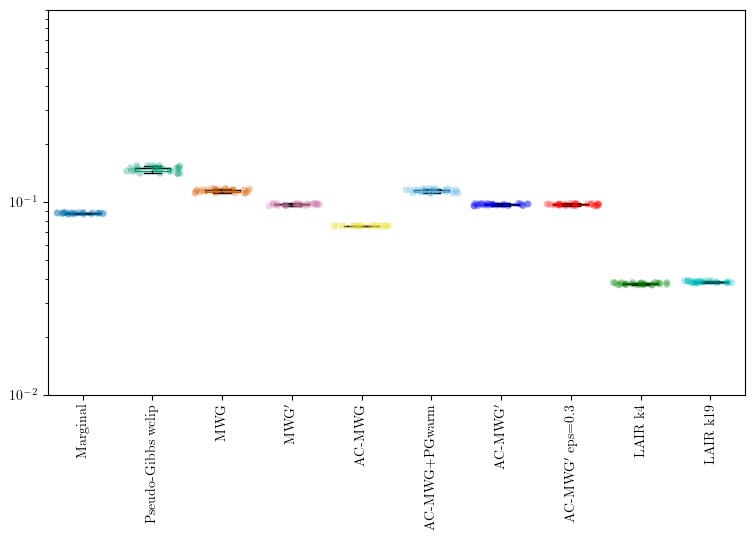

In [201]:
plot_log=True

fig, axes = plt.subplots(1, 1, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_laplacianmmd_per_imputation = []
model_labels = []
for j, model in enumerate(laplacianmmd_per_imputation.keys()):
    score = laplacianmmd_per_imputation[model]
    all_laplacianmmd_per_imputation.append(score)
    
    model_labels.append(model)

# RMSE

bplot_data = all_laplacianmmd_per_imputation
if plot_log:
    bplot_data = [np.log10(x) for x in bplot_data]
    
bplot = axes.boxplot(bplot_data, 
                     positions=np.arange(len(all_laplacianmmd_per_imputation)),
                     labels=model_labels, showfliers=False,
                     notch=False)


for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes, all_laplacianmmd_per_imputation, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=plot_log,
                      stripplot_kw={'alpha': 0.3})

# axes.set_ylim(-0.1, 3)

axes.set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
plt.setp(axes.get_xticklabels(), rotation=90, ha='center')

## (Multi-seed) Pointwise metrics

### Gas 

In [12]:
ds = 'uci_gas'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/sampling_u50_wholedataset_storelast/{{}}/seed_m{{}}_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
#                               num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

recompute = False
if recompute:
    
    rmse = {}
    mae = {}

    out = compute_pointwise_metrics_multiseed(path_template, models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=False)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    out = compute_pointwise_metrics_multiseed(path_template, irwg_resampled_models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=True)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    np.savez(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', rmse=rmse, mae=mae)
else:
    errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
    rmse = errs['rmse'].item()
    mae = errs['mae'].item()

Train data size: 852174
Validation data size: 94685
Test data size: 104789


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

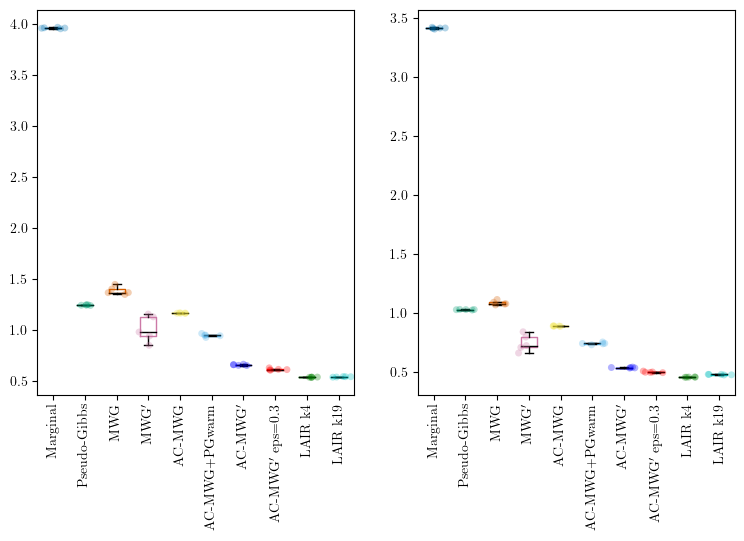

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_rmse = []
all_mae = []
model_labels = []
for j, model in enumerate(rmse.keys()):
    err = rmse[model]
    all_rmse.append(err)
    err = mae[model]
    all_mae.append(err)
    
    model_labels.append(model)

# RMSE
    
bplot = axes[0].boxplot(all_rmse, 
                     positions=np.arange(len(all_rmse)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[0], all_rmse, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})

# MAE

bplot = axes[1].boxplot(all_mae, 
                     positions=np.arange(len(all_mae)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[1], all_mae, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})


axes[0].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
axes[1].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')

### Power 

In [14]:
ds = 'uci_power'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/sampling_u50_wholedataset_storelast/{{}}/seed_m{{}}_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
#                               num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

recompute = False
if recompute:
    
    rmse = {}
    mae = {}

    out = compute_pointwise_metrics_multiseed(path_template, models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=False)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    out = compute_pointwise_metrics_multiseed(path_template, irwg_resampled_models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=True)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    np.savez(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', rmse=rmse, mae=mae)
else:
    errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
    rmse = errs['rmse'].item()
    mae = errs['mae'].item()

Train data size: 1659917
Validation data size: 184435
Test data size: 201583


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

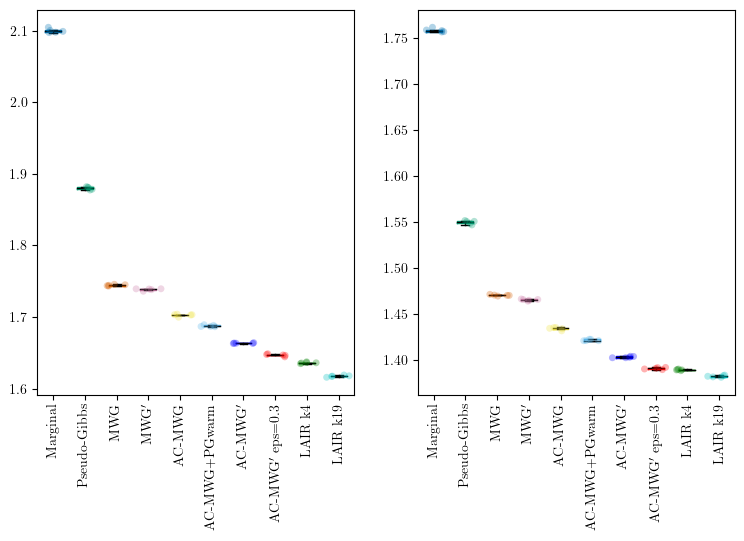

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_rmse = []
all_mae = []
model_labels = []
for j, model in enumerate(rmse.keys()):
    err = rmse[model]
    all_rmse.append(err)
    err = mae[model]
    all_mae.append(err)
    
    model_labels.append(model)

# RMSE
    
bplot = axes[0].boxplot(all_rmse, 
                     positions=np.arange(len(all_rmse)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[0], all_rmse, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})

# MAE

bplot = axes[1].boxplot(all_mae, 
                     positions=np.arange(len(all_mae)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[1], all_mae, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})


axes[0].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
axes[1].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')

### Hepmass 

In [16]:
ds = 'uci_hepmass'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/sampling_u50_wholedataset_storelast/{{}}/seed_m{{}}_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
#                               num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

recompute = False
if recompute:
    
    rmse = {}
    mae = {}

    out = compute_pointwise_metrics_multiseed(path_template, models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=False)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    out = compute_pointwise_metrics_multiseed(path_template, irwg_resampled_models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=True)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    np.savez(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', rmse=rmse, mae=mae)
else:
    errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
    rmse = errs['rmse'].item()
    mae = errs['mae'].item()

Train data size: 315123
Validation data size: 35013
Test data size: 174987


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

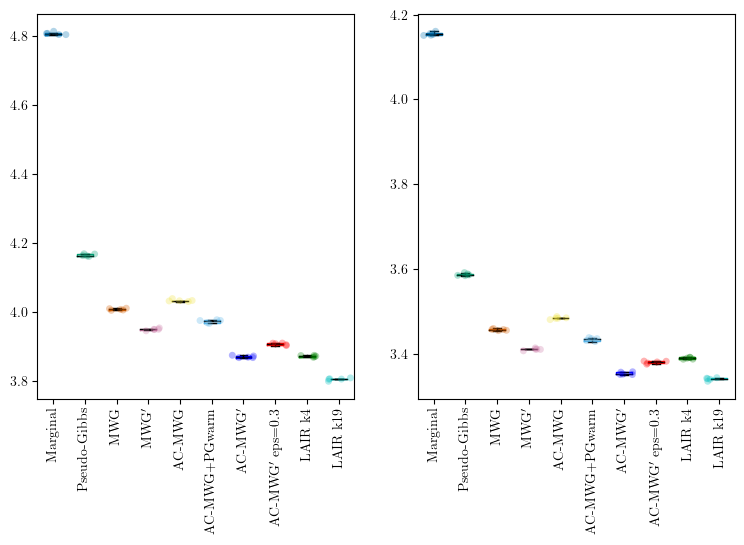

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_rmse = []
all_mae = []
model_labels = []
for j, model in enumerate(rmse.keys()):
    err = rmse[model]
    all_rmse.append(err)
    err = mae[model]
    all_mae.append(err)
    
    model_labels.append(model)

# RMSE
    
bplot = axes[0].boxplot(all_rmse, 
                     positions=np.arange(len(all_rmse)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[0], all_rmse, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})

# MAE

bplot = axes[1].boxplot(all_mae, 
                     positions=np.arange(len(all_mae)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[1], all_mae, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})


axes[0].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
axes[1].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')

### Miniboone 

In [18]:
ds = 'uci_miniboone'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/sampling_u50_wholedataset_storelast/{{}}/seed_m{{}}_d20220118/lightning_logs'

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
#                               num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

recompute = False
if recompute:
    
    rmse = {}
    mae = {}

    out = compute_pointwise_metrics_multiseed(path_template, models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=False)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    out = compute_pointwise_metrics_multiseed(path_template, irwg_resampled_models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=True)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    np.savez(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', rmse=rmse, mae=mae)
else:
    errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
    rmse = errs['rmse'].item()
    mae = errs['mae'].item()

Train data size: 29556
Validation data size: 3284
Test data size: 3648


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

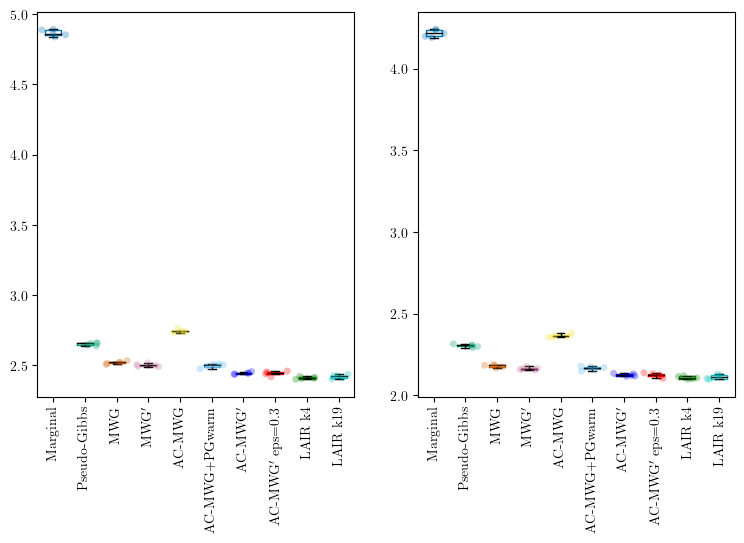

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_rmse = []
all_mae = []
model_labels = []
for j, model in enumerate(rmse.keys()):
    err = rmse[model]
    all_rmse.append(err)
    err = mae[model]
    all_mae.append(err)
    
    model_labels.append(model)

# RMSE
    
bplot = axes[0].boxplot(all_rmse, 
                     positions=np.arange(len(all_rmse)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[0], all_rmse, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})

# MAE

bplot = axes[1].boxplot(all_mae, 
                     positions=np.arange(len(all_mae)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[1], all_mae, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})


axes[0].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
axes[1].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')

### BSDS300 

In [20]:
ds = 'bsds300'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']
path_template = f'../logs/{ds}/imputation/sampling_u50_wholedataset_storelast/{{}}/seed_m{{}}_d20220118/lightning_logs'

models = {
    'Marginal': 'vae_marginal_vae_baseline',
#     'Pseudo-Gibbs': 'vae_k5_pseudo_gibbs',
    'Pseudo-Gibbs wclip': 'vae_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

datamodule = MissingDataModule(dataset=DATASET[ds],
                              missingness=MISSINGNESS['uniform'],
                              setup_seed=20220118,
#                               num_first_datapoints_test=3000,
                              batch_size=512,
                              total_miss_train=0.,
                              total_miss_val=0.,
                              total_miss_test=0.5,
                              filter_fully_missing_test=True,
                              data_root='../data/')
datamodule.setup('fit')
datamodule.setup('test')

X_test_true_dataset, masks_true_dataset, data_idx_true_dataset = datamodule.test_data[:][:3]
masks_true_dataset = torch.tensor(masks_true_dataset)

recompute = False
if recompute:
    
    rmse = {}
    mae = {}

    out = compute_pointwise_metrics_multiseed(path_template, models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=False)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    out = compute_pointwise_metrics_multiseed(path_template, irwg_resampled_models, seeds, 
                                      load_last_n_iterations=1,
                                      data_idx_true_dataset=data_idx_true_dataset, 
                                      masks_true_dataset=masks_true_dataset, 
                                      X_test_true_dataset=X_test_true_dataset, 
                                      use_irwg_resampled=True)
    rmse = {**rmse, **out['rmse']}
    mae = {**mae, **out['mae']}

    np.savez(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', rmse=rmse, mae=mae)
else:
    errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
    rmse = errs['rmse'].item()
    mae = errs['mae'].item()

Train data size: 1000000
Validation data size: 50000
Test data size: 250000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

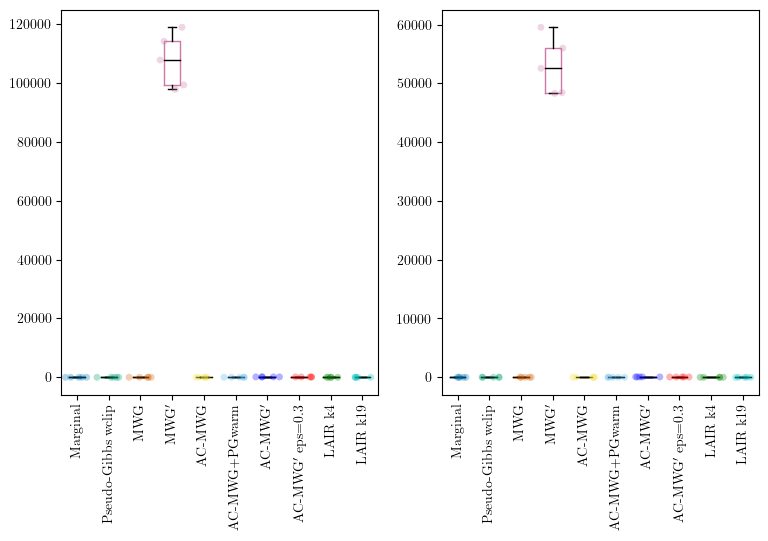

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']


all_rmse = []
all_mae = []
model_labels = []
for j, model in enumerate(rmse.keys()):
    err = rmse[model]
    all_rmse.append(err)
    err = mae[model]
    all_mae.append(err)
    
    model_labels.append(model)

# RMSE
    
bplot = axes[0].boxplot(all_rmse, 
                     positions=np.arange(len(all_rmse)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[0], all_rmse, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})

# MAE

bplot = axes[1].boxplot(all_mae, 
                     positions=np.arange(len(all_mae)),
                     labels=model_labels, showfliers=False,
                     notch=False)

for i, box in enumerate(bplot['boxes']):
    box.set_color(colors[i])
    box.set_linewidth(1)
for i, box in enumerate(bplot['medians']):
    box.set_color('k')
    box.set_linewidth(1)
    
plot_custom_stripplot(axes[1], all_mae, model_labels, 
                      colors=colors,
                      no_trim=True, only_trim_up=False, 
                      showmedians=False, 
                      use_log_scale=False,
                      stripplot_kw={'alpha': 0.3})


axes[0].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
axes[1].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
plt.setp(axes[0].get_xticklabels(), rotation=90, ha='center')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='center')

## Paper figure Pointwise RMSE and Sinkhorn (p=2)

In [22]:
all_ds_rmse = {}
all_ds_mae = {}
all_ds_sinkhorn = {}

In [23]:
## GAS

ds = 'uci_gas'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores

all_ds_sinkhorn[ds] = sinkhorn_per_imputation

In [24]:
## POWER

ds = 'uci_power'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores

all_ds_sinkhorn[ds] = sinkhorn_per_imputation

In [25]:
## HEPMASS

ds = 'uci_hepmass'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')

        try:
            scores = np.load(path)
            all_scores.append(scores['sinkhorn_per_imputation'])
        except:
            # Some Pseudo-Gibbs imps are really bad and sinkhorn computation fails, so ignore them
            continue
    try:
        all_scores = np.concatenate(all_scores)
    except:
        if model == 'Pseudo-Gibbs':
            all_scores = [float('inf')]
        else:
            raise Error()
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores

all_ds_sinkhorn[ds] = sinkhorn_per_imputation

In [26]:
## MINIBOONE

ds = 'uci_miniboone'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores

all_ds_sinkhorn[ds] = sinkhorn_per_imputation

### Filter and map

In [27]:
dataset_name_map = {
    'uci_gas' : 'Gas',
    'uci_power': 'Power',
    'uci_hepmass': 'Hepmass',
    'uci_miniboone': 'Miniboone'
}

filter_and_map = {
    'Marginal': 'Marginal',
    'Pseudo-Gibbs': 'Pseudo-Gibbs',
    'MWG$\'$': 'MWG$\'$',
#     'AC-MWG$\'$': 'AC-MWG$\'$',
    'AC-MWG$\'$ eps=0.3': 'AC-MWG$\'$',
    'LAIR k4': 'LAIR'
#     'LAIR k19': 'LAIR'
}

for ds in all_ds_sinkhorn.keys():
    all_ds_sinkhorn[ds] = {filter_and_map[m]: s for m, s in all_ds_sinkhorn[ds].items() if m in filter_and_map}
    all_ds_rmse[ds] = {filter_and_map[m]: s for m, s in all_ds_rmse[ds].items() if m in filter_and_map}
    all_ds_mae[ds] = {filter_and_map[m]: s for m, s in all_ds_mae[ds].items() if m in filter_and_map}

### Scatter + box plot

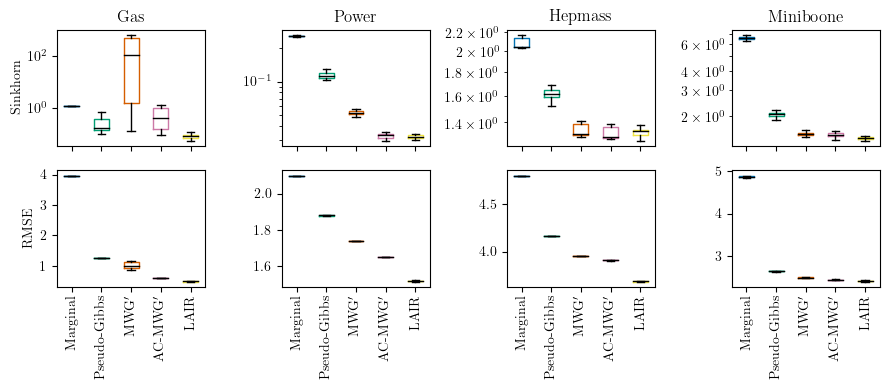

In [163]:
plot_log=False

fig, axes = plt.subplots(2, 4, figsize=(9, 4), sharex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

## Sinkhorn

for d, ds in enumerate(all_ds_sinkhorn.keys()):
    all_sinkhorn_per_imputation = []
    model_labels = []
    for j, model in enumerate(all_ds_sinkhorn[ds].keys()):
        score = all_ds_sinkhorn[ds][model]
        all_sinkhorn_per_imputation.append(score)

        model_labels.append(model)

    bplot_data = all_sinkhorn_per_imputation
    if plot_log:
        bplot_data = [np.log10(x) for x in bplot_data]

    bplot = axes[0, d].boxplot(bplot_data, 
                         positions=np.arange(len(all_sinkhorn_per_imputation)),
                         labels=model_labels, showfliers=False,
                         notch=False)


    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

#     plot_custom_stripplot(axes[0, d], all_sinkhorn_per_imputation, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=plot_log,
#                           stripplot_kw={'alpha': 0.3})
    
    if plot_log:
        axes[0, d].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = axes[0, d].get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        axes[0, d].yaxis.set_ticks(tick_range)
        axes[0, d].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    

    axes[0, d].set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
    plt.setp(axes[0, d].get_xticklabels(), rotation=90, ha='center')
    
    axes[0, d].set_title(dataset_name_map[ds], fontsize=12)
    
## RMSE    
for d, ds in enumerate(all_ds_rmse.keys()):

    all_rmse = []
    model_labels = []
    for j, model in enumerate(all_ds_rmse[ds].keys()):
        err = all_ds_rmse[ds][model]
        all_rmse.append(err)

        model_labels.append(model)

    # RMSE

    bplot = axes[1, d].boxplot(all_rmse, 
                         positions=np.arange(len(all_rmse)),
                         labels=model_labels, showfliers=False,
                         notch=False)

    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

#     plot_custom_stripplot(axes[1, d], all_rmse, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=False,
#                           stripplot_kw={'alpha': 0.3})


    axes[1, d].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
    plt.setp(axes[1, d].get_xticklabels(), rotation=90, ha='center')

axes[0, 0].set_ylabel('Sinkhorn')
axes[1, 0].set_ylabel('RMSE')

axes[0,0].set_yscale('log', base=10)
axes[0,1].set_yscale('log', base=10)
axes[0,2].set_yscale('log', base=10)
axes[0,3].set_yscale('log', base=10)

fig.tight_layout()

# fig.savefig('./figures/large_UCI_sinkhorn_p2_and_rmse.pdf')

## Paper figure Pointwise RMSE and Sinkhorn (p=1)

In [29]:
all_ds_rmse = {}
all_ds_mae = {}
all_ds_sinkhorn = {}

In [30]:
## GAS

ds = 'uci_gas'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores

all_ds_sinkhorn[ds] = sinkhorn_per_imputation

In [31]:
## POWER

ds = 'uci_power'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores

all_ds_sinkhorn[ds] = sinkhorn_per_imputation

In [32]:
## HEPMASS

ds = 'uci_hepmass'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1.npz')

        try:
            scores = np.load(path)
            all_scores.append(scores['sinkhorn_per_imputation'])
        except:
            # Some Pseudo-Gibbs imps are really bad and sinkhorn computation fails, so ignore them
            continue
    try:
        all_scores = np.concatenate(all_scores)
    except:
        if model == 'Pseudo-Gibbs':
            all_scores = [float('inf')]
        else:
            raise Error()
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores

all_ds_sinkhorn[ds] = sinkhorn_per_imputation

In [33]:
## MINIBOONE

ds = 'uci_miniboone'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

sinkhorn_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_sinkhorn_per_imputation_p1_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['sinkhorn_per_imputation'])
    all_scores = np.concatenate(all_scores)
    sinkhorn_per_imputation[model] = all_scores

all_ds_sinkhorn[ds] = sinkhorn_per_imputation

### Filter and map

In [34]:
dataset_name_map = {
    'uci_gas' : 'Gas',
    'uci_power': 'Power',
    'uci_hepmass': 'Hepmass',
    'uci_miniboone': 'Miniboone'
}

filter_and_map = {
    'Marginal': 'Marginal',
    'Pseudo-Gibbs': 'Pseudo-Gibbs',
    'MWG$\'$': 'MWG$\'$',
#     'AC-MWG$\'$': 'AC-MWG$\'$',
    'AC-MWG$\'$ eps=0.3': 'AC-MWG$\'$',
    'LAIR k4': 'LAIR'
#     'LAIR k19': 'LAIR'
}

for ds in all_ds_sinkhorn.keys():
    all_ds_sinkhorn[ds] = {filter_and_map[m]: s for m, s in all_ds_sinkhorn[ds].items() if m in filter_and_map}
    all_ds_rmse[ds] = {filter_and_map[m]: s for m, s in all_ds_rmse[ds].items() if m in filter_and_map}
    all_ds_mae[ds] = {filter_and_map[m]: s for m, s in all_ds_mae[ds].items() if m in filter_and_map}

### Scatter + box plot

(0.015106554701924324, 0.04979714415967464)


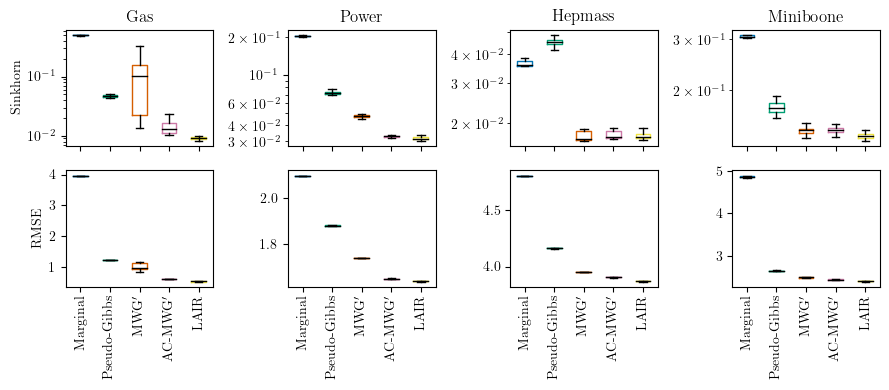

In [36]:
plot_log=False

fig, axes = plt.subplots(2, 4, figsize=(9, 4), sharex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

## Sinkhorn

for d, ds in enumerate(all_ds_sinkhorn.keys()):
    all_sinkhorn_per_imputation = []
    model_labels = []
    for j, model in enumerate(all_ds_sinkhorn[ds].keys()):
        score = all_ds_sinkhorn[ds][model]
        all_sinkhorn_per_imputation.append(score)

        model_labels.append(model)

    bplot_data = all_sinkhorn_per_imputation
    if plot_log:
        bplot_data = [np.log10(x) for x in bplot_data]

    bplot = axes[0, d].boxplot(bplot_data, 
                         positions=np.arange(len(all_sinkhorn_per_imputation)),
                         labels=model_labels, showfliers=False,
                         notch=False)


    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

#     plot_custom_stripplot(axes[0, d], all_sinkhorn_per_imputation, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=plot_log,
#                           stripplot_kw={'alpha': 0.3})
    
    if plot_log:
        axes[0, d].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = axes[0, d].get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        axes[0, d].yaxis.set_ticks(tick_range)
        axes[0, d].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    

    axes[0, d].set_xticks(np.arange(0, len(all_sinkhorn_per_imputation)), labels=model_labels)
    plt.setp(axes[0, d].get_xticklabels(), rotation=90, ha='center')
    
    axes[0, d].set_title(dataset_name_map[ds], fontsize=12)
    
## RMSE    
for d, ds in enumerate(all_ds_rmse.keys()):

    all_rmse = []
    model_labels = []
    for j, model in enumerate(all_ds_rmse[ds].keys()):
        err = all_ds_rmse[ds][model]
        all_rmse.append(err)

        model_labels.append(model)

    # RMSE

    bplot = axes[1, d].boxplot(all_rmse, 
                         positions=np.arange(len(all_rmse)),
                         labels=model_labels, showfliers=False,
                         notch=False)

    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

#     plot_custom_stripplot(axes[1, d], all_rmse, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=False,
#                           stripplot_kw={'alpha': 0.3})


    axes[1, d].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
    plt.setp(axes[1, d].get_xticklabels(), rotation=90, ha='center')

axes[0, 0].set_ylabel('Sinkhorn')
axes[1, 0].set_ylabel('RMSE')

print(axes[0, 2].get_ylim())

# Hepmass: Pseudo-Gibbs is really large, so rescaling the yaxis to put it outside of the figure.
# axes[0, 2].set_ylim(0.015, 0.05)

axes[0,0].set_yscale('log', base=10)
axes[0,1].set_yscale('log', base=10)
axes[0,2].set_yscale('log', base=10)
axes[0,3].set_yscale('log', base=10)


fig.tight_layout()

# fig.savefig('./figures/large_UCI_sinkhorn_p1_and_rmse.pdf')

## Paper figure (other metrics)

In [37]:
all_ds_rmse = {}
all_ds_mae = {}
# all_ds_sinkhorn = {}

all_ds_energymmd = {}
all_ds_gaussianmmd = {}
all_ds_laplacianmmd = {}

In [38]:
## GAS

ds = 'uci_gas'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

energymmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores

all_ds_energymmd[ds] = energymmd_per_imputation

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
all_ds_gaussianmmd[ds] = gaussianmmd_per_imputation

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
all_ds_laplacianmmd[ds] = laplacianmmd_per_imputation

In [39]:
## POWER

ds = 'uci_power'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_wtrainnoise_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_wtrainnoise_no_kl_sched_k5_pseudo_gibbs',
    'MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_wtrainnoise_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_wtrainnoise_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_wtrainnoise_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

energymmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores

all_ds_energymmd[ds] = energymmd_per_imputation

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
all_ds_gaussianmmd[ds] = gaussianmmd_per_imputation

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
all_ds_laplacianmmd[ds] = laplacianmmd_per_imputation

In [40]:
## HEPMASS

ds = 'uci_hepmass'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_no_kl_sched_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_no_kl_sched_k5_pseudo_gibbs_wclip',
    'MWG': 'vae_no_kl_sched_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_no_kl_sched_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_no_kl_sched_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae_no_kl_sched_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

energymmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores

all_ds_energymmd[ds] = energymmd_per_imputation

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
all_ds_gaussianmmd[ds] = gaussianmmd_per_imputation

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
all_ds_laplacianmmd[ds] = laplacianmmd_per_imputation

In [41]:
## MINIBOONE

ds = 'uci_miniboone'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae2_no_kl_sched_drop05_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae2_no_kl_sched_drop05_k5_pseudo_gibbs',
    'MWG': 'vae2_no_kl_sched_drop05_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwg_with_irwg_warmup_replenish1',
    'AC-MWG': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
    'AC-MWG$\'$ eps=0.3': 'vae2_no_kl_sched_drop05_k5_mwgm_usehistrestricted_03prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae2_no_kl_sched_drop05_k4_irwg_i1_dmis_gr_mult_1replenish_finalresample',
    'LAIR k19': 'vae2_no_kl_sched_drop05_k19_irwg_i1_dmis_gr_mult_1replenish_finalresample',
}

errs = np.load(f'./large-uci-pointwise-metrics-wholedataset/pointwise-metrics-{ds}.npz', allow_pickle=True)
all_ds_rmse[ds] = errs['rmse'].item()
all_ds_mae[ds] = errs['mae'].item()

path_template = f'../logs/{ds}/imputation/eval_sampling_u50_imputed_dataset_divergences_diffseeds_lastimp/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

energymmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_energymmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['energymmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    energymmd_per_imputation[model] = all_scores

all_ds_energymmd[ds] = energymmd_per_imputation

gaussianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_gaussianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['gaussianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    gaussianmmd_per_imputation[model] = all_scores
    
all_ds_gaussianmmd[ds] = gaussianmmd_per_imputation

laplacianmmd_per_imputation = {}
for model, model_path in models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
for model, model_path in irwg_resampled_models.items():
    all_scores = []
    for seed in seeds:
        path = path_template.format(model_path, seed)
        path = os.path.join(path, 'uci_imp_dataset_divergences_laplacianmmd_per_imputation_irwg_resampled.npz')

        scores = np.load(path)
        all_scores.append(scores['laplacianmmd_per_imputation'])
    all_scores = np.concatenate(all_scores)
    laplacianmmd_per_imputation[model] = all_scores
    
all_ds_laplacianmmd[ds] = laplacianmmd_per_imputation

### Filter and map

In [42]:
dataset_name_map = {
    'uci_gas' : 'Gas',
    'uci_power': 'Power',
    'uci_hepmass': 'Hepmass',
    'uci_miniboone': 'Miniboone'
}

filter_and_map = {
    'Marginal': 'Marginal',
    'Pseudo-Gibbs': 'Pseudo-Gibbs',
    'MWG': 'MWG',
    'MWG$\'$': 'MWG$\'$',
#     'AC-MWG$\'$': 'AC-MWG$\'$',
    'AC-MWG$\'$ eps=0.3': 'AC-MWG$\'$',
    'LAIR k4': 'LAIR'
#     'LAIR k19': 'LAIR'
}

for ds in all_ds_energymmd.keys():
    all_ds_energymmd[ds] = {filter_and_map[m]: s for m, s in all_ds_energymmd[ds].items() if m in filter_and_map}
    all_ds_gaussianmmd[ds] = {filter_and_map[m]: s for m, s in all_ds_gaussianmmd[ds].items() if m in filter_and_map}
    all_ds_laplacianmmd[ds] = {filter_and_map[m]: s for m, s in all_ds_laplacianmmd[ds].items() if m in filter_and_map}
    
    all_ds_rmse[ds] = {filter_and_map[m]: s for m, s in all_ds_rmse[ds].items() if m in filter_and_map}
    all_ds_mae[ds] = {filter_and_map[m]: s for m, s in all_ds_mae[ds].items() if m in filter_and_map}

### Scatter + box plot

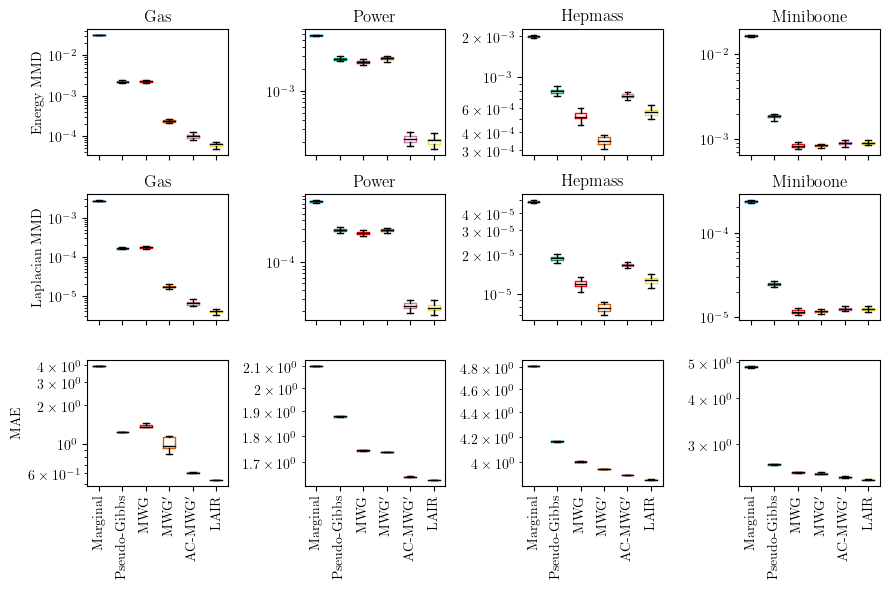

In [44]:
plot_log=False

fig, axes = plt.subplots(3, 4, figsize=(9, 6), sharex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['r', 'b', 'k', 'm', 'k', 'g', 'y', 'c', 'r', 'b']

# Rearrange colors to match the main text:
temp_colors = colors[:6]
temp_colors.insert(2, colors[6])
colors = temp_colors

## EnergyMMD

for d, ds in enumerate(all_ds_energymmd.keys()):
    all_energymmd_per_imputation = []
    model_labels = []
    for j, model in enumerate(all_ds_energymmd[ds].keys()):
        score = all_ds_energymmd[ds][model]
        all_energymmd_per_imputation.append(score)

        model_labels.append(model)

    bplot_data = all_energymmd_per_imputation
    if plot_log:
        bplot_data = [np.log10(x) for x in bplot_data]

    bplot = axes[0, d].boxplot(bplot_data, 
                         positions=np.arange(len(all_energymmd_per_imputation)),
                         labels=model_labels, showfliers=False,
                         notch=False)


    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

#     plot_custom_stripplot(axes[0, d], all_energymmd_per_imputation, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=plot_log,
#                           stripplot_kw={'alpha': 0.3})
    
    if plot_log:
        axes[0, d].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = axes[0, d].get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        axes[0, d].yaxis.set_ticks(tick_range)
        axes[0, d].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    

    axes[0, d].set_xticks(np.arange(0, len(all_energymmd_per_imputation)), labels=model_labels)
    plt.setp(axes[0, d].get_xticklabels(), rotation=90, ha='center')
    
    axes[0, d].set_title(dataset_name_map[ds], fontsize=12)
    
# ## GaussianMMD

# for d, ds in enumerate(all_ds_gaussianmmd.keys()):
#     all_gaussianmmd_per_imputation = []
#     model_labels = []
#     for j, model in enumerate(all_ds_gaussianmmd[ds].keys()):
#         score = all_ds_gaussianmmd[ds][model]
#         all_gaussianmmd_per_imputation.append(score)

#         model_labels.append(model)

#     bplot_data = all_gaussianmmd_per_imputation
#     if plot_log:
#         bplot_data = [np.log10(x) for x in bplot_data]

#     bplot = axes[1, d].boxplot(bplot_data, 
#                          positions=np.arange(len(all_gaussianmmd_per_imputation)),
#                          labels=model_labels, showfliers=False,
#                          notch=False)


#     for i, box in enumerate(bplot['boxes']):
#         box.set_color(colors[i])
#         box.set_linewidth(1)
#     for i, box in enumerate(bplot['medians']):
#         box.set_color('k')
#         box.set_linewidth(1)

# #     plot_custom_stripplot(axes[1, d], all_gaussianmmd_per_imputation, model_labels, 
# #                           colors=colors,
# #                           no_trim=True, only_trim_up=False, 
# #                           showmedians=False, 
# #                           use_log_scale=plot_log,
# #                           stripplot_kw={'alpha': 0.3})
    
#     if plot_log:
#         axes[1, d].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
#         ymin, ymax = axes[1, d].get_ylim()
#         tick_range = np.arange(np.floor(ymin), ymax)
#         axes[1, d].yaxis.set_ticks(tick_range)
#         axes[1, d].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    

#     axes[1, d].set_xticks(np.arange(0, len(all_gaussianmmd_per_imputation)), labels=model_labels)
#     plt.setp(axes[1, d].get_xticklabels(), rotation=90, ha='center')
    
#     axes[1, d].set_title(dataset_name_map[ds], fontsize=12)
    
## LaplacianMMD

for d, ds in enumerate(all_ds_laplacianmmd.keys()):
    all_laplacianmmd_per_imputation = []
    model_labels = []
    for j, model in enumerate(all_ds_laplacianmmd[ds].keys()):
        score = all_ds_laplacianmmd[ds][model]
        all_laplacianmmd_per_imputation.append(score)

        model_labels.append(model)

    bplot_data = all_laplacianmmd_per_imputation
    if plot_log:
        bplot_data = [np.log10(x) for x in bplot_data]

    bplot = axes[1, d].boxplot(bplot_data, 
                         positions=np.arange(len(all_laplacianmmd_per_imputation)),
                         labels=model_labels, showfliers=False,
                         notch=False)


    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

#     plot_custom_stripplot(axes[1, d], all_laplacianmmd_per_imputation, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=plot_log,
#                           stripplot_kw={'alpha': 0.3})
    
    if plot_log:
        axes[1, d].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = axes[1, d].get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        axes[1, d].yaxis.set_ticks(tick_range)
        axes[1, d].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    

    axes[1, d].set_xticks(np.arange(0, len(all_laplacianmmd_per_imputation)), labels=model_labels)
    plt.setp(axes[1, d].get_xticklabels(), rotation=90, ha='center')
    
    axes[1, d].set_title(dataset_name_map[ds], fontsize=12)

## MAE    
for d, ds in enumerate(all_ds_mae.keys()):

    all_mae = []
    model_labels = []
    for j, model in enumerate(all_ds_mae[ds].keys()):
        err = all_ds_rmse[ds][model]
        all_mae.append(err)

        model_labels.append(model)

    bplot = axes[2, d].boxplot(all_mae, 
                         positions=np.arange(len(all_mae)),
                         labels=model_labels, showfliers=False,
                         notch=False)

    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

#     plot_custom_stripplot(axes[2, d], all_mae, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=False,
#                           stripplot_kw={'alpha': 0.3})


    axes[2, d].set_xticks(np.arange(0, len(all_mae)), labels=model_labels)
    plt.setp(axes[2, d].get_xticklabels(), rotation=90, ha='center')
    
axes[0, 0].set_ylabel('Energy MMD')
# axes[1, 0].set_ylabel('Gaussian MMD')
axes[1, 0].set_ylabel('Laplacian MMD')
axes[2, 0].set_ylabel('MAE')

for i in range(0, 3):
    axes[i,0].set_yscale('log', base=10)
    axes[i,1].set_yscale('log', base=10)
    axes[i,2].set_yscale('log', base=10)
    axes[i,3].set_yscale('log', base=10)

fig.tight_layout()

# fig.savefig('./figures/large_UCI_other_metrics.pdf')